In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re

from tqdm import tqdm
from tqdm import trange

import time

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM



def list_to_str(str_list, low, high):
    str_to_return = '';
    for i in range(low, high):
        if (i == high - 1):
             str_to_return = str_to_return + str_list[i];
        else:

             str_to_return = str_to_return + str_list[i] + " ";

    return str_to_return;


def parse_tom_dataset(txt_file_loc, trace_file_loc):
    file = open(txt_file_loc,'r')
    text_list = file.readlines()
    trace_file = open(trace_file_loc,'r')
    flow_list = trace_file.readlines()

    tom_parsed_data = [];
    single_story = {'Story_body':'',
                    'Question': '',
                    'Answer':'',
                    'Story_flow':'',
                    'Story_type':'',
                    'Question_type':''};

    index = 0;
    for texts in text_list:

        splited_str = re.split(' |\t|\n', texts);
        if (splited_str[-2] == '1'):
            single_story['Story_body'] = single_story['Story_body'][:-1]
            single_story['Answer'] = splited_str[-3];
            single_story['Question'] =list_to_str(splited_str, 1, len(splited_str) - 3);
            tom_parsed_data.append(single_story);
            story_flow = re.split(",|\n", flow_list[index])[:-1]
            single_story['Story_flow'] = story_flow[:-2];
            single_story['Story_type'] = story_flow[-2];
            single_story['Question_type'] = story_flow[-1];
            single_story = {'Story_body':'',
                    'Question': '',
                    'Answer':'',
                    'Story_flow':'',
                    'Story_type':'',
                    'Question_type':''};


            index = index + 1;
        else:
            single_story['Story_body'] = single_story['Story_body'] + list_to_str(splited_str, 1, len(splited_str) - 1) + " "
    return tom_parsed_data

test_dataset = parse_tom_dataset('/SymbolicToM_Datasets/Fixed_and_Unambiguous_ToMi/test.txt','/SymbolicToM_Datasets/Fixed_and_Unambiguous_ToMi/test.trace')
print(test_dataset[0:10])


[{'Story_body': 'Elizabeth entered the hallway. Benjamin entered the hallway. The persimmon is in the box. The box is in the hallway. Elizabeth moved the persimmon to the treasure_chest. The treasure_chest is in the hallway. Benjamin exited the hallway. Elizabeth exited the hallway. Benjamin entered the office. Benjamin dislikes the turnip.', 'Question': 'Where does Elizabeth think that Benjamin searches for the persimmon?', 'Answer': 'treasure_chest', 'Story_flow': ['enter_agent_0', 'enter_agent_1', 'agent_0_moves_obj', 'agent_1_exits', 'agent_0_exits', 'agent_1_reenters_alt_loc'], 'Story_type': 'second_order_0_no_tom', 'Question_type': 'second_order_false_belief'}, {'Story_body': 'James entered the TV_room. Lily entered the TV_room. The skirt is in the suitcase. The suitcase is in the TV_room. Lily moved the skirt to the envelope. The envelope is in the TV_room. Olivia loves the skirt. James exited the TV_room.', 'Question': 'Where will Lily look for the skirt?', 'Answer': 'envelope'

In [15]:
MIN_TRANSFORMERS_VERSION = '4.25.1'

# check transformers version
assert transformers.__version__ >= MIN_TRANSFORMERS_VERSION, f'Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher.'

# init
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Instruct-3B-v1")
model = AutoModelForCausalLM.from_pretrained("togethercomputer/RedPajama-INCITE-Instruct-3B-v1", torch_dtype=torch.float16)
model = model.to('cuda:0')


In [41]:
start_time = time.perf_counter()
for i in tqdm(range(400), desc='Progress Question answering'):
  story_to_use = test_dataset[i];
  prompt = "Listen to the following story: " + story_to_use['Story_body'] + \
          "Now the story is ended. Q:" + story_to_use['Question'] + \
          " Referring to information provided in the story, provide your answer with a single word.\
           Be specific as possible. Make sure your answer refers to a container in the story, \
           not the location of the container.\
           Your answer should contain only one noun without stopping word such as 'the' or 'a'.\
           Start your answer with 'Output: '.";
  inputs = tokenizer(prompt, return_tensors='pt').to(model.device);
  input_length = inputs.input_ids.shape[1];
  outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True, pad_token_id=tokenizer.eos_token_id
    );
  token = outputs.sequences[0, input_length:];
  output_str = tokenizer.decode(token);
  output_str_list = re.split("\n| ", output_str);
  print(output_str_list)
  output_index = -1;
  for j in range(0, len(output_str_list)):
    if (output_str_list[j] == "Output:"):
      output_index = j;
      break;

  for k in range(j + 1, len(output_str_list)):
    if (output_str_list[k] != '' and output_str_list[k] != 'the'):
      story_to_use['LM_Answer'] = output_str_list[k];
      break;

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

Progress Question answering:   0%|          | 1/400 [00:07<51:51,  7.80s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'confession', 'to', 'make.', 'I', 'have', 'been', 'a', 'bad', 'blogger.', 'I', 'know,', 'I', 'know,', 'I', 'am', 'a', 'bad', 'blogger.', 'I', 'have', 'not', 'been', 'around', 'very', 'much', 'lately.', 'I', 'have', 'been', 'busy', 'with', 'life,', 'school,', 'and', 'work.', 'I', 'have', 'been', 'a', 'busy', 'girl.', 'I', 'have', 'been', 'trying', 'to', 'get', 'my', 'blog', 'up', 'and', 'running', 'again.', 'I', 'have', 'been', 'trying', 'to', 'get', 'my', 'blog', 'back', 'on', 'track.', 'I', 'have', 'been', 'trying', 'to', 'get', 'my', 'blog', 'to', 'be', 'a', 'place', 'where', 'I', 'can', 'share', 'my', 'thoughts', 'and', 'ideas', 'with', 'the']
('treasure_chest', 'treasure_chest')


Progress Question answering:   0%|          | 2/400 [00:15<51:36,  7.78s/it]

['', 'Output:', 'TV_room', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'confession', 'to', 'make.', 'I’m', 'a', 'bit', 'of', 'a', 'food', 'snob.', 'I', 'have', 'a', 'tendency', 'to', 'be', 'a', 'bit', 'of', 'a', 'snob.', 'I’m', 'not', 'talking', 'about', 'the', 'kind', 'of', 'snob', 'that', 'wears', 'a', 'monocle', 'and', 'has', 'a', 'penchant', 'for', 'fine', 'wines', 'and', 'cigars.', 'I’m', 'talking', 'about', 'the', 'kind', 'of', 'snob', 'that', 'has', 'a', 'tendency', 'to', 'look', 'down', 'on', 'people', 'who', 'have', 'bad', 'teeth,', 'wear', 'old', 'clothes,', 'or', 'eat', 'food', 'that', 'is', 'not', 'as', 'high', 'quality', 'as', 'what', 'I', 'eat.', 'I']
('envelope', 'TV_room')


Progress Question answering:   1%|          | 3/400 [00:23<51:09,  7.73s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'at', 'the', 'grocery', 'store.', 'I', 'was', 'looking', 'for', 'some', 'groceries.', 'I', 'saw', 'some', 'things', 'that', 'I', 'wanted.', 'I', 'went', 'to', 'the', 'check', 'out', 'line.', 'I', 'paid', 'for', 'the', 'groceries.', 'I', 'took', 'the', 'groceries', 'to', 'my', 'car.', 'I', 'put', 'the', 'groceries', 'in', 'my', 'trunk.', 'I', 'drove', 'home.', 'Question:', 'Where', 'did', 'the', 'groceries', 'go', 'after', 'they', 'were', 'put', 'in', 'the', 'trunk?', 'Options:', '', 'A.', 'into', 'the', 'car', '', 'B.', 'into', 'the', 'fridge', '', 'C.', 'into', 'the', 'pant']
('cupboard', 'cupboard')


Progress Question answering:   1%|          | 4/400 [00:30<50:52,  7.71s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'use', 'the', 'word', "'the'", 'in', 'your', 'answer,', 'but', 'make', 'sure', 'the', 'answer', 'refers', 'to', 'a', 'single', 'object.', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'use', "'the'", 'in', 'the', 'answer,', 'but', 'make', 'sure', 'the', 'answer', 'refers', 'to', 'a', 'single', 'object.', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'use', "'a'", 'in', 'your', 'answer,', 'but', 'make', 'sure', 'the', 'answer', 'refers', 'to', 'a', 'single', 'object.', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'use', "'an'", 'in', 'your', 'answer,', 'but', 'make', 'sure', 'the', 'answer', 'refers', 'to', 'a', 'single', 'object.', 'Output:', 'the', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'b.', 'thompson', "'s:", '', '', '', '-', 'profession', '', '', '', '', '-', 'death', 'place', '', '', '', '']
('envelope', 'Read')


Progress Question answering:   1%|▏         | 5/400 [00:38<50:31,  7.67s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'trying', 'to', 'get', 'my', 'son', 'to', 'eat', 'vegetables', 'for', 'the', 'past', 'week.', 'He', 'is', 'only', 'two', 'and', 'a', 'half', 'and', 'we', 'have', 'been', 'trying', 'to', 'get', 'him', 'to', 'eat', 'his', 'veggies.', 'He', 'will', 'eat', 'some', 'but', 'not', 'all', 'of', 'them.', 'He', 'has', 'tried', 'carrots,', 'broccoli,', 'cauliflower,', 'and', 'peas.', 'He', 'likes', 'the', 'peas', 'the', 'best.', 'He', 'has', 'even', 'tried', 'carrots', 'and', 'cauliflower.', 'He', "doesn't", 'like', 'the', 'peas.', 'He', 'likes', 'the', 'broccoli', 'and', 'cauliflower.', 'I', 'think', 'he', 'likes', 'the', 'carrots', 'but', 'he', 'won']
('bottle', 'bottle')


Progress Question answering:   2%|▏         | 6/400 [00:46<50:18,  7.66s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "It's", 'been', 'a', 'while', 'since', "I've", 'written', 'a', 'blog', 'post.', "I'm", 'sorry', 'about', 'that.', "I've", 'been', 'busy.', 'Busy', 'with', 'school', 'and', 'work', 'and', 'family.', 'Busy', 'with', 'my', 'health.', "I've", 'been', 'sick', 'a', 'lot', 'this', 'year.', "I've", 'had', 'a', 'lot', 'of', 'ups', 'and', 'downs.', "I've", 'had', 'a', 'lot', 'of', 'ups.', "I've", 'had', 'a', 'lot', 'of', 'downs.', "I've", 'had', 'a', 'lot', 'of', 'ups.', "I've", 'had', 'a', 'lot', 'of', 'downs.', "I've", 'had', 'a', 'lot', 'of', 'ups.', "I've", 'had', 'a', 'lot', 'of']
('bottle', 'cupboard')


Progress Question answering:   2%|▏         | 7/400 [00:53<50:15,  7.67s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I’m', 'a', 'big', 'fan', 'of', 'the', 'series.', 'I’ve', 'read', 'all', 'of', 'the', 'books', 'and', 'seen', 'all', 'of', 'the', 'movies.', 'I’ve', 'even', 'played', 'the', 'games.', 'I’ve', 'watched', 'the', 'TV', 'show', 'and', 'the', 'cartoon.', 'I’m', 'not', 'a', 'fan', 'of', 'the', 'comic', 'books.', 'I’ve', 'read', 'a', 'few', 'of', 'those,', 'but', 'they’re', 'not', 'my', 'favorite.', 'I', 'was', 'really', 'looking', 'forward', 'to', 'the', 'new', 'movie.', 'I’ve', 'heard', 'it’s', 'a', 'lot', 'of', 'fun.', 'It’s', 'a', 'bit', 'violent,', 'but', 'it’']
('bathtub', 'drawer')


Progress Question answering:   2%|▏         | 8/400 [01:01<49:59,  7.65s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'm.', 'mccormick', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'title', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'robert', 'm.', 'mccormick', '-lrb-', 'born', 'october', '4,', '1955', '-rrb-', 'is', 'a', 'republican', 'member', 'of', 'the', 'ohio', 'house', 'of']
('box', 'box')


Progress Question answering:   2%|▏         | 9/400 [01:09<49:46,  7.64s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'so', 'excited', 'when', 'I', 'found', 'out', 'I', 'was', 'pregnant.', 'I', 'had', 'a', 'feeling', 'I', 'was', 'going', 'to', 'be,', 'but', 'I', 'was', 'not', 'sure.', 'I', 'was', 'so', 'happy', 'when', 'I', 'found', 'out', 'I', 'was', 'pregnant.', 'I', 'had', 'been', 'trying', 'to', 'get', 'pregnant', 'for', 'months', 'and', 'I', 'was', 'so', 'excited.', 'I', 'had', 'been', 'trying', 'to', 'get', 'pregnant', 'for', 'months', 'and', 'I', 'was', 'so', 'excited.', 'I', 'had', 'been', 'trying', 'to', 'get', 'pregnant', 'for', 'months', 'and', 'I', 'was', 'so', 'excited.', 'I', 'had', 'been', 'trying', 'to', 'get', 'pregnant', 'for', 'months', 'and', 'I', 'was', 'so', 'excited.', 'I', 'had', 'been', 'trying', 'to']
('envelope', 'envelope')


Progress Question answering:   2%|▎         | 10/400 [01:16<49:32,  7.62s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'd.', 'garrity', "'s:", '', '', '', '-', 'preceded', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'michael', 'd.', 'garrity', '-lrb-', 'born', 'may', '5,', '1947', '-rrb-', 'is', 'an', 'american', 'politician', 'and', 'a', 'republican', 'member', 'of', 'the', 'pennsylvania', 'house', 'of', 'representatives', 'representing', 'the']
('envelope', 'envelope')


Progress Question answering:   3%|▎         | 11/400 [01:24<49:22,  7.62s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'man', 'who', 'has', 'been', 'in', 'a', 'relationship', 'with', 'a', 'woman', 'for', 'five', 'years.', 'I', 'have', 'never', 'been', 'in', 'love.', 'I', 'have', 'never', 'felt', 'that', 'spark', 'of', 'passion', 'and', 'desire', 'that', 'is', 'felt', 'when', 'two', 'people', 'are', 'in', 'love.', 'I', 'have', 'always', 'been', 'in', 'love', 'with', 'the', 'idea', 'of', 'love.', 'I', 'have', 'always', 'thought', 'that', 'love', 'was', 'this', 'wonderful', 'emotion', 'that', 'you', 'could', 'feel,', 'but', 'that', 'you', 'could', 'never', 'know.', 'I', 'have', 'never', 'felt', 'it.', 'I', 'have', 'never', 'known', 'it.', 'I', 'have', 'never', 'felt', 'that', 'spark', 'of', 'passion', 'and', 'desire', 'that', 'is', 'felt', 'when']
('box', 'box')


Progress Question answering:   3%|▎         | 12/400 [01:31<49:13,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Example:', 'Output:', 'box', 'Output:', 'Where', 'is', 'the', 'onion?', '', 'Listen', 'to', 'the', 'following', 'story:', 'Noah', 'entered', 'the', 'bedroom.', 'Aria', 'entered', 'the', 'bedroom.', 'The', 'asparagus', 'is', 'in', 'the', 'green_pantry.', 'Aria', 'exited', 'the', 'bedroom.', 'Noah', 'moved', 'the', 'asparagus', 'to', 'the', 'blue_bathtub.', 'Aria', 'entered', 'the', 'living_room.', 'Aria', 'exited', 'the', 'living_room.', 'Aria', 'entered', 'the', 'bedroom.', 'Aria', 'entered', 'the', 'kitchen.', 'Aria', 'exited', 'the', 'kitchen.', 'Aria', 'entered', 'the', 'bedroom.', 'Aria', 'entered', 'the', 'living_room.', 'Aria', 'exited', 'the', 'living_room.', 'Aria', 'entered', 'the', 'bedroom.', 'A']
('suitcase', 'box')


Progress Question answering:   3%|▎         | 13/400 [01:39<49:09,  7.62s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'My', 'daughter', 'is', 'an', 'avid', 'reader', 'and', 'has', 'been', 'since', 'she', 'was', 'a', 'little', 'girl.', 'I', 'have', 'always', 'encouraged', 'her', 'to', 'read.', 'She', 'is', 'now', 'a', 'teenager', 'and', 'I', 'am', 'so', 'proud', 'of', 'her', 'for', 'being', 'such', 'a', 'reader.', 'I', 'have', 'been', 'reading', 'to', 'her', 'since', 'she', 'was', 'a', 'little', 'girl.', 'I', 'am', 'so', 'glad', 'that', 'she', 'has', 'found', 'such', 'joy', 'in', 'reading.', 'My', 'daughter', 'and', 'I', 'are', 'currently', 'reading', 'the', 'Harry', 'Potter', 'series.', 'We', 'have', 'just', 'finished', 'the', 'third', 'book', 'in', 'the', 'series,', 'Harry', 'Potter', 'and', 'the', 'Prisoner', 'of', 'Azkaban.', 'She', 'has', 'been', 'asking', 'me', 'to', 'read']
('bottle', 'bottle')


Progress Question answering:   4%|▎         | 14/400 [01:47<49:07,  7.63s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'just', 'talking', 'to', 'my', 'mom', 'about', 'the', 'fact', 'that', 'I', 'have', 'been', 'eating', 'so', 'well', 'lately', 'and', 'I', 'am', 'not', 'gaining', 'any', 'weight.', 'I', 'told', 'her', 'that', 'I', 'have', 'been', 'eating', 'more', 'vegetables', 'and', 'less', 'meat.', 'She', 'told', 'me', 'that', 'I', 'should', 'eat', 'more', 'fish', 'and', 'eggs.', 'I', 'told', 'her', 'that', 'I', 'have', 'been', 'eating', 'more', 'fish', 'and', 'eggs.', 'She', 'told', 'me', 'that', 'I', 'should', 'eat', 'more', 'chicken.', 'I', 'told', 'her', 'that', 'I', 'have', 'been', 'eating', 'more', 'chicken.', 'She', 'told', 'me', 'that', 'I', 'should', 'eat', 'more', 'fish', 'and', 'eggs.', 'I', 'told', 'her', 'that', 'I', 'have', 'been', 'eating', 'more', 'fish', 'and', 'eggs']
('drawer', 'drawer')


Progress Question answering:   4%|▍         | 15/400 [01:54<48:58,  7.63s/it]

['', 'Output:', 'the', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'lisa', 'k.', 'hale', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'employer', '', '', '', '', '-', 'known', 'for', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'education', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'lisa', 'k.', 'hale', '-lrb-', 'born', 'april', '19,', '1958', '-rrb-', 'is', 'a', 'former', 'republican', 'member', 'of', 'the', 'texas', 'house', 'of', 'representatives,', 'representing', 'district', '63', 'from', '2005', 'to']
('basket', 'box')


Progress Question answering:   4%|▍         | 16/400 [02:02<48:48,  7.63s/it]

['', 'Output:', 'the', 'crawlspace', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'k.', 'kelly', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'james', 'kelly', '-lrb-', 'may', '25,', '1825', '--', 'june', '5,', '1896', '-rrb-', 'was', 'a', 'u.s.', 'representative', 'from', 'new', 'york.', 'born']
('box', 'crawlspace')


Progress Question answering:   4%|▍         | 17/400 [02:10<48:39,  7.62s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'husband', 'and', 'I', 'are', 'thinking', 'of', 'buying', 'a', 'house.', 'We', 'are', 'in', 'our', 'mid-forties', 'and', 'have', 'been', 'saving', 'for', 'a', 'while.', 'We', 'are', 'a', 'little', 'nervous', 'about', 'the', 'process,', 'but', 'we', 'are', 'both', 'very', 'motivated', 'and', 'we', 'are', 'both', 'excited', 'to', 'be', 'doing', 'something', 'new.', 'We', 'have', 'looked', 'at', 'a', 'few', 'houses', 'and', 'have', 'been', 'to', 'a', 'few', 'open', 'houses.', 'We', 'have', 'also', 'talked', 'to', 'a', 'realtor.', 'We', 'have', 'been', 'looking', 'at', 'houses', 'for', 'about', 'a', 'month.', 'We', 'are', 'starting', 'to', 'get', 'a', 'little', 'worried', 'about', 'the', 'process,', 'though.', 'We']
('suitcase', 'suitcase')


Progress Question answering:   4%|▍         | 18/400 [02:17<48:25,  7.61s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'm.', 'peterson', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'james', 'm.', 'peterson', '-lrb-', 'born', 'january', '18,', '1956', '-rrb-', 'is', 'a', 'former', 'republican', 'member', 'of', 'the', 'colorado', 'house', 'of', 'representatives.', 'he', 'was', 'elected', 'to', 'the', 'house', 'in', '2008.', 'he', 'was', 'defeated', 'in', '2010', 'by', 'democrat', 'dave', 'Young.', 'Output:', '', '', '']
('treasure_chest', 'treasure_chest')


Progress Question answering:   5%|▍         | 19/400 [02:25<48:15,  7.60s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'walking', 'to', 'my', 'car', 'in', 'the', 'parking', 'lot', 'at', 'work', 'the', 'other', 'day', 'when', 'I', 'saw', 'a', 'man', 'in', 'a', 'wheelchair.', 'He', 'was', 'sitting', 'in', 'the', 'middle', 'of', 'the', 'parking', 'lot,', 'and', 'he', 'was', 'not', 'moving.', 'He', 'was', 'just', 'sitting', 'there.', 'I', 'walked', 'up', 'to', 'him', 'and', 'asked', 'him', 'if', 'he', 'was', 'okay.', 'He', 'said', 'he', 'was', 'fine.', 'I', 'asked', 'him', 'if', 'he', 'needed', 'help.', 'He', 'said', 'he', 'was', 'fine.', 'I', 'asked', 'him', 'if', 'he', 'was', 'sure.', 'He', 'said', 'he', 'was', 'sure.', 'I', 'asked', 'him', 'if', 'he', 'wanted', 'me', 'to', 'call', 'someone']
('envelope', 'cupboard')


Progress Question answering:   5%|▌         | 20/400 [02:32<48:08,  7.60s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'dream', 'that', 'I', 'was', 'in', 'the', 'middle', 'of', 'a', 'shopping', 'mall.', 'I', 'was', 'walking', 'around', 'and', 'I', 'saw', 'a', 'lot', 'of', 'people.', 'I', 'saw', 'a', 'lot', 'of', 'people', 'that', 'I', 'knew.', 'I', 'was', 'talking', 'to', 'a', 'girl.', 'She', 'was', 'talking', 'about', 'her', 'new', 'boyfriend.', 'I', 'was', 'talking', 'about', 'my', 'new', 'boyfriend.', 'I', 'was', 'talking', 'about', 'how', 'I', 'met', 'him.', 'He', 'was', 'talking', 'about', 'how', 'he', 'met', 'her.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'mall', 'being', 'crowded?', 'Options:', '', 'A.', 'It', 'was', 'a', 'special', 'day.']
('envelope', 'envelope')


Progress Question answering:   5%|▌         | 21/400 [02:40<48:02,  7.60s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'friend', 'in', 'college', 'who', 'had', 'a', 'roommate', 'named', 'Steve.', 'He', 'was', 'a', 'very', 'quiet', 'guy', 'who', 'never', 'talked', 'and', "didn't", 'seem', 'to', 'do', 'much.', 'He', 'also', 'had', 'a', 'lot', 'of', 'money.', 'He', 'would', 'buy', 'us', 'all', 'these', 'things', 'and', 'never', 'tell', 'us', 'how', 'he', 'got', 'it.', 'One', 'day,', 'he', 'brought', 'in', 'a', 'very', 'large', 'bag', 'of', 'money.', 'It', 'was', 'a', 'lot', 'of', 'money', 'and', 'it', 'looked', 'very', 'real.', 'He', 'opened', 'it', 'up', 'and', 'showed', 'us', 'how', 'much', 'was', 'in', 'there.', 'He', 'said', 'that', 'it', 'was', 'from', 'a', 'big', 'job', 'he', 'had']
('box', 'box')


Progress Question answering:   6%|▌         | 22/400 [02:48<47:55,  7.61s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'w.', 'mcgee', "'s:", '', '', '', '-', 'profession', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'michael', 'w.', 'mcgee', '-lrb-', 'born', 'august', '25']
('cupboard', 'cupboard')


Progress Question answering:   6%|▌         | 23/400 [02:55<47:51,  7.62s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', '"You\'re', 'not', 'gonna', 'tell', 'me', "you're", 'gonna', 'be', 'a', 'doctor?"', '"Yeah,', "I'm", 'gonna', 'be', 'a', 'doctor."', '"Really?"', '"Yeah,', 'really."', '"Really?"', '"Yeah."', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"Really?"', '"']
('bottle', 'bottle')


Progress Question answering:   6%|▌         | 24/400 [03:03<47:46,  7.62s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', '"The', 'best', 'part', 'of', 'my', 'day', 'is', 'when', 'I', 'get', 'to', 'go', 'to', 'work.', 'I', 'work', 'at', 'a', 'gas', 'station.', 'I', 'love', 'the', 'people', 'I', 'work', 'with.', 'We', 'all', 'get', 'along', 'great.', 'We', 'have', 'fun', 'together.', 'I', 'also', 'get', 'to', 'meet', 'new', 'people', 'every', 'day.', 'I', 'get', 'to', 'meet', 'a', 'lot', 'of', 'different', 'people.', 'I', 'love', 'my', 'job.', 'I', 'get', 'to', 'make', 'money', 'and', 'I', 'get', 'to', 'see', 'a', 'lot', 'of', 'people.', 'I', 'love', 'my', 'job.', 'I', 'have', 'been', 'working', 'at', 'this', 'gas', 'station', 'for', '5', 'years.', 'I', 'love', 'it.', 'I', 'love', 'my', 'job.', 'I', 'love']
('container', 'container')


Progress Question answering:   6%|▋         | 25/400 [03:10<47:39,  7.63s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'not', 'applicable,', 'please', 'write', "'not", "applicable'.", 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'j.', "d'amico", "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'state', 'senate', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'alma', 'mater', '', '', '', '', 'Bio:', 'michael', 'j.']
('pantry', 'pantry')


Progress Question answering:   6%|▋         | 26/400 [03:18<47:35,  7.64s/it]

['', 'Output:', 'basket', '', 'Listen', 'to', 'the', 'following', 'story:', 'I', 'went', 'to', 'the', 'mall', 'with', 'my', 'friends.', 'I', 'wanted', 'to', 'buy', 'a', 'new', 'dress.', 'I', 'went', 'to', 'the', 'dressing', 'room.', 'I', 'tried', 'on', 'many', 'dresses.', 'I', 'found', 'the', 'perfect', 'dress.', 'I', 'bought', 'the', 'dress.', 'I', 'went', 'home.', 'I', 'wore', 'the', 'dress.', 'I', 'went', 'to', 'the', 'mall', 'again.', 'I', 'went', 'to', 'the', 'dressing', 'room.', 'I', 'tried', 'on', 'many', 'dresses.', 'I', 'found', 'the', 'perfect', 'dress.', 'I', 'bought', 'the', 'dress.', 'I', 'went', 'home.', 'I', 'wore', 'the', 'dress.', 'I', 'went', 'to', 'the', 'mall', 'again.', 'I', 'went', 'to', 'the', 'dressing', 'room.', 'I', 'tried', 'on', 'many', 'dresses.', 'I', 'found', 'the', 'perfect', 'dress.']
('basket', 'basket')


Progress Question answering:   7%|▋         | 27/400 [03:26<47:23,  7.62s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'andrew', 'johnson', '-lrb-', 'american', 'football', '-rrb-', "'s:", '', '', '', '-', 'highschool', '', '', '', '', '-', 'number', '', '', '', '', '-', 'height', 'in', '', '', '', '', '-', 'debutteam', '', '', '', '', '-', 'statseason', '', '', '', '', '-', 'draftpick', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'debutyear', '', '', '', '', '-', 'statlabel', '', '', '', '', '-', 'statvalue', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'college', '', '', '', '', '-', 'name', '', '', '', '', '-', 'currentteam', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'dra']
('treasure_chest', 'treasure_chest')


Progress Question answering:   7%|▋         | 28/400 [03:33<47:18,  7.63s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'd.', 'h.', 'kennedy', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'order', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'd.', 'h.', 'kennedy', '-lrb-', 'september', '20,', '1878', '--', 'may', '29,', '1940', '-']
('bucket', 'bucket')


Progress Question answering:   7%|▋         | 29/400 [03:41<47:07,  7.62s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'alexander', 'dmitrievich', 'zhukovsky', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'alexander', 'dmitrievich', 'zhukovsky', '-lrb-', ';', 'january', '17,', '1845', '--', 'march', '3,', '1908', '-rrb-', 'was', 'a', 'russian', 'inventor', 'and', 'engineer.', 'he', 'is', 'best', 'known', 'for', 'his', 'work', 'on']
('drawer', 'drawer')


Progress Question answering:   8%|▊         | 30/400 [03:49<46:56,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'use', 'a', 'real', 'word', 'from', 'the', 'context.', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'use', 'a', 'single', 'word', 'from', 'the', 'context.', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'use', 'a', 'two', 'or', 'more', 'words', 'from', 'the', 'context.', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'talking', 'to', 'my', 'friend', 'about', 'the', 'new', 'Star', 'Wars', 'movie.', 'We', 'were', 'talking', 'about', 'how', 'much', 'we', 'loved', 'the', 'first', 'one', 'and', 'how', 'we', 'were', 'so', 'excited', 'for', 'the', 'new', 'one.', 'She', 'said', 'that', 'she', "couldn't", 'wait', 'to', 'see', 'it,', 'but', 'she', 'was', 'worried', 'about', 'the', 'new', 'one', 'because', 'she', 'thought', 'it', 'was', 'going', 'to', 'be', 'really', 'bad.', 'I',

Progress Question answering:   8%|▊         | 31/400 [03:56<46:49,  7.61s/it]

['', 'Output:', 'playroom', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'We', 'had', 'a', 'very', 'busy', 'weekend.', 'I', 'had', 'a', 'meeting', 'on', 'Friday', 'and', 'then', 'I', 'had', 'to', 'go', 'to', 'a', 'wedding', 'on', 'Saturday.', 'On', 'Sunday,', 'I', 'had', 'a', 'meeting', 'again.', 'I', 'had', 'to', 'go', 'to', 'a', 'wedding', 'on', 'Sunday', 'night.', 'I', 'had', 'a', 'meeting', 'on', 'Monday.', 'I', 'had', 'to', 'go', 'to', 'a', 'wedding', 'on', 'Monday', 'night.', 'On', 'Tuesday,', 'I', 'had', 'a', 'meeting.', 'I', 'had', 'to', 'go', 'to', 'a', 'wedding', 'on', 'Tuesday', 'night.', 'On', 'Wednesday,', 'I', 'had', 'a', 'meeting.', 'I', 'had', 'to', 'go', 'to', 'a', 'wedding', 'on', 'Wednesday', 'night.', 'On', 'Thursday,']
('pantry', 'playroom')


Progress Question answering:   8%|▊         | 32/400 [04:04<46:45,  7.62s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'new', 'job.', "I'm", 'a', 'writer.', 'I', 'work', 'for', 'a', 'small', 'magazine.', "I've", 'been', 'working', 'there', 'for', 'two', 'months.', 'I', 'write', 'articles', 'about', 'music', 'and', 'books.', 'I', 'also', 'write', 'reviews.', "I'm", 'very', 'happy', 'with', 'my', 'job.', "I'm", 'learning', 'a', 'lot.', "I'm", 'making', 'a', 'lot', 'of', 'friends.', 'I', 'love', 'my', 'job.', "I'm", 'very', 'happy.', "I'm", 'writing', 'this', 'blog.', "I'm", 'writing', 'about', 'my', 'job.', "I'm", 'writing', 'about', 'my', 'life.', "I'm", 'writing', 'about', 'my', 'friends.', "I'm", 'writing']
('cupboard', 'cupboard')


Progress Question answering:   8%|▊         | 33/400 [04:11<46:47,  7.65s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'person,', 'use', 'their', 'full', 'name.', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'place,', 'use', 'its', 'full', 'name.', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'an', 'object,', 'use', 'its', 'name.', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'verb,', 'use', 'its', 'name.', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'preposition', 'or', 'adverb,', 'use', 'its', 'name.', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'part', 'of', 'speech,', 'use', 'its', 'name.', '', 'A:', 'cupboard', '', 'Listen', 'to', 'the', 'following', 'story:', 'John', 'entered', 'the', 'hallway.', 'John', 'went', 'to', 'the', 'bathroom.', 'John', 'went', 'to', 'the', 'kitchen.', 'John', 'went', 'back', 'to', 'the', 'hallway.', 'John', 'went', 'to', 'the', 'bedroom.', 'John', 'went

Progress Question answering:   8%|▊         | 34/400 [04:19<46:48,  7.67s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'nicholas', 'm.', 'nicholas', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'nicholas', 'michael', 'nicholas', '-lrb-', 'december', '9,', '1836', '--', 'may', '11,', '1910', '-rrb-', 'was', 'an', 'american', 'politician', 'who', 'served', 'as', 'mayor', 'of', 'new', 'york', 'city', 'from']
('suitcase', 'suitcase')


Progress Question answering:   9%|▉         | 35/400 [04:27<46:51,  7.70s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'specific', 'location', 'mentioned,', 'your', 'answer', 'should', 'be', 'the', 'location', 'of', 'the', 'object.', 'Output:', 'the', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'nathaniel', 'harris', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'nathaniel', 'harris', '-lrb-', 'born', 'october', '17,', '1971', '-rrb-', 'is', 'an', 'american', 'actor.', 'he']
('drawer', 'drawer')


Progress Question answering:   9%|▉         | 36/400 [04:35<46:49,  7.72s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'went', 'to', 'the', 'mall', 'with', 'my', 'friend.', 'We', 'went', 'to', 'the', 'food', 'court', 'to', 'get', 'some', 'food.', 'I', 'went', 'to', 'get', 'a', 'cup', 'of', 'coffee.', 'I', 'saw', 'a', 'coffee', 'machine', 'that', 'had', 'a', 'lot', 'of', 'flavors.', 'I', 'decided', 'to', 'try', 'one', 'of', 'the', 'flavors.', 'I', 'chose', 'a', 'mocha.', 'I', 'paid', 'for', 'my', 'coffee', 'and', 'then', 'I', 'took', 'it', 'to', 'a', 'table.', 'I', 'poured', 'myself', 'a', 'cup', 'of', 'coffee.', 'I', 'took', 'a', 'sip', 'of', 'my', 'coffee.', 'It', 'was', 'very', 'good.', 'I', 'decided', 'to', 'buy', 'a', 'cup', 'of', 'coffee']
('crate', 'treasure_chest')


Progress Question answering:   9%|▉         | 37/400 [04:42<46:40,  7.72s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'albert', 'r.', 'baird', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'albert', 'r.', 'baird', '-lrb-', 'june', '1,', '1878', '--', 'february', '20,', '1954', '-rrb-', 'was', 'an', 'american', 'botanist.', 'he', 'was', 'the', 'first', 'director', 'of', 'the', 'national', 'herbarium', 'of', 'the']
('pantry', 'pantry')


Progress Question answering:  10%|▉         | 38/400 [04:50<46:33,  7.72s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Output:', 'bucket', 'Output:', 'Oliver', 'entered', 'the', 'office.', 'Evelyn', 'entered', 'the', 'office.', 'The', 'potato', 'is', 'in', 'the', 'red_pantry.', 'Evelyn', 'exited', 'the', 'office.', 'Oliver', 'moved', 'the', 'potato', 'to', 'the', 'green_basket.', 'Oliver', 'entered', 'the', 'hallway.', 'Evelyn', 'entered', 'the', 'hallway.', 'The', 'cabbage', 'is', 'in', 'the', 'green_crate.', 'Evelyn', 'exited', 'the', 'hallway.', 'Oliver', 'moved', 'the', 'cabbage', 'to', 'the', 'red_bottle.', 'Oliver', 'entered', 'the', 'office.', 'Evelyn', 'entered', 'the', 'office.', 'The', 'apple', 'is', 'in', 'the', 'green_basket.', 'Evelyn', 'exited', 'the', 'office.', 'Oliver', 'moved', 'the', 'apple', 'to', 'the', 'red_pantry.', 'Where', 'does', 'Oliver', 'think', 'that', 'Ev']
('crate', 'bucket')


Progress Question answering:  10%|▉         | 39/400 [04:58<46:27,  7.72s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'correct', 'answer', 'is', 'Output:', 'suitcase.', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'david', 'j.', 'kelley', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'title', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'order', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'david', 'j.', 'kelley', '-lrb']
('suitcase', 'suitcase.')


Progress Question answering:  10%|█         | 40/400 [05:06<46:24,  7.74s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'anything', 'else', 'apart', 'from', 'the', 'answer', 'given.', 'Output:', 'the', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'always', 'been', 'a', 'fan', 'of', 'the', 'new', 'Harry', 'Potter', 'book,', '"Harry', 'Potter', 'and', 'the', 'Deathly', 'Hallows."', 'I', 'read', 'it', 'in', 'one', 'sitting,', 'and', 'it', 'was', 'so', 'intense.', 'I', 'was', 'so', 'caught', 'up', 'in', 'the', 'story', 'that', 'I', 'forgot', 'to', 'eat', 'lunch.', 'I', "couldn't", 'wait', 'to', 'see', 'the', 'movie,', 'but', 'I', "didn't", 'want', 'to', 'see', 'it', 'in', 'theaters.', 'I', 'had', 'to', 'wait', 'for', 'it', 'to', 'come', 'out', 'on', 'DVD.', 'I', 'watched', 'the', 'movie', 'with', 'my', 'boyfriend,']
('envelope', 'envelope')


Progress Question answering:  10%|█         | 41/400 [05:13<46:09,  7.72s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'thinking', 'a', 'lot', 'about', 'death', 'lately.', 'Not', 'the', 'death', 'of', 'a', 'person,', 'but', 'the', 'death', 'of', 'a', 'relationship.', "I've", 'been', 'thinking', 'about', 'the', 'death', 'of', 'a', 'marriage.', "I've", 'been', 'thinking', 'about', 'the', 'death', 'of', 'a', 'friendship.', "I've", 'been', 'thinking', 'about', 'the', 'death', 'of', 'a', 'dream.', 'And', "I've", 'been', 'thinking', 'about', 'how', 'death', 'is', 'a', 'part', 'of', 'life.', "It's", 'not', 'something', 'to', 'be', 'afraid', 'of.', "It's", 'something', 'to', 'be', 'understood.', "It's", 'not', 'something', 'to', 'be', 'feared.', "It's", 'something', 'to', 'be', 'accepted.', 'And']
('crate', 'crate')


Progress Question answering:  10%|█         | 42/400 [05:21<45:57,  7.70s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mccormack', "'s:", '', '', '', '-', 'imagesize', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'mccormack', '-lrb-', '1846', '--', '1918', '-rrb-', 'was', 'an', 'irish', 'republican,', 'who', 'was', 'executed', 'for', 'his', 'part', 'in', 'the', 'irish', 'war', 'of', 'independence.', 'Output:', '', '', '', '-']
('container', 'container')


Progress Question answering:  11%|█         | 43/400 [05:29<45:54,  7.71s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'j.', 'cusick', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'education', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'michael', 'j.', 'cusick', '-lrb-', 'born', 'january', '2,', '1956', '-rrb-', 'is', 'a', 'former', 'republican', 'member', 'of', 'the', 'pennsylvania', 'house', 'of', 'representatives.', 'cusick', 'served', 'from', '2007', 'to', '2011.', 'he', 'is', 'a', 'member', 'of', 'the', 'pennsylvania', 'house']
('basket', 'drawer')


Progress Question answering:  11%|█         | 44/400 [05:36<45:43,  7.71s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'friend', 'who', 'has', 'been', 'in', 'a', 'relationship', 'with', 'her', 'boyfriend', 'for', 'three', 'years.', 'They', 'have', 'been', 'living', 'together', 'for', 'two', 'years.', 'I', 'think', 'it', 'is', 'time', 'for', 'them', 'to', 'move', 'out.', 'I', 'asked', 'her', 'if', 'she', 'was', 'ready', 'to', 'move', 'out.', 'She', 'said', 'she', 'was', 'not', 'ready.', 'She', 'said', 'she', 'would', 'like', 'to', 'stay', 'in', 'the', 'house', 'for', 'a', 'few', 'more', 'years.', 'I', 'told', 'her', 'that', 'I', 'think', 'she', 'should', 'move', 'out.', 'I', 'told', 'her', 'that', 'she', 'will', 'be', 'happier', 'if', 'she', 'moves', 'out.', 'I', 'told', 'her', 'that', 'she', 'will', 'be', 'able']
('suitcase', 'suitcase')


Progress Question answering:  11%|█▏        | 45/400 [05:44<45:34,  7.70s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'so', 'excited', 'when', 'I', 'saw', 'a', 'few', 'people', 'in', 'the', 'park', 'that', 'I', 'was', 'going', 'to', 'be', 'able', 'to', 'take', 'my', 'dog.', 'I', 'had', 'to', 'get', 'her', 'a', 'leash', 'and', 'collar.', 'I', 'had', 'to', 'get', 'her', 'a', 'bowl', 'and', 'a', 'toy.', 'I', 'had', 'to', 'get', 'her', 'some', 'food', 'and', 'water.', 'I', 'had', 'to', 'get', 'her', 'a', 'dog', 'bed.', 'I', 'had', 'to', 'get', 'her', 'a', 'dog', 'toy.', 'I', 'had', 'to', 'get', 'her', 'a', 'dog', 'treat.', 'I', 'had', 'to', 'get', 'her', 'a', 'dog', 'toy.', 'I', 'had', 'to', 'get', 'her', 'a', 'dog', 'treat.', 'I', 'had', 'to']
('drawer', 'drawer')


Progress Question answering:  12%|█▏        | 46/400 [05:52<45:19,  7.68s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'good', 'day', 'at', 'work', 'yesterday.', 'I', 'got', 'a', 'lot', 'of', 'stuff', 'done.', 'I', 'had', 'a', 'lot', 'of', 'meetings', 'with', 'different', 'people.', 'I', 'was', 'also', 'able', 'to', 'meet', 'with', 'my', 'boss', 'and', 'get', 'some', 'more', 'work', 'done.', 'I', 'was', 'also', 'able', 'to', 'meet', 'with', 'a', 'couple', 'of', 'my', 'co', 'workers', 'and', 'get', 'to', 'know', 'them', 'a', 'little', 'better.', 'I', 'was', 'also', 'able', 'to', 'go', 'to', 'lunch', 'with', 'one', 'of', 'my', 'co', 'workers', 'and', 'his', 'girlfriend.', 'I', 'had', 'a', 'really', 'good', 'time', 'with', 'them.', 'I', 'also', 'had', 'a', 'good']
('treasure_chest', 'treasure_chest')


Progress Question answering:  12%|█▏        | 47/400 [05:59<45:06,  7.67s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'r.', 'gilbert', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'r.', 'gilbert', '-lrb-', 'may', '16,', '1836', '--', 'march', '7,', '1883', '-rrb-', 'was', 'a', 'u.s.']
('bottle', 'envelope')


Progress Question answering:  12%|█▏        | 48/400 [06:07<44:52,  7.65s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'k.', 'sullivan', "'s:", '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'state', 'senate', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'michael', 'k.', 'sullivan', '-lrb-', 'born', 'july', '18,', '1947', '-rrb-', 'is', 'an', 'american', 'politician', 'and', 'a']
('pantry', 'pantry')


Progress Question answering:  12%|█▏        | 49/400 [06:15<44:41,  7.64s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'always', 'wanted', 'to', 'be', 'a', 'writer,', 'but', "I've", 'never', 'had', 'the', 'courage', 'to', 'do', 'it.', "I'm", 'not', 'sure', 'if', 'I', 'could', 'do', 'it.', 'I', 'have', 'a', 'very', 'shy', 'and', 'quiet', 'personality,', 'and', "I've", 'always', 'been', 'afraid', 'of', 'rejection.', "I've", 'always', 'been', 'afraid', 'of', 'being', 'judged,', 'and', "I've", 'always', 'been', 'afraid', 'of', 'not', 'being', 'good', 'enough.', "I've", 'always', 'been', 'afraid', 'of', 'being', 'told', 'that', "I'm", 'not', 'good', 'enough.', "I've", 'always', 'been', 'afraid', 'of', 'being', 'told', 'that', "I'm", 'not', 'good', 'enough.', "I've", 'always', 'been']
('crate', 'crate')


Progress Question answering:  12%|█▎        | 50/400 [06:22<44:31,  7.63s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'thinking', 'about', 'my', 'blog', 'for', 'a', 'while', 'now.', "I've", 'been', 'thinking', 'about', 'why', 'I', 'write', 'it,', 'and', 'how', 'I', 'can', 'make', 'it', 'better.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'can', 'make', 'it', 'more', 'interesting,', 'and', 'how', 'I', 'can', 'make', 'it', 'more', 'fun.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'can', 'make', 'it', 'more', 'useful.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'can', 'make', 'it', 'more', 'professional.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'can', 'make', 'it', 'more', 'fun.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'can', 'make', 'it', 'more', 'useful']
('envelope', 'box')


Progress Question answering:  13%|█▎        | 51/400 [06:30<44:16,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'correct', 'answer', 'is', 'the', 'one', 'with', 'the', 'most', 'specific', 'information.', 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mccain', "'s:", '', '', '', '-', 'profession', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'john', 'mccain', '-lrb-', 'born', 'john', 's.', 'mccain', ';', 'june', '28,', '1936', '-']
('suitcase', 'bucket')


Progress Question answering:  13%|█▎        | 52/400 [06:37<44:07,  7.61s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'at', 'the', 'store', 'and', 'I', 'saw', 'a', 'girl', 'wearing', 'a', 'shirt', 'that', 'said', '"If', 'you', "don't", 'have', 'anything', 'nice', 'to', 'say,', "don't", 'say', 'anything', 'at', 'all."', 'I', 'thought', 'that', 'was', 'a', 'great', 'idea,', 'so', 'I', 'decided', 'to', 'make', 'it', 'my', 'motto', 'for', 'the', 'day.', 'I', 'told', 'everyone', 'I', 'saw', 'that', 'I', 'was', 'going', 'to', 'do', 'that.', 'I', 'was', 'at', 'the', 'store', 'with', 'my', 'sister', 'and', 'my', 'mom.', 'We', 'were', 'talking', 'about', 'how', 'much', 'we', 'like', 'to', 'eat.', 'My', 'mom', 'said', 'that', 'she', "doesn't", 'like', 'to', 'eat.', 'I']
('box', 'basket')


Progress Question answering:  13%|█▎        | 53/400 [06:45<43:58,  7.60s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'lemon', 'is', 'in', 'the', 'bottle.', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'maria', 'lorena', 'sánchez', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'maria', 'lorena', 'sánchez', '-lrb-', 'born', 'september', '14,', '1962', '-rrb-', 'is', 'a', 'mexican', 'politician', 'affiliated', 'to', 'the', 'institutional', 'revolutionary', 'party.', 'as', 'of', '2014', 'she', 'served', 'as', 'deputy', 'of', 'the', 'lxii', 'legislature', 'of', 'the', 'mexican', 'congress', 'representing']
('bottle', 'bottle')


Progress Question answering:  14%|█▎        | 54/400 [06:53<43:49,  7.60s/it]

['', 'Output:', 'crate', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', 'Your', 'answer', 'should', 'contain', 'only', 'one', 'noun', 'without', 'stopping', 'word', 'such', 'as', "'the'", 'or', "'a'.", 'Start', 'your', 'answer', 'with', "'Output:", "'.", 'Output:', 'crate', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', 'Your', 'answer', 'should', 'contain', 'only', 'one', 'noun', 'without', 'stopping', 'word', 'such', 'as', "'the'", 'or', "'a'.", 'Start', 'your', 'answer', 'with', "'Output:", "'.", 'Output:', 'basket', '', 'Aiden', 'entered', 'the', 'study.', 'Aiden']
('basket', 'crate')


Progress Question answering:  14%|█▍        | 55/400 [07:00<43:46,  7.61s/it]

['', 'Output:', 'crate', '', 'Listen', 'to', 'the', 'following', 'story:', 'John', 'entered', 'the', 'office.', 'Jacob', 'entered', 'the', 'office.', 'The', 'apple', 'is', 'in', 'the', 'red_suitcase.', 'John', 'moved', 'the', 'apple', 'to', 'the', 'red_box.', 'John', 'entered', 'the', 'workshop.', 'Jacob', 'entered', 'the', 'workshop.', 'The', 'banana', 'is', 'in', 'the', 'red_envelope.', 'John', 'moved', 'the', 'banana', 'to', 'the', 'red_box.', 'John', 'entered', 'the', 'workshop.', 'Jacob', 'entered', 'the', 'workshop.', 'The', 'apple', 'is', 'in', 'the', 'red_box.', 'John', 'moved', 'the', 'apple', 'to', 'the', 'red_envelope.', 'John', 'entered', 'the', 'office.', 'Jacob', 'entered', 'the', 'office.', 'The', 'banana', 'is', 'in', 'the', 'red_envelope.', 'John', 'moved', 'the', 'banana', 'to', 'the']
('crate', 'crate')


Progress Question answering:  14%|█▍        | 56/400 [07:08<43:36,  7.61s/it]

['', 'Output:', 'crawlspace', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'luke', 'harris', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'luke', 'harris', '-lrb-', 'born', '4', 'june', '1987', '-rrb-', 'is', 'an', 'english', 'actor.', 'he', 'is', 'best', 'known', 'for', 'playing', 'the', 'role', 'of', 'michael', 'mcgrath', 'in', 'the', 'television', 'series', '``', 'my', 'mad', 'fat', 'diary', "''.", 'he', 'has', 'also', 'appeared', 'in', '``', 'the', 'grand', "'',", '``', 'the', 'secret', 'circle', "'',", '``', 'the', 'grand', 'tour', "'',"]
('container', 'crawlspace')


Progress Question answering:  14%|█▍        | 57/400 [07:15<43:30,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'tomato', 'is', 'in', 'the', 'box.', '', '', '', '', '', '', '', '', '', '', 'Output:', 'box', 'Output:', 'The', 'tomato', 'is', 'in', 'the', 'bathroom.', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'The', 'problem', 'is', 'that', 'I', "don't", 'want', 'to', 'get', 'the', 'same', 'thing', 'twice.', "I've", 'been', 'wanting', 'to', 'try', 'the', 'pumpkin', 'spice', 'latte', 'but', "I'm", 'not', 'sure', 'if', 'I', 'want', 'to', 'pay', '$7.50', 'for', 'it.', 'I', 'could', 'go', 'to', 'Starbucks', 'but', 'I', "don't", 'really', 'like', 'them.', "I'm", 'thinking', 'about', 'going', 'to', 'BJs', 'and', 'getting', 'a', 'pumpkin', 'spice', 'muffin', 'and', 'then', 'getting', 'a', 'pumpkin', 'spice', 'latte', 'at', 'Starbucks.', 'Question:', 'What', 'is', 'the', 'narrator', 'thinking', 'about?', '']
('bathtub', 'box')


Progress Question answering:  14%|█▍        | 58/400 [07:23<43:23,  7.61s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'friend', 'in', 'high', 'school', 'who', 'was', 'a', 'huge', 'fan', 'of', 'the', 'show.', 'She', 'was', 'a', 'few', 'years', 'older', 'than', 'me', 'and', 'had', 'been', 'watching', 'it', 'since', 'it', 'first', 'aired.', 'She', 'would', 'always', 'get', 'me', 'the', 'newest', 'episodes', 'and', 'we', 'would', 'watch', 'them', 'together.', 'Question:', 'Why', 'is', 'the', 'narrator', 'a', 'fan', 'of', 'the', 'show?', 'Answer:', 'They', 'enjoy', 'watching', 'it', 'with', 'their', 'friend.', '', 'Output:', 'The', 'narrator', 'enjoys', 'watching', 'the', 'show', 'with', 'their', 'friend.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day,', 'I', 'had']
('treasure_chest', 'treasure_chest')


Progress Question answering:  15%|█▍        | 59/400 [07:31<43:23,  7.63s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'are', 'more', 'than', 'one', 'answer,', 'write', 'them', 'in', 'the', 'order', 'they', 'should', 'appear', 'in', 'the', 'story.', 'Output:', 'The', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'rickie', 'fowler', "'s:", '', '', '', '-', 'highschool', '', '', '', '', '-', 'number', '', '', '', '', '-', 'height', 'in', '', '', '', '', '-', 'debutteam', '', '', '', '', '-', 'statseason', '', '', '', '', '-', 'draftpick', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'debutyear', '', '', '', '', '-', 'statlabel', '', '', '', '', '-', 'statvalue', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'college', '', '', '', '', '-', 'name', '', '', '', '', '-', 'currentteam', '', '', '', '', '']
('drawer', 'The')


Progress Question answering:  15%|█▌        | 60/400 [07:38<43:21,  7.65s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'going', 'to', 'be', 'honest', 'with', 'you.', 'I', 'have', 'never', 'really', 'been', 'a', 'fan', 'of', 'the', 'holiday', 'season.', 'I’m', 'not', 'sure', 'why.', 'I', 'think', 'it’s', 'because', 'I’m', 'a', 'little', 'bit', 'of', 'a', 'Scrooge.', 'I’m', 'not', 'a', 'fan', 'of', 'crowds,', 'and', 'I’m', 'not', 'a', 'fan', 'of', 'being', 'around', 'people', 'I', 'don’t', 'know.', 'I’m', 'also', 'not', 'a', 'fan', 'of', 'spending', 'money', 'I', 'don’t', 'have.', 'I’m', 'not', 'a', 'fan', 'of', 'being', 'around', 'people', 'I', 'don’t', 'know.', 'I']
('bathtub', 'drawer')


Progress Question answering:  15%|█▌        | 61/400 [07:46<43:19,  7.67s/it]

['', 'Output:', 'playroom', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'friend', 'that', 'was', 'in', 'the', 'hospital', 'for', 'a', 'while', 'and', 'I', 'would', 'go', 'see', 'her', 'every', 'day.', 'One', 'day', 'I', 'was', 'in', 'the', 'hospital', 'and', 'I', 'was', 'looking', 'at', 'all', 'the', 'people', 'that', 'were', 'there.', 'I', 'saw', 'a', 'man', 'that', 'was', 'in', 'the', 'hospital', 'for', 'a', 'long', 'time.', 'I', 'asked', 'him', 'what', 'he', 'was', 'in', 'the', 'hospital', 'for', 'and', 'he', 'told', 'me', 'that', 'he', 'was', 'in', 'the', 'hospital', 'for', 'a', 'long', 'time', 'because', 'he', 'had', 'cancer.', 'He', 'told', 'me', 'that', 'he', 'had', 'cancer', 'for', 'a', 'long', 'time', 'and', 'that', 'he', 'was', 'in', 'a', 'lot', 'of', 'pain.']
('basket', 'playroom')


Progress Question answering:  16%|█▌        | 62/400 [07:54<43:21,  7.70s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'My', 'wife', 'and', 'I', 'are', 'getting', 'a', 'divorce.', 'We', 'have', 'two', 'kids,', 'a', 'boy', 'and', 'a', 'girl.', 'We', 'have', 'been', 'married', 'for', '10', 'years', 'and', 'have', 'been', 'separated', 'for', '2', 'years.', 'We', 'have', 'a', 'great', 'relationship', 'with', 'our', 'children', 'and', 'we', 'both', 'want', 'what', 'is', 'best', 'for', 'them.', 'We', 'are', 'just', 'not', 'compatible', 'as', 'a', 'couple.', 'I', 'am', 'the', 'primary', 'parent', 'and', 'my', 'wife', 'is', 'the', 'secondary', 'parent.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'divorce?', 'Answer:', 'The', 'couple', 'has', 'a', 'difference', 'in', 'opinion', 'about', 'how', 'to', 'raise', 'the', 'children.', '', 'Read', 'the', 'following', 'context']
('treasure_chest', 'crate')


Progress Question answering:  16%|█▌        | 63/400 [08:02<43:13,  7.70s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'to', 'a', 'few', 'concerts', 'and', 'festivals', 'this', 'year', 'and', 'it', 'was', 'the', 'best', 'one', 'yet!', 'I', 'had', 'never', 'been', 'to', 'a', 'concert', 'before', 'so', 'I', 'was', 'very', 'excited', 'to', 'see', 'what', 'it', 'was', 'like.', 'The', 'venue', 'was', 'so', 'cool', 'and', 'I', 'was', 'able', 'to', 'see', 'the', 'whole', 'stage', 'and', 'the', 'crowd', 'was', 'very', 'close', 'to', 'the', 'stage.', 'I', 'got', 'to', 'see', 'some', 'of', 'my', 'favorite', 'artists', 'like', 'Halsey,', 'Twenty', 'One', 'Pilots,', 'and', 'Panic!', 'At', 'The', 'Disco.', 'I', 'had', 'a', 'blast', 'and', 'I', "can't", 'wait', 'to', 'go', 'to', 'more', 'concerts', 'and', 'festivals', 'in', 'the', 'future']
('container', 'bucket')


Progress Question answering:  16%|█▌        | 64/400 [08:09<43:03,  7.69s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'really', 'good', 'week', 'last', 'week.', 'I', 'got', 'a', 'lot', 'done', 'around', 'the', 'house', 'and', 'I', 'also', 'got', 'some', 'new', 'clothes.', 'I', 'went', 'to', 'the', 'mall', 'with', 'my', 'mom', 'and', 'we', 'got', 'some', 'new', 'clothes.', 'I', 'got', 'some', 'new', 'jeans', 'and', 'a', 'shirt.', 'I', 'also', 'got', 'a', 'new', 'pair', 'of', 'shoes.', 'I', 'got', 'some', 'new', 'socks.', 'I', 'also', 'got', 'some', 'new', 'underwear.', 'I', 'got', 'some', 'new', 'socks.', 'I', 'also', 'got', 'some', 'new', 'underwear.', 'I', 'got', 'some', 'new', 'socks.', 'I', 'also', 'got', 'some', 'new', 'underwear.', 'I', 'got', 'some', 'new', 'socks.', 'I', 'also']
('bucket', 'bucket')


Progress Question answering:  16%|█▋        | 65/400 [08:17<42:51,  7.68s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'alexander', 'kirillov', "'s:", '', '', '', '-', 'sport', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'alexander', 'kirillov', '-lrb-', ';', 'born', 'march', '3,', '1991', '-rrb-', 'is', 'a', 'russian', 'professional', 'football', 'player', 'who', 'last', 'played', 'for', 'fc', 'krasnodar.', 'Output:']
('cupboard', 'box')


Progress Question answering:  16%|█▋        | 66/400 [08:25<42:45,  7.68s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'friend', 'who', 'is', 'a', 'bit', 'of', 'a', 'hoarder.', "I've", 'been', 'to', 'her', 'house', 'a', 'few', 'times,', 'and', "it's", 'not', 'pretty.', "It's", 'filled', 'with', 'things', 'that', 'are', 'just', 'collecting', 'dust,', 'and', 'things', 'that', 'she', "doesn't", 'really', 'need.', 'She', 'has', 'a', 'lot', 'of', 'books,', 'and', 'some', 'furniture.', 'But', 'she', 'has', 'a', 'lot', 'of', 'other', 'stuff', 'too.', 'She', 'has', 'a', 'lot', 'of', 'stuff', 'that', "she's", 'never', 'used,', 'and', "she's", 'just', 'been', 'sitting', 'around.', "I've", 'been', 'thinking', 'about', 'this', 'a', 'lot', 'lately,', 'because', "I'm"]
('bathtub', 'crate')


Progress Question answering:  17%|█▋        | 67/400 [08:32<42:39,  7.69s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'went', 'to', 'the', 'doctor', 'today', 'for', 'a', 'check', 'up.', 'I', 'had', 'a', 'lot', 'of', 'questions', 'for', 'him.', 'I', 'asked', 'him', 'if', 'he', 'could', 'tell', 'me', 'what', 'the', 'difference', 'is', 'between', 'a', 'boy', 'and', 'a', 'girl.', 'He', 'said', 'that', 'the', 'main', 'difference', 'is', 'that', 'girls', 'have', 'two', 'X', 'chromosomes', 'and', 'boys', 'have', 'one', 'X', 'and', 'one', 'Y', 'chromosome.', 'I', 'asked', 'him', 'if', 'that', 'is', 'why', 'girls', 'are', 'usually', 'more', 'aggressive', 'than', 'boys.', 'He', 'said', 'that', 'the', 'main', 'reason', 'is', 'that', 'girls', 'have', 'a', 'much', 'stronger', 'instinct', 'to', 'fight', 'back', 'when', 'they', 'are', 'attacked.', 'I', 'asked', 'him', 'if', 'he']
('pantry', 'pantry')


Progress Question answering:  17%|█▋        | 68/400 [08:40<42:33,  7.69s/it]

['', '', '', 'Output:', 'box', '', '', 'Bea', 'entered', 'the', 'office.', 'Jack', 'entered', 'the', 'office.', 'The', 'cucumber', 'is', 'in', 'the', 'green_basket.', 'Jack', 'exited', 'the', 'office.', 'Bea', 'moved', 'the', 'cucumber', 'to', 'the', 'green_suitcase.', 'Jack', 'entered', 'the', 'bedroom.', 'Jack', 'entered', 'the', 'office.', 'The', 'cucumber', 'is', 'in', 'the', 'green_suitcase.', 'Jack', 'exited', 'the', 'office.', 'Bea', 'moved', 'the', 'cucumber', 'to', 'the', 'green_basket.', 'Jack', 'entered', 'the', 'bedroom.', 'Jack', 'entered', 'the', 'office.', 'The', 'cucumber', 'is', 'in', 'the', 'green_basket.', 'Jack', 'exited', 'the', 'office.', 'Bea', 'moved', 'the', 'cucumber', 'to', 'the', 'green_suitcase.', 'Jack', 'entered', 'the', 'bedroom.', 'Jack']
('pantry', 'box')


Progress Question answering:  17%|█▋        | 69/400 [08:48<42:26,  7.69s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'also', 'use', 'an', 'adverb', 'to', 'mark', 'the', 'beginning', 'of', 'your', 'answer.', 'Refer', 'to', 'the', 'following', 'list', 'for', 'the', 'preposition', 'to', 'use:', 'Output:', 'the,', 'a,', 'an,', 'another,', 'anothers,', 'her,', 'his,', 'their,', "one's,", 'our,', "our's,", 'their,', 'your', 'Output:', 'the', 'drawer.', 'Output:', 'The', 'drawer', 'is', 'in', 'the', 'dining_room.', '', 'A:', 'The', 'bottle', 'is', 'in', 'the', 'dining_room.', '', 'A:', 'The', 'bottle', 'is', 'in', 'the', 'hallway.', '', 'A:', 'The', 'book', 'is', 'in', 'the', 'bedroom.', '', 'A:', 'The', 'book', 'is', 'in', 'the', 'hallway.', '', 'A:', 'The', 'book']
('bottle', 'the,')


Progress Question answering:  18%|█▊        | 70/400 [08:55<42:15,  7.68s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'information', 'about', 'the', 'location', 'of', 'the', 'container,', 'then', 'write', "'not", "specified'.", 'Output:', 'the', 'playroom', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'confession', 'to', 'make.', 'I', 'am', 'a', 'closet', 'baker.', 'I', 'love', 'baking.', 'I', 'love', 'to', 'eat.', 'I', 'love', 'to', 'cook.', 'I', 'love', 'to', 'eat.', 'I', 'love', 'to', 'cook.', 'I', 'love', 'to', 'eat.', 'I', 'love', 'to', 'cook.', 'I', 'love', 'to', 'eat.', 'I', 'love', 'to', 'cook.', 'I', 'love', 'to', 'eat.', 'I', 'love', 'to', 'cook.', 'I', 'love', 'to', 'eat.', 'I', 'love', 'to', 'cook.', 'I', 'love', 'to', 'eat.', 'I']
('bathtub', 'playroom')


Progress Question answering:  18%|█▊        | 71/400 [09:03<42:10,  7.69s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day,', 'I', 'had', 'a', 'friend', 'over', 'for', 'dinner.', 'We', 'started', 'off', 'with', 'some', 'appetizers.', 'I', 'made', 'fried', 'pickles.', 'I', 'had', 'to', 'make', 'a', 'lot', 'of', 'them', 'because', 'they', 'were', 'so', 'popular.', 'I', 'also', 'made', 'fried', 'pickles', 'for', 'the', 'next', 'party', 'I', 'was', 'having.', 'I', 'made', 'a', 'salad', 'with', 'cucumbers,', 'carrots,', 'and', 'tomatoes.', 'I', 'had', 'to', 'use', 'a', 'lot', 'of', 'lettuce', 'because', 'the', 'salad', 'was', 'so', 'big.', 'I', 'also', 'made', 'a', 'potato', 'salad', 'with', 'bacon', 'and', 'eggs.', 'I', 'had', 'to', 'cook', 'the', 'potatoes', 'and', 'eggs', 'first']
('basket', 'pantry')


Progress Question answering:  18%|█▊        | 72/400 [09:11<42:04,  7.70s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'any', 'other', 'information', 'in', 'your', 'answer.', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', '"I\'m', 'not', 'gonna', 'lie,', 'I', 'was', 'scared', 'to', 'come', 'out', 'here.', 'I', 'was', 'worried', 'about', 'the', 'weather,', 'I', 'was', 'worried', 'about', 'my', 'equipment,', 'I', 'was', 'worried', 'about', 'the', 'course.', "I'm", 'not', 'gonna', 'lie.', 'But', "I'm", 'also', 'really', 'excited.', 'I', 'mean,', "I'm", 'out', 'here', 'playing', 'with', 'the', 'best', 'players', 'in', 'the', 'world,', 'so', "I'm", 'pretty', 'stoked."', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'his', 'excitement?', 'Options:', '', 'A.', 'He', 'is', 'excited']
('suitcase', 'suitcase')


Progress Question answering:  18%|█▊        | 73/400 [09:18<41:54,  7.69s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'question', 'about', 'the', 'difference', 'between', 'a', "'novel'", 'and', 'a', "'novella'.", 'I', 'am', 'reading', "'The", 'Secret', 'Life', 'of', "Bees'", 'and', 'I', 'am', 'confused', 'by', 'the', 'term', "'novel'.", 'The', 'book', 'is', 'listed', 'on', 'the', 'back', 'as', 'a', "'novel'.", 'But', 'it', 'is', 'not', 'a', "'novel'", 'in', 'the', 'traditional', 'sense.', 'It', 'is', 'not', 'a', 'long', 'book.', 'It', 'is', 'not', 'about', 'a', 'big', 'event.', 'It', 'is', 'about', 'a', 'girl', 'and', 'her', 'family', 'and', 'friends.', 'It', 'is', 'about', 'a', 'girl', 'who', 'has', 'to', 'learn', 'to', 'survive.', 'It', 'is', 'about', 'a']
('drawer', 'drawer')


Progress Question answering:  18%|█▊        | 74/400 [09:26<41:41,  7.67s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'more', 'than', 'one', 'answer,', 'write', 'them', 'one', 'after', 'another.', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'any', 'punctuation', 'in', 'your', 'answer.', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'daughter', 'and', 'I', 'went', 'to', 'the', "doctor's", 'for', 'her', 'annual', 'physical.', 'The', "doctor's", 'office', 'was', 'a', 'little', 'over', 'an', 'hour', 'wait.', 'My', 'daughter', 'was', 'excited', 'to', 'get', 'her', 'shots.', 'She', 'was', 'so', 'excited', 'that', 'she', 'was', 'bouncing', 'up', 'and', 'down', 'in', 'her', 'seat.', 'She', 'was', 'so', 'excited', 'that', 'she', "didn't", 'even', 'notice', 'the', 'nurse', 'giving', 'her', 'the', 'shot.', 'I', 'had', 'to', 'go', 'over', 'and', 'tell', 'her', 'to', 'look', 'at', 'me']
('suitcase', 'suitcase')


Progress Question answering:  19%|█▉        | 75/400 [09:34<41:31,  7.66s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'are', 'multiple', 'answers,', 'write', 'them', 'in', 'the', 'same', 'order', 'they', 'appear', 'in', 'the', 'story.', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'son', 'was', 'born', 'in', 'July,', 'so', 'I', "didn't", 'have', 'much', 'time', 'to', 'prepare', 'for', 'his', 'arrival.', 'I', 'had', 'to', 'do', 'a', 'lot', 'of', 'shopping', 'in', 'the', 'last', 'few', 'weeks', 'before', 'he', 'was', 'born,', 'and', 'I', 'had', 'to', 'pack', 'a', 'lot', 'of', 'stuff', 'for', 'his', 'hospital', 'stay.', 'I', 'had', 'to', 'buy', 'a', 'lot', 'of', 'things', 'that', 'I', "don't", 'usually', 'buy.', 'I', 'had', 'to', 'buy', 'a', 'lot', 'of', 'diapers,', 'formula,', 'and', 'baby', 'food']
('treasure_chest', 'treasure_chest')


Progress Question answering:  19%|█▉        | 76/400 [09:41<41:20,  7.66s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'in', 'a', 'bad', 'mood', 'and', 'decided', 'to', 'take', 'my', 'frustrations', 'out', 'on', 'my', 'cat.', 'I', 'yelled', 'at', 'him,', 'I', 'bit', 'him,', 'and', 'I', 'even', 'scratched', 'him.', 'I', 'was', 'mad', 'at', 'him', 'for', 'something', 'he', 'had', 'no', 'control', 'over.', 'I', 'was', 'mad', 'at', 'him', 'because', 'he', 'was', 'a', 'cat', 'and', 'I', 'was', 'mad', 'at', 'him', 'because', 'he', 'was', 'a', 'cat.', 'I', 'was', 'mad', 'at', 'him', 'because', 'he', 'was', 'a', 'cat', 'and', 'I', 'was', 'mad', 'at', 'him', 'because', 'he', 'was', 'a', 'cat.', 'I', 'was', 'mad', 'at', 'him', 'because', 'he', 'was']
('treasure_chest', 'treasure_chest')


Progress Question answering:  19%|█▉        | 77/400 [09:49<41:06,  7.64s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'l.', 'smith', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'l.', 'smith', '-lrb-', '1851', '--', '1921', '-rrb-', 'was', 'a', 'businessman', 'and', 'politician', 'in', 'ontario,', 'canada.', 'he', 'served', 'as', 'mayor', 'of', 'toronto', 'from', '1896', 'to', '1898.', 'Output:', '', '', '', '-', 'death', 'place', 'is', 'tor']
('drawer', 'cupboard')


Progress Question answering:  20%|█▉        | 78/400 [09:57<41:01,  7.64s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'm.', 'peterson', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'state', 'senate', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'john', 'm.', 'peterson', '-lrb-', 'born', 'january', '8,', '1956']
('bucket', 'bucket')


Progress Question answering:  20%|█▉        | 79/400 [10:04<40:56,  7.65s/it]

['', 'Output:', 'suitcase', '', 'Listen', 'to', 'the', 'following', 'story:', 'Aria', 'entered', 'the', 'pantry.', 'Jayden', 'entered', 'the', 'pantry.', 'The', 'spinach', 'is', 'in', 'the', 'green_box.', 'Aria', 'moved', 'the', 'spinach', 'to', 'the', 'red_bucket.', 'Jayden', 'entered', 'the', 'pantry.', 'Aria', 'entered', 'the', 'pantry.', 'The', 'green_pepper', 'is', 'in', 'the', 'red_bucket.', 'Jayden', 'moved', 'the', 'green_pepper', 'to', 'the', 'green_box.', 'Jayden', 'entered', 'the', 'pantry.', 'Aria', 'entered', 'the', 'pantry.', 'The', 'green_pepper', 'is', 'in', 'the', 'green_box.', 'Jayden', 'moved', 'the', 'green_pepper', 'to', 'the', 'red_bucket.', 'Aria']
('basket', 'suitcase')


Progress Question answering:  20%|██        | 80/400 [10:12<40:48,  7.65s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Output:', 'treasure_chest', 'Output:', 'Where', 'does', 'Avery', 'put', 'the', 'carrot?', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', '', 'Be', 'specific', 'as', 'possible']
('cupboard', 'treasure_chest')


Progress Question answering:  20%|██        | 81/400 [10:20<40:42,  7.66s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', 'commas', 'to', 'separate', 'your', 'answer.', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'specific', 'location', 'for', 'the', 'answer,', 'please', 'write', "'anywhere'.", 'Output:', 'The', 'box.', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'going', 'to', 'the', 'mall', 'to', 'buy', 'a', 'new', 'dress', 'for', 'my', "cousin's", 'wedding.', 'My', 'friend', 'and', 'I', 'decided', 'to', 'take', 'the', 'bus.', 'We', 'got', 'on', 'the', 'bus', 'and', 'found', 'our', 'seats.', 'We', 'got', 'on', 'the', 'bus', 'and', 'found', 'our', 'seats.', 'We', 'got', 'on', 'the', 'bus', 'and', 'found', 'our', 'seats.', 'We', 'got', 'on', 'the', 'bus', 'and', 'found', 'our', 'seats.', 'We', 'got', 'on', 'the', 'bus', 'and', 'found', 'our']
('pantry', 'The')


Progress Question answering:  20%|██        | 82/400 [10:27<40:29,  7.64s/it]

['', 'Output:', 'bottle', '', 'Listen', 'to', 'the', 'following', 'story:', 'The', 'cat', 'was', 'outside.', 'The', 'dog', 'was', 'outside.', 'The', 'cat', 'chased', 'the', 'dog.', 'The', 'dog', 'ran', 'away.', 'The', 'cat', 'was', 'happy.', 'The', 'dog', 'was', 'angry.', 'The', 'cat', 'was', 'sad.', 'The', 'dog', 'was', 'scared.', 'The', 'cat', 'was', 'hungry.', 'The', 'dog', 'was', 'cold.', 'The', 'cat', 'was', 'quiet.', 'The', 'dog', 'was', 'quiet.', 'The', 'cat', 'was', 'big.', 'The', 'dog', 'was', 'big.', 'The', 'cat', 'is', 'young.', 'The', 'dog', 'is', 'young.', 'The', 'cat', 'is', 'red.', 'The', 'dog', 'is', 'red.', 'The', 'cat', 'is', 'white.', 'The', 'dog', 'is', 'white.', 'The', 'cat', 'is', 'brown.', 'The', 'dog', 'is', 'brown.', 'The', 'cat', 'is', 'a', 'boy']
('bottle', 'bottle')


Progress Question answering:  21%|██        | 83/400 [10:35<40:23,  7.65s/it]

['', 'Output:', 'the', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'first', 'time', 'I', 'went', 'to', 'a', 'wedding', 'in', 'the', 'United', 'States,', 'I', 'was', 'shocked', 'at', 'how', 'expensive', 'it', 'was.', 'I', 'thought', 'that', 'weddings', 'were', 'a', 'once', 'in', 'a', 'lifetime', 'event,', 'but', 'apparently,', 'that', 'is', 'not', 'the', 'case.', 'I', 'went', 'to', 'a', 'wedding', 'in', 'the', 'United', 'States', 'last', 'year.', 'The', 'bride', 'and', 'groom', 'had', 'been', 'together', 'for', 'seven', 'years', 'and', 'were', 'getting', 'married', 'because', 'they', 'wanted', 'to', 'start', 'a', 'family.', 'They', 'had', 'a', 'beautiful', 'ceremony', 'and', 'the', 'reception', 'was', 'great.', 'The', 'bride', 'and', 'groom', 'had', 'a', 'lot', 'of', 'friends', 'and', 'family', 'who', 'traveled']
('pantry', 'pantry')


Progress Question answering:  21%|██        | 84/400 [10:42<40:12,  7.63s/it]

['', 'Output:', 'the', 'bathroom', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', "I'm", 'not', 'sure', 'if', 'I', "'ll", 'ever', 'find', 'a', 'good', 'one,', 'but', 'I', "'ll", 'keep', 'looking.', "I'm", 'also', 'looking', 'for', 'a', 'new', 'job.', "I'm", 'not', 'sure', 'what', 'I', 'want', 'to', 'do,', 'but', 'I', 'know', "I'm", 'not', 'happy', 'where', 'I', 'am.', "I'm", 'a', 'receptionist', 'at', 'a', 'local', 'veterinary', 'clinic.', "I'm", 'not', 'sure', 'how', 'long', 'I', "'ll", 'stay', 'there,', 'but', "I'm", 'hoping', "it's", 'not', 'too', 'long.', 'Question:', 'Why', 'is', 'the', 'narrator', 'not', 'sure', 'what', 'they', 'want', 'to', 'do?', 'Answer']
('suitcase', 'bathroom')


Progress Question answering:  21%|██▏       | 85/400 [10:50<39:59,  7.62s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'meeting', 'with', 'my', 'team', 'and', 'we', 'were', 'discussing', 'the', 'current', 'state', 'of', 'the', 'business.', 'We', 'were', 'talking', 'about', 'the', 'challenges', 'we', 'face', 'and', 'the', 'opportunities', 'we', 'have.', 'It', 'was', 'a', 'good', 'meeting.', 'Then,', 'I', 'was', 'talking', 'to', 'my', 'team', 'about', 'the', 'opportunities', 'we', 'have', 'and', 'I', 'asked', 'them', 'if', 'they', 'had', 'any', 'ideas', 'on', 'how', 'we', 'could', 'address', 'the', 'challenges.', 'They', 'were', 'very', 'open', 'and', 'gave', 'me', 'a', 'lot', 'of', 'great', 'ideas.', 'One', 'of', 'the', 'ideas', 'was', 'to', 'start', 'a', 'new', 'business', 'unit.', 'I', 'was', 'very', 'excited', 'about', 'the', 'idea', 'and', 'immediately']
('envelope', 'suitcase')


Progress Question answering:  22%|██▏       | 86/400 [10:58<39:51,  7.62s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'also', 'use', 'an', 'object', 'or', 'an', 'event', 'to', 'answer', 'the', 'question.', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'bernard', 'j.', 'schulte', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'bernard', 'j.', 'schulte', '-lrb-', 'born', 'january', '27,', '1945']
('crate', 'suitcase')


Progress Question answering:  22%|██▏       | 87/400 [11:05<39:40,  7.61s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'having', 'some', 'issues', 'with', 'my', 'mom', 'lately.', "I've", 'been', 'having', 'to', 'take', 'her', 'to', 'the', 'doctor', 'because', "she's", 'been', 'getting', 'really', 'sick.', 'I', 'was', 'in', 'the', 'hospital', 'with', 'her', 'last', 'week.', 'I', 'was', 'there', 'for', 'three', 'days.', 'I', 'had', 'to', 'stay', 'up', 'there', 'with', 'her', 'the', 'whole', 'time.', 'I', 'was', 'in', 'a', 'room', 'by', 'myself.', 'I', 'had', 'to', 'do', 'all', 'the', 'things', 'that', 'a', 'person', 'has', 'to', 'do', 'when', 'they', 'are', 'in', 'the', 'hospital.', 'I', 'had', 'to', 'take', 'care', 'of', 'my', 'mom.', 'I', 'had', 'to', 'get', 'her', 'food', 'and', 'water', 'and']
('pantry', 'pantry')


Progress Question answering:  22%|██▏       | 88/400 [11:13<39:30,  7.60s/it]

['', 'Output:', 'the', 'bathtub', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gary', 'taylor', "'s:", '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'gary', 'taylor', '-lrb-', 'born', 'september', '11,', '1961', '-rrb-', 'is', 'an', 'american', 'musician,', 'singer-songwriter,', 'record', 'producer,', 'and', 'author.', 'he', 'is', 'best', 'known', 'for', 'his', 'work', 'with', 'the', 'alternative', 'rock', 'band', 'pearl', 'jam.', '', 'Output:', '', '', '', '-', 'years', 'active', 'is', '1981', '--']
('bathtub', 'bathtub')


Progress Question answering:  22%|██▏       | 89/400 [11:20<39:23,  7.60s/it]

['', 'Output:', 'bottle', '', 'Listen', 'to', 'the', 'following', 'story:', 'My', 'brother', 'loves', 'to', 'eat.', 'He', 'has', 'been', 'eating', 'for', 'as', 'long', 'as', 'I', 'can', 'remember.', 'He', 'would', 'eat', 'anything.', 'He', 'was', 'never', 'picky.', 'He', 'would', 'eat', 'vegetables.', 'He', 'would', 'eat', 'bread.', 'He', 'would', 'eat', 'meat.', 'He', 'would', 'eat', 'rice.', 'He', 'would', 'eat', 'anything.', 'He', 'would', 'eat', 'ice', 'cream.', 'He', 'would', 'eat', 'cereal.', 'He', 'would', 'eat', 'candy.', 'He', 'would', 'eat', 'soup.', 'He', 'would', 'eat', 'pizza.', 'He', 'would', 'eat', 'hamburgers.', 'He', 'would', 'eat', 'sandwiches.', 'He', 'would', 'eat', 'hot', 'dogs.', 'He', 'would', 'eat', 'hamburger', 'helper.', 'He', 'would', 'eat', 'macaroni', 'and', 'cheese.']
('bottle', 'bottle')


Progress Question answering:  22%|██▎       | 90/400 [11:28<39:13,  7.59s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'more', 'than', 'one', 'answer,', 'write', 'them', 'below.', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'first', 'time', 'I', 'saw', 'her', 'was', 'in', 'the', 'lobby', 'of', 'a', 'hotel', 'in', 'downtown', 'Montreal.', 'She', 'was', 'with', 'a', 'man', 'who', 'I', 'later', 'found', 'out', 'was', 'her', 'husband.', 'She', 'was', 'wearing', 'a', 'blue', 'dress', 'and', 'her', 'hair', 'was', 'in', 'a', 'ponytail.', 'She', 'was', 'sitting', 'on', 'the', "man's", 'lap.', 'I', 'was', 'shocked.', 'I', "couldn't", 'believe', 'this', 'was', 'happening.', 'I', 'was', 'also', 'confused.', 'Why', 'was', 'she', 'there', 'with', 'her', 'husband?', 'Why', "wasn't", 'she', 'with', 'her', 'kids?', 'I', "didn't"]
('envelope', 'suitcase')


Progress Question answering:  23%|██▎       | 91/400 [11:36<39:07,  7.60s/it]

['', 'Output:', 'sunroom', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'bower', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'bower', '-lrb-', 'may', '12,', '1919', '--', 'june', '5,', '1999', '-rrb-', 'was', 'a', 'canadian', 'professional', 'ice', 'hockey', 'goaltender.', 'he', 'played', 'for', 'the', 'montreal', 'canadiens', 'and', 'the', 'new', 'york']
('basket', 'sunroom')


Progress Question answering:  23%|██▎       | 92/400 [11:43<39:00,  7.60s/it]

['', 'Output:', 'attic', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'husband', 'and', 'I', 'are', 'going', 'to', 'visit', 'my', 'sister', 'in', 'Seattle.', 'We', 'are', 'flying', 'into', 'Seattle,', 'and', 'will', 'be', 'staying', 'for', 'a', 'week.', 'We', 'have', 'two', 'children,', 'a', '4', 'year', 'old', 'and', 'a', '6', 'year', 'old.', 'My', 'sister', 'has', 'three', 'children,', 'two', 'boys', 'and', 'a', 'girl.', 'She', 'is', 'a', 'year', 'older', 'than', 'me,', 'so', 'she', 'was', 'a', 'teenager', 'when', 'I', 'was', 'a', 'child.', 'We', 'will', 'be', 'visiting', 'my', "sister's", 'home,', 'and', 'my', 'parents', 'will', 'be', 'staying', 'there', 'while', 'we', 'are', 'gone.', 'I', 'have', 'never', 'been', 'to', 'Seattle', 'before.', 'I', 'have']
('crate', 'attic')


Progress Question answering:  23%|██▎       | 93/400 [11:51<38:54,  7.60s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I'm", 'not', 'a', 'fan', 'of', 'the', 'summer,', 'but', 'I', 'do', 'like', 'to', 'make', 'the', 'most', 'of', 'it.', 'I', 'have', 'a', 'lot', 'of', 'friends', 'that', 'go', 'away', 'for', 'the', 'summer,', 'and', 'I', 'always', 'try', 'to', 'go', 'with', 'them.', 'This', 'year,', "I'm", 'going', 'to', 'Greece.', "I'm", 'really', 'excited', 'about', 'it.', "I'm", 'not', 'sure', 'how', "I'll", 'get', 'there,', 'but', "I'm", 'sure', "it'll", 'be', 'a', 'good', 'experience.', 'Question:', 'What', 'will', 'you', 'do', 'while', "you're", 'away?', 'Options:', '', 'A.', 'go', 'to', 'the', 'beach', '', 'B']
('container', 'container')


Progress Question answering:  24%|██▎       | 94/400 [11:58<38:41,  7.59s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'last', 'few', 'months', 'have', 'been', 'the', 'worst', 'of', 'my', 'life.', "I've", 'been', 'fighting', 'depression', 'and', 'anxiety', 'for', 'years,', 'but', 'lately', "they've", 'been', 'getting', 'worse', 'and', 'worse.', "I've", 'been', 'having', 'panic', 'attacks', 'and', 'anxiety', 'attacks', 'so', 'bad', 'that', "I've", 'been', 'having', 'trouble', 'leaving', 'the', 'house.', "I'm", 'so', 'tired', 'of', 'feeling', 'this', 'way.', "I've", 'been', 'taking', 'medication', 'and', 'trying', 'to', 'see', 'a', 'therapist,', 'but', 'nothing', 'seems', 'to', 'be', 'helping.', 'I', 'just', 'want', 'to', 'be', 'happy', 'again.', 'I', 'want', 'to', 'be', 'able', 'to', 'go', 'out', 'with', 'friends', 'and', 'enjoy', 'life.', 'I', 'don']
('bottle', 'crate')


Progress Question answering:  24%|██▍       | 95/400 [12:06<38:38,  7.60s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'thinking', 'about', 'this', 'question', 'a', 'lot', 'lately.', 'I', 'have', 'been', 'thinking', 'about', 'the', 'different', 'ways', 'I', 'could', 'go', 'about', 'answering', 'it.', 'I', 'have', 'been', 'thinking', 'about', 'what', 'I', 'want', 'to', 'say', 'and', 'how', 'I', 'want', 'to', 'say', 'it.', 'I', 'have', 'been', 'thinking', 'about', 'how', 'I', 'want', 'to', 'answer', 'this', 'question', 'and', 'how', 'I', 'want', 'to', 'answer', 'it.', 'I', 'have', 'been', 'thinking', 'about', 'this', 'question', 'for', 'a', 'long', 'time.', 'I', 'have', 'been', 'thinking', 'about', 'this', 'question', 'for', 'a', 'long', 'time.', 'I', 'have', 'been', 'thinking', 'about', 'it', 'for', 'a', 'long', 'time.', 'I', 'have', 'been', 'thinking', 'about']
('bucket', 'bucket')


Progress Question answering:  24%|██▍       | 96/400 [12:14<38:34,  7.61s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'in', 'a', 'conversation', 'with', 'a', 'friend', 'of', 'mine', 'who', 'is', 'a', 'Christian.', 'He', 'is', 'a', 'very', 'good', 'and', 'loving', 'person.', 'He', 'is', 'very', 'supportive', 'and', 'caring.', 'I', 'have', 'a', 'lot', 'of', 'respect', 'for', 'him.', 'We', 'were', 'talking', 'about', 'the', 'things', 'that', 'we', 'do', 'in', 'our', 'free', 'time.', 'I', 'told', 'him', 'that', 'I', 'love', 'to', 'play', 'the', 'guitar.', 'He', 'told', 'me', 'that', 'he', 'loves', 'to', 'play', 'the', 'guitar', 'too.', 'I', 'asked', 'him', 'if', 'he', 'has', 'a', 'guitar.', 'He', 'told', 'me', 'that', 'he', "doesn't", 'have', 'a', 'guitar.', 'I', 'told', 'him']
('pantry', 'pantry')


Progress Question answering:  24%|██▍       | 97/400 [12:21<38:23,  7.60s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'The', 'kids', 'were', 'all', 'in', 'the', 'living', 'room', 'watching', 'TV.', 'I', 'was', 'in', 'the', 'kitchen', 'making', 'dinner.', 'The', 'phone', 'rang.', 'It', 'was', 'the', 'school.', 'The', 'principal', 'wanted', 'to', 'talk', 'to', 'me.', 'I', 'told', 'him', 'I', 'would', 'call', 'him', 'back.', 'I', 'got', 'the', 'kids', 'ready', 'for', 'bed.', 'I', 'put', 'them', 'to', 'bed', 'and', 'then', 'I', 'called', 'the', 'principal', 'back.', 'He', 'told', 'me', 'that', 'a', 'parent', 'had', 'called', 'and', 'said', 'that', 'they', 'saw', 'the', 'kids', 'smoking.', 'I', 'told', 'him', 'that', 'they', 'were', 'just', 'having', 'a', 'smoke.', 'He', 'said', 'that', 'they', 'had', 'a', 'report', 'that', 'they', 'had', 'smoked.', 'I', 'told', 'him', 'that']
('crate', 'crate')


Progress Question answering:  24%|██▍       | 98/400 [12:29<38:18,  7.61s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'son', 'is', 'going', 'to', 'be', '4', 'in', 'July.', 'I', 'am', 'not', 'sure', 'how', 'much', 'longer', 'I', 'can', 'do', 'this.', 'I', 'have', 'been', 'doing', 'this', 'for', 'over', '12', 'years', 'now.', 'I', 'have', 'a', 'friend', 'who', 'is', 'a', 'mom', 'of', '3', 'boys', 'and', 'she', 'is', 'struggling', 'with', 'the', 'same', 'thing.', 'She', 'has', 'been', 'doing', 'this', 'for', '5', 'years.', 'She', 'is', 'going', 'to', 'have', 'her', '2nd', 'baby', 'in', 'July', 'and', 'she', 'is', 'not', 'sure', 'how', 'she', 'will', 'be', 'able', 'to', 'do', 'it.', 'I', 'am', 'going', 'to', 'have', 'my', '2nd', 'baby', 'in', 'July', 'too.', 'I', 'am']
('box', 'bathtub')


Progress Question answering:  25%|██▍       | 99/400 [12:37<38:14,  7.62s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'your', 'answer', 'in', 'a', 'way', 'that', 'makes', 'it', 'easy', 'to', 'understand', 'for', 'a', 'child', 'to', 'read.', 'Output:', 'The', 'cupboard', 'is', 'in', 'the', 'crawlspace.', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'mccracken', "'s:", '', '', '', '-', 'imagesize', '', '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'robert', 'mccracken', '-lrb-', 'born', 'april', '13']
('bucket', 'The')


Progress Question answering:  25%|██▌       | 100/400 [12:44<38:01,  7.61s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'h.', 'mcneil', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'alma', 'mater', '', '', '', '', 'Bio:', 'michael', 'h.', 'mcneil', '-lrb-', 'born', 'june', '24,', '1947', '-rrb-', 'is', 'a', 'former', 'u.s.', 'representative', 'from', 'texas.', 'he', 'was', 'the', 'first', 'republican']
('bucket', 'bucket')


Progress Question answering:  25%|██▌       | 101/400 [12:52<37:52,  7.60s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'brian', 'mcgee', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'brian', 'mcgee', '-lrb-', 'born', 'july', '27,', '1954', '-rrb-', 'is', 'an', 'american', 'politician', 'and', 'a', 'democratic', 'member', 'of', 'the', 'west', 'virginia', 'senate', 'representing', 'the', '10th', 'district', 'since', 'january', '11,', '2011.', 'he']
('treasure_chest', 'suitcase')


Progress Question answering:  26%|██▌       | 102/400 [12:59<37:47,  7.61s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'sitting', 'on', 'the', 'couch', 'and', 'my', 'friend', 'came', 'over', 'and', 'asked', 'me', 'if', 'I', 'wanted', 'to', 'go', 'to', 'the', 'mall', 'with', 'her.', 'I', 'said', 'yes.', 'We', 'went', 'to', 'the', 'mall', 'and', 'I', 'bought', 'a', 'new', 'pair', 'of', 'jeans.', 'We', 'went', 'to', 'the', 'food', 'court', 'and', 'I', 'ate', 'some', 'ice', 'cream.', 'We', 'went', 'to', 'the', 'movies', 'and', 'I', 'saw', 'a', 'movie', 'with', 'my', 'friend.', 'Question:', 'How', 'did', 'they', 'go', 'to', 'the', 'movies?', 'Answer:', 'They', 'went', 'to', 'the', 'movies.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'having', 'a', 'lot']
('bottle', 'bottle')


Progress Question answering:  26%|██▌       | 103/400 [13:07<37:39,  7.61s/it]

['', 'Output:', 'bathroom', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'We', 'had', 'a', 'very', 'nice', 'dinner', 'at', 'the', 'restaurant', 'last', 'night.', 'The', 'food', 'was', 'very', 'good', 'and', 'the', 'service', 'was', 'great.', 'We', 'had', 'a', 'great', 'time', 'and', 'I', "can't", 'wait', 'to', 'go', 'back.', 'We', 'had', 'a', 'great', 'time', 'and', 'I', "can't", 'wait', 'to', 'go', 'back.', 'We', 'had', 'a', 'great', 'time', 'and', 'I', "can't", 'wait', 'to', 'go', 'back.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'narrator', 'to', 'go', 'back?', 'Options:', '', 'A.', 'They', 'were', 'not', 'happy', 'with', 'the', 'service', '', 'B.', 'They', 'were', 'not', 'happy', 'with', 'the', 'food']
('drawer', 'bathroom')


Progress Question answering:  26%|██▌       | 104/400 [13:15<37:30,  7.60s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'kennedy', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'john', 'kennedy', '-lrb-', 'june', '26,', '1875', '--', 'march', '6,', '1960', '-rr']
('pantry', 'pantry')


Progress Question answering:  26%|██▋       | 105/400 [13:22<37:19,  7.59s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'store', 'the', 'other', 'day', 'and', 'saw', 'a', 'woman', 'who', 'was', 'wearing', 'a', 'dress', 'that', 'I', 'liked.', 'I', 'walked', 'up', 'to', 'her', 'and', 'said,', '"', 'I', 'love', 'that', 'dress,', 'where', 'did', 'you', 'get', 'it?', '"', 'She', 'said,', '"', 'I', 'got', 'it', 'at', 'a', 'store', 'near', 'you.', '"', 'I', 'said,', '"', 'Oh,', 'okay,', "I'll", 'be', 'sure', 'to', 'check', 'it', 'out.', '"', 'She', 'said,', '"', 'No,', 'I', "can't", 'remember', 'the', 'name', 'of', 'the', 'store,', 'but', "it's", 'a', 'really', 'cute', 'place.', '"', 'I', 'said,', '"', 'Well,', 'thanks.', "I'll", 'check']
('basket', 'basket')


Progress Question answering:  26%|██▋       | 106/400 [13:30<37:17,  7.61s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'great', 'time', 'at', 'the', 'concert', 'with', 'my', 'friends', 'last', 'night.', 'We', 'had', 'a', 'blast.', 'We', 'went', 'to', 'the', 'concert', 'with', 'a', 'group', 'of', 'friends', 'and', 'we', 'were', 'all', 'so', 'excited', 'to', 'go.', 'We', 'all', 'got', 'there', 'early', 'to', 'get', 'a', 'good', 'spot.', 'We', 'got', 'there', 'at', 'about', '7:30', 'and', 'we', 'were', 'able', 'to', 'get', 'a', 'good', 'spot', 'right', 'in', 'front', 'of', 'the', 'stage.', 'Question:', 'Why', 'did', 'they', 'have', 'a', 'great', 'time?', 'Answer:', 'They', 'had', 'a', 'good', 'time', 'at', 'the', 'concert.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:']
('bucket', 'bucket')


Progress Question answering:  27%|██▋       | 107/400 [13:37<37:11,  7.61s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'b.', 'gurney', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'b.', 'gurney', '-lrb-', 'september', '1,', '1823', '--', 'february', '23,', '1898', '-rrb-', 'was', 'an', 'american', 'politician', 'and', 'businessman.', 'gurney', 'was', 'born', 'in', 'boston,', 'massachusetts,', 'and', 'attended', 'the', 'harvard', 'university']
('treasure_chest', 'treasure_chest')


Progress Question answering:  27%|██▋       | 108/400 [13:45<37:08,  7.63s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'first', 'time', 'I', 'went', 'to', 'the', 'gym,', 'I', 'was', 'so', 'intimidated', 'by', 'the', 'machines', 'and', 'the', 'people', 'that', 'I', "couldn't", 'even', 'lift', 'my', 'arms.', 'I', 'had', 'no', 'idea', 'what', 'I', 'was', 'doing.', 'Fast', 'forward', 'a', 'few', 'months', 'and', "I'm", 'lifting', 'weights', 'every', 'day.', "I'm", 'even', 'running', 'on', 'the', 'treadmill.', "I've", 'been', 'to', 'the', 'gym', 'a', 'lot.', "I've", 'even', 'taken', 'a', 'personal', 'training', 'class.', 'But', 'one', 'day,', 'I', 'decided', 'to', 'go', 'to', 'the', 'gym', 'by', 'myself.', 'I', 'was', 'ready', 'to', 'work', 'out.', 'I', 'had', 'my', 'water']
('box', 'box')


Progress Question answering:  27%|██▋       | 109/400 [13:53<36:57,  7.62s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'kitchen', 'when', 'my', 'phone', 'rang.', 'I', 'picked', 'it', 'up', 'and', 'it', 'was', 'my', 'friend.', '"Hey,', 'how', 'are', 'you?"', '"I\'m', 'great.', 'How', 'are', 'you?"', '"I\'m', 'good.', 'How', 'are', 'you?', 'You', 'look', 'like', "you're", 'having', 'a', 'good', 'time."', '"I\'m', 'having', 'a', 'good', 'time.', 'What', 'are', 'you', 'doing?"', '"Nothing', 'much.', "I'm", 'just', 'working', 'on', 'my', 'computer."', '"I\'m', 'working', 'on', 'my', 'laptop.', "I'm", 'trying', 'to', 'get', 'a', 'new', 'blog', 'up', 'and', 'running']
('pantry', 'suitcase')


Progress Question answering:  28%|██▊       | 110/400 [14:00<36:46,  7.61s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'ken', 'mclean', "'s:", '', '', '', '-', 'source', '', '', '', '', '-', 'fivefor', '', '', '', '', '-', 'country', '', '', '', '', '', '', '-', 'bowling', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'deliveries', '', '', '', '', '-', 'columns', '', '', '', '', '-', 's/s', '', '', '', '', '-', 'year', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'date', '', '', '', '', '-', 'column', '', '', '', '', '-', 'catches/stumpings', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'tenfor', '', '', '', '', '-', 'matches', '', '', '', '', '-', 'batting', '', '', '', '', '-', 'runs', '', '', '', '', '-', 'w']
('bottle', 'bottle')


Progress Question answering:  28%|██▊       | 111/400 [14:08<36:38,  7.61s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'thinking', 'about', 'my', 'trip', 'to', 'Vietnam.', 'I', 'was', 'there', 'for', '10', 'days', 'and', 'I', 'have', 'been', 'thinking', 'about', 'it', 'ever', 'since.', 'I', 'went', 'with', 'a', 'group', 'of', 'friends', 'and', 'we', 'had', 'a', 'great', 'time.', 'We', 'stayed', 'in', 'a', 'hotel', 'in', 'Hanoi', 'and', 'had', 'a', 'great', 'time', 'going', 'to', 'the', 'markets', 'and', 'taking', 'the', 'local', 'bus.', 'We', 'took', 'the', 'local', 'bus', 'to', 'Halong', 'Bay', 'and', 'it', 'was', 'the', 'most', 'beautiful', 'place', 'I', 'have', 'ever', 'been.', 'We', 'took', 'a', 'boat', 'ride', 'to', 'the', 'caves', 'and', 'saw', 'the', 'beautiful', 'limestone', 'mountains.', 'I', 'took', 'a', 'lot', 'of', 'pictures']
('envelope', 'envelope')


Progress Question answering:  28%|██▊       | 112/400 [14:15<36:29,  7.60s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'went', 'to', 'a', 'wedding', 'in', 'a', 'very', 'old', 'church.', 'It', 'was', 'a', 'very', 'beautiful', 'wedding.', 'I', 'love', 'old', 'churches.', 'I', 'think', 'they', 'are', 'very', 'beautiful.', 'The', 'bride', 'and', 'groom', 'were', 'so', 'happy.', 'They', 'looked', 'so', 'beautiful.', 'The', 'church', 'was', 'so', 'old', 'and', 'beautiful.', 'The', 'people', 'in', 'the', 'wedding', 'were', 'so', 'nice.', 'They', 'were', 'so', 'happy.', 'They', 'were', 'all', 'so', 'happy.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'bride', 'and', 'groom', 'being', 'so', 'happy?', 'Options:', '', 'A.', 'They', 'are', 'getting', 'married', '', 'B']
('bottle', 'bottle')


Progress Question answering:  28%|██▊       | 113/400 [14:23<36:25,  7.62s/it]

['', 'Output:', 'sunroom', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gilbert', 's.', 'gilbert', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'gilbert', 's.', 'gilbert', '-lrb-', 'january', '3,', '1836', '--', 'march', '17,', '1914', '-rrb-', 'was', 'an', 'american', 'lawyer', 'and', 'politician.', 'he', 'served', 'as', 'the', 'fifth', 'mayor', 'of', 'chicago,', 'illinois', 'from', '1872', 'to', '1874.', 'he']
('basket', 'sunroom')


Progress Question answering:  28%|██▊       | 114/400 [14:31<36:16,  7.61s/it]

['', 'Output:', 'the', 'bathtub', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'mccann', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'michael', 'mccann', '-lrb-', '18', 'february', '1910', '--', '21', 'february', '1997', '-rrb-', 'was', 'an', 'irish', 'actor', 'and', 'singer.', 'he', 'was']
('bathtub', 'bathtub')


Progress Question answering:  29%|██▉       | 115/400 [14:38<36:07,  7.60s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'm.', 'lindsay', "'s:", '', '', '', '-', 'profession', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'state', 'senate', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'james', 'm.', 'lindsay', '-lrb-']
('pantry', 'drawer')


Progress Question answering:  29%|██▉       | 116/400 [14:46<36:02,  7.62s/it]

['', 'Output:', 'basket', '', 'Listen', 'to', 'the', 'following', 'story:', 'Mary', 'entered', 'the', 'kitchen.', 'Ella', 'entered', 'the', 'kitchen.', 'The', 'eggplant', 'is', 'in', 'the', 'blue_envelope.', 'Mary', 'moved', 'the', 'eggplant', 'to', 'the', 'red_cupboard.', 'Ella', 'entered', 'the', 'laundry.', 'Benjamin', 'entered', 'the', 'laundry.', 'The', 'lettuce', 'is', 'in', 'the', 'green_basket.', 'Ella', 'moved', 'the', 'lettuce', 'to', 'the', 'red_pantry.', 'Benjamin', 'entered', 'the', 'pantry.', 'Mary', 'entered', 'the', 'pantry.', 'The', 'carrot', 'is', 'in', 'the', 'red_bucket.', 'Benjamin', 'moved', 'the', 'carrot', 'to', 'the', 'green_bucket.', 'Benjamin', 'entered', 'the', 'garden.', 'Mary', 'entered', 'the', 'garden.', 'The', 'eggplant', 'is', 'in', 'the', 'red_']
('bucket', 'basket')


Progress Question answering:  29%|██▉       | 117/400 [14:54<36:00,  7.64s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'sister', 'and', 'I', 'have', 'been', 'in', 'a', 'bad', 'mood', 'for', 'a', 'few', 'days', 'now.', 'We', 'have', 'been', 'arguing', 'and', 'fighting.', 'She', 'is', 'so', 'mean', 'to', 'me.', 'I', 'think', 'she', 'hates', 'me.', 'She', 'is', 'always', 'mad', 'at', 'me.', 'She', 'is', 'always', 'making', 'fun', 'of', 'me.', 'I', 'am', 'so', 'mad.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'their', 'fighting?', 'Options:', '', 'A.', 'They', 'are', 'fighting', 'over', 'a', 'toy.', '', 'B.', 'They', 'are', 'fighting', 'over', 'a', 'toy.', '', 'C.', 'They', 'are', 'fighting', 'over', 'a', 'toy.', '']
('envelope', 'envelope')


Progress Question answering:  30%|██▉       | 118/400 [15:01<35:59,  7.66s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'on', 'my', 'way', 'to', 'the', 'gym', 'to', 'work', 'out', 'and', 'I', 'was', 'feeling', 'pretty', 'good', 'about', 'myself.', 'I', 'was', 'going', 'to', 'the', 'gym', 'to', 'work', 'out', 'and', 'I', 'was', 'feeling', 'pretty', 'good', 'about', 'myself.', 'I', 'was', 'going', 'to', 'the', 'gym', 'to', 'work', 'out', 'and', 'I', 'was', 'feeling', 'pretty', 'good', 'about', 'myself.', 'I', 'was', 'going', 'to', 'the', 'gym', 'to', 'work', 'out', 'and', 'I', 'was', 'feeling', 'pretty', 'good', 'about', 'myself.', 'I', 'was', 'going', 'to', 'the', 'gym', 'to', 'work', 'out', 'and', 'I', 'was', 'feeling', 'pretty', 'good', 'about', 'myself.', 'I', 'was', 'going', 'to', 'the', 'gym', 'to', 'work', 'out', 'and', 'I', 'was', 'feeling', 'pretty', 'good', 'about', 'myself.']
('drawer', 'drawer')


Progress Question answering:  30%|██▉       | 119/400 [15:09<35:54,  7.67s/it]

['', 'Output:', 'crate', '', 'Listen', 'to', 'the', 'following', 'story:', 'Mary', 'entered', 'the', 'living_room.', 'Jack', 'entered', 'the', 'living_room.', 'The', 'beans', 'is', 'in', 'the', 'red_cupboard.', 'Jack', 'exited', 'the', 'living_room.', 'Mary', 'moved', 'the', 'beans', 'to', 'the', 'blue_bathtub.', 'Mary', 'exited', 'the', 'living_room.', 'Jack', 'entered', 'the', 'living_room.', 'Jack', 'entered', 'the', 'garden.', 'Jack', 'exited', 'the', 'garden.', 'Mary', 'entered', 'the', 'garden.', 'Mary', 'entered', 'the', 'bathroom.', 'Jack', 'entered', 'the', 'bathroom.', 'The', 'beans', 'is', 'in', 'the', 'red_bucket.', 'Jack', 'exited', 'the', 'bathroom.', 'Mary', 'moved', 'the', 'beans', 'to', 'the', 'red_bucket.', 'Mary', 'exited', 'the', 'bathroom.', 'Jack', 'entered', 'the', 'bathroom.']
('crate', 'crate')


Progress Question answering:  30%|███       | 120/400 [15:17<35:46,  7.67s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'bernard', 'j.', 'lewis', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'bernard', 'j.', 'lewis', '-lrb-', 'december', '7,', '1869', '--', 'de']
('pantry', 'pantry')


Progress Question answering:  30%|███       | 121/400 [15:24<35:39,  7.67s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'friend', 'who', 'was', 'a', 'real', '"dick"', 'when', 'it', 'came', 'to', 'women.', 'He', 'was', 'always', 'trying', 'to', 'pick', 'them', 'up', 'and', 'make', 'them', 'feel', 'bad', 'about', 'themselves.', 'He', 'would', 'make', 'fun', 'of', 'their', 'clothes,', 'their', 'hair,', 'their', 'weight,', 'their', 'height,', 'their', 'intelligence,', 'their', 'friends,', 'their', 'family,', 'everything.', 'He', 'would', 'say', 'that', 'they', 'were', 'stupid', 'and', 'that', 'they', 'would', 'never', 'find', 'a', 'good', 'man.', 'He', 'would', 'make', 'fun', 'of', 'them', 'on', 'social', 'media,', 'and', 'even', 'at', 'work.', 'I', 'remember', 'one', 'night', 'I', 'was', 'having', 'a', 'few', 'drinks']
('box', 'box')


Progress Question answering:  30%|███       | 122/400 [15:32<35:32,  7.67s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'kelly', "'s:", '', '', '', '-', 'instrument', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'origin', '', '', '', '', '-', 'genre', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'background', '', '', '', '', '-', 'image', '', '', '', '', '-', 'associated', 'acts', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'robert', 'kelly', '-lrb-', 'born', 'march', '9,', '1968', '-rrb-', 'is', 'an', 'american', 'musician,', 'best', 'known', 'as', 'the', 'former', 'drummer', 'of', 'the', 'band', 'kiss.', '']
('envelope', 'bathtub')


Progress Question answering:  31%|███       | 123/400 [15:40<35:26,  7.68s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'answer,', 'please', 'write', "'not", 'enough', "information'.", 'Output:', 'sunroom', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'next', 'morning,', 'I', 'woke', 'up', 'and', 'went', 'to', 'the', 'bathroom.', 'I', 'noticed', 'that', 'I', 'had', 'to', 'go', 'again.', 'I', 'went', 'to', 'the', 'bathroom', 'and', 'I', 'noticed', 'that', 'I', 'had', 'to', 'go', 'again.', 'I', 'went', 'to', 'the', 'bathroom', 'and', 'I', 'noticed', 'that', 'I', 'had', 'to', 'go', 'again.', 'I', 'went', 'to', 'the', 'bathroom', 'and', 'I', 'noticed', 'that', 'I', 'had', 'to', 'go', 'again.', 'I', 'went', 'to', 'the', 'bathroom', 'and', 'I', 'noticed', 'that', 'I', 'had', 'to', 'go', 'again.', 'I', 'went', 'to', 'the', 'bathroom', 'and', 'I', 'noticed']
('bathtub', 'sunroom')


Progress Question answering:  31%|███       | 124/400 [15:47<35:18,  7.68s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'born', 'in', 'the', 'United', 'States,', 'but', 'I', 'have', 'lived', 'in', 'Germany', 'since', 'I', 'was', '6', 'years', 'old.', 'I', 'have', 'always', 'felt', 'that', 'I', 'am', 'a', 'citizen', 'of', 'the', 'world.', 'I', 'have', 'traveled', 'to', 'many', 'countries', 'and', 'have', 'experienced', 'many', 'cultures.', 'I', 'have', 'lived', 'in', 'the', 'United', 'States,', 'Germany,', 'and', 'South', 'Korea.', 'I', 'have', 'a', 'deep', 'love', 'for', 'my', 'country', 'and', 'my', 'culture,', 'but', 'I', 'also', 'have', 'a', 'deep', 'love', 'for', 'the', 'world.', 'I', 'am', 'a', 'huge', 'fan', 'of', 'travel', 'and', 'have', 'visited', 'many', 'countries.', 'I', 'have', 'visited', 'many', 'countries', 'in', 'Europe']
('container', 'pantry')


Progress Question answering:  31%|███▏      | 125/400 [15:55<35:08,  7.67s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'doing', 'some', 'reading', 'on', 'the', 'subject', 'of', '"gaming', 'disorder"', 'and', 'it', 'seems', 'like', 'a', 'real', 'problem.', "I've", 'heard', 'of', 'a', 'lot', 'of', 'people', 'who', 'are', 'addicted', 'to', 'gaming', 'and', "it's", 'getting', 'worse.', "It's", 'not', 'just', 'a', 'matter', 'of', 'playing', 'games', 'for', 'a', 'little', 'while', 'and', 'then', 'putting', 'them', 'away,', "it's", 'something', 'that', 'can', 'really', 'take', 'over', 'your', 'life.', 'I', 'think', "it's", 'a', 'big', 'problem.', 'I', 'know', 'that', 'a', 'lot', 'of', 'people', 'who', 'play', 'games', 'are', 'just', 'having', 'fun', 'and', 'not', 'really', 'addicted.', 'But', "I've", 'also', 'seen']
('bathtub', 'suitcase')


Progress Question answering:  32%|███▏      | 126/400 [16:03<35:01,  7.67s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'really', 'excited', 'to', 'see', 'that', 'the', 'new', '"Star', 'Wars"', 'movie', 'was', 'out.', 'I', 'went', 'to', 'the', 'movies', 'with', 'my', 'family', 'and', 'saw', 'it.', 'I', 'liked', 'it.', 'It', 'was', 'a', 'good', 'movie.', 'It', 'was', 'a', 'lot', 'of', 'fun.', 'It', 'was', 'funny.', 'I', 'really', 'liked', 'the', 'action', 'scenes.', 'I', 'really', 'liked', 'the', 'special', 'effects.', 'I', 'think', 'that', 'it', 'was', 'a', 'good', 'movie.', 'Question:', 'What', 'did', 'the', 'narrator', 'think', 'of', 'the', 'movie?', 'Options:', '', 'A.', 'They', 'thought', 'it', 'was', 'boring.', '', 'B.', 'They', 'thought']
('box', 'pantry')


Progress Question answering:  32%|███▏      | 127/400 [16:10<34:55,  7.68s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'at', 'the', 'grocery', 'store', 'with', 'my', 'husband', 'and', 'two', 'daughters.', 'I', 'was', 'shopping', 'for', 'some', 'food', 'for', 'dinner', 'and', 'I', 'was', 'looking', 'for', 'a', 'cake', 'mix.', 'I', 'saw', 'the', 'cake', 'mix', 'and', 'I', 'was', 'about', 'to', 'buy', 'it', 'when', 'I', 'noticed', 'a', 'sign', 'that', 'said,', '"Sale', 'Ending', 'Soon."', 'I', 'thought', 'that', 'was', 'strange', 'because', 'I', 'thought', 'the', 'sale', 'would', 'be', 'going', 'on', 'for', 'a', 'long', 'time.', 'I', 'thought', 'maybe', 'the', 'store', 'was', 'closing', 'and', 'they', 'were', 'getting', 'rid', 'of', 'their', 'old', 'stock.', 'I', 'looked', 'at', 'my', 'watch', 'and', 'it', 'was', 'only', '9:30']
('suitcase', 'suitcase')


Progress Question answering:  32%|███▏      | 128/400 [16:18<34:44,  7.66s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'correct', 'answer', 'is', "'cupboard'.", 'Output:', 'cupboard', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'kristin', 'mcgill', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'title', '', '', '', '', '-', 'known', 'for', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'kristin', 'mcgill', '-lrb-', 'born', 'december', '1,', '1969', '-rrb-']
('cupboard', 'cupboard')


Progress Question answering:  32%|███▏      | 129/400 [16:26<34:38,  7.67s/it]

['', 'Output:', 'closet', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mcnamara', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'order', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'mcnamara', '-lrb-', 'may', '2,', '1918', '--', 'october', '6,', '2010', '-rrb-', 'was', 'an', 'american']
('container', 'closet')


Progress Question answering:  32%|███▎      | 130/400 [16:33<34:32,  7.67s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'watching', 'a', 'video', 'on', 'YouTube.', 'It', 'was', 'about', 'the', 'history', 'of', 'the', 'Titanic.', 'It', 'was', 'interesting', 'to', 'learn', 'about', 'the', 'ship.', 'The', 'Titanic', 'was', 'a', 'huge', 'ship.', 'It', 'was', 'the', 'biggest', 'ship', 'in', 'the', 'world.', 'It', 'was', 'also', 'the', 'most', 'expensive', 'ship.', 'The', 'ship', 'was', 'built', 'in', 'Belfast,', 'Ireland.', 'It', 'was', 'a', 'very', 'famous', 'ship.', 'It', 'was', 'also', 'very', 'famous', 'because', 'of', 'the', 'disaster', 'that', 'happened', 'on', 'April', '15,', '1912.', 'The', 'Titanic', 'hit', 'an', 'iceberg', 'and', 'it', 'sank.', 'Many', 'people', 'died']
('bucket', 'treasure_chest')


Progress Question answering:  33%|███▎      | 131/400 [16:41<34:23,  7.67s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'answer', 'with', 'the', 'most', 'correct', 'information', 'will', 'be', 'chosen', 'as', 'the', 'answer.', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'luke', 'wright', "'s:", '', '', '', '-', 'source', '', '', '', '', '-', 'fivefor', '', '', '', '', '-', 'country', '', '', '', '', '', '', '-', 'bowling', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'deliveries', '', '', '', '', '-', 'columns', '', '', '', '', '-', 's/s', '', '', '', '', '-', 'year', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'date', '', '', '', '', '-', 'column', '', '', '', '', '-', 'catches/stumpings', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'tenfor', '', '', '', '', '-']
('envelope', 'pantry')


Progress Question answering:  33%|███▎      | 132/400 [16:49<34:12,  7.66s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'bad', 'day', 'at', 'work', 'today.', 'I', 'am', 'a', 'new', 'teacher', 'and', 'I', 'had', 'a', 'lot', 'of', 'students', 'today.', 'I', 'was', 'so', 'stressed', 'out', 'that', 'I', 'had', 'a', 'heart', 'attack.', 'I', 'was', 'so', 'stressed', 'out', 'that', 'I', 'had', 'a', 'heart', 'attack.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'bad', 'day?', 'Options:', '', 'A.', 'The', 'students', 'were', 'too', 'difficult', 'to', 'teach.', '', 'B.', 'The', 'students', 'were', 'too', 'difficult', 'to', 'teach.', '', 'C.', 'The', 'students', 'were', 'too', 'difficult', 'to', 'teach.', '', 'D']
('treasure_chest', 'treasure_chest')


Progress Question answering:  33%|███▎      | 133/400 [16:56<33:58,  7.64s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'william', 'h.', 'h.', 'hodgson', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'william', 'h.', 'hodgson', '-lrb-', '1856', '--', '1932', '-rrb-', 'was', 'an', 'american', 'painter.', 'he', 'was', 'born', 'in', 'boston,', 'massachusetts', 'and', 'died', 'in', 'new', 'york', 'city.', 'he', 'was', 'a', 'member', 'of']
('suitcase', 'suitcase')


Progress Question answering:  34%|███▎      | 134/400 [17:04<33:47,  7.62s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gregory', 'dixon', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'gregory', 'dixon', '-lrb-', 'may', '31,', '1913', '--', 'october', '11,', '2002', '-rrb-', 'was', 'an', 'american', 'actor.', 'he', 'was', 'born', 'in', 'new', 'york', 'city,', 'new', 'york.', 'he', 'appeared', 'in', 'several', 'films,', 'including', '``', 'the']
('treasure_chest', 'treasure_chest')


Progress Question answering:  34%|███▍      | 135/400 [17:11<33:38,  7.62s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'just', 'at', 'a', "friend's", 'house', 'for', 'the', 'night.', 'I', 'was', 'there', 'with', 'my', 'other', 'friend', 'and', 'we', 'were', 'talking.', 'We', 'were', 'talking', 'about', 'how', 'we', 'were', 'going', 'to', 'the', 'mall', 'tomorrow.', 'We', 'were', 'going', 'to', 'buy', 'a', 'new', 'dress.', 'We', 'were', 'going', 'to', 'buy', 'a', 'new', 'dress', 'because', 'my', "friend's", 'dress', 'was', 'torn.', 'We', 'were', 'going', 'to', 'buy', 'a', 'new', 'dress', 'because', 'my', "friend's", 'dress', 'was', 'torn.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', "friend's", 'dress', 'being', 'torn?', 'Options:', '', 'A.', 'The', 'friend', 'was', 'walking']
('crate', 'suitcase')


Progress Question answering:  34%|███▍      | 136/400 [17:19<33:31,  7.62s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'j.', 'kelley', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'michael', 'j.', 'kelley', '-lrb-', 'born', 'april', '6,', '1953', '-rrb-', 'is', 'an', 'american', 'politician', 'and', 'a', 'republican', 'member', 'of', 'the', 'pen']
('suitcase', 'box')


Progress Question answering:  34%|███▍      | 137/400 [17:27<33:24,  7.62s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'We', 'were', 'at', 'a', "friend's", 'house', 'last', 'night', 'and', 'we', 'were', 'talking', 'about', 'our', 'favorite', 'things.', 'I', 'said', 'I', 'loved', 'to', 'bake', 'and', 'they', 'asked', 'me', 'what', 'my', 'favorite', 'thing', 'to', 'bake', 'was.', 'I', 'said', 'I', 'love', 'to', 'bake', 'cookies.', 'I', 'love', 'to', 'make', 'them', 'and', 'eat', 'them.', 'I', 'told', 'them', 'I', 'like', 'to', 'make', 'chocolate', 'chip', 'cookies.', 'I', 'told', 'them', 'I', 'like', 'to', 'make', 'them', 'with', 'white', 'chocolate', 'chips.', 'I', 'said', 'I', 'like', 'to', 'make', 'them', 'with', 'white', 'chocolate', 'chips', 'because', 'they', 'are', 'more', 'crisp', 'and', 'crunchy.', 'I', 'told', 'them', 'I', 'like', 'to', 'make', 'them']
('drawer', 'drawer')


Progress Question answering:  34%|███▍      | 138/400 [17:34<33:14,  7.61s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'joe', 'mcbride', "'s:", '', '', '', '-', 'instrument', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'origin', '', '', '', '', '-', 'genre', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'background', '', '', '', '', '-', 'label', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'joe', 'mcbride', '-lrb-', 'born', 'june', '8,', '1960', '-rrb-', 'is', 'an', 'american', 'musician,', 'best', 'known', 'as', 'the', 'lead', 'singer', 'of', 'the', 'band', 'joe', 'jackson', 'and']
('envelope', 'envelope')


Progress Question answering:  35%|███▍      | 139/400 [17:42<33:12,  7.63s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'h.', 'hutchinson', "'s:", '', '', '', '-', 'profession', '', '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'governor', '', '', '', '', 'Bio:', 'john', 'hutchinson', '-lrb-', 'october', '10,', '1811', '--', 'march', '10,', '1883', '-']
('drawer', 'bucket')


Progress Question answering:  35%|███▌      | 140/400 [17:50<33:01,  7.62s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'friend', 'who', 'is', 'a', 'big', 'fan', 'of', 'the', 'British', 'TV', 'show,', 'Downton', 'Abbey.', 'She', 'is', 'also', 'a', 'fan', 'of', 'the', 'British', 'period', 'drama,', 'Upstairs,', 'Downstairs.', 'I', 'have', 'not', 'seen', 'either', 'of', 'these', 'shows,', 'but', 'I', 'am', 'intrigued', 'by', 'them.', 'I', 'have', 'been', 'thinking', 'about', 'watching', 'them,', 'but', 'I', 'have', 'been', 'put', 'off', 'by', 'the', 'thought', 'that', 'I', 'will', 'have', 'to', 'sit', 'through', 'a', 'lot', 'of', 'British', 'accents.', 'I', 'recently', 'read', 'an', 'article', 'about', 'a', 'new', 'show', 'that', 'is', 'being', 'made', 'in', 'the', 'United', 'States', 'that', 'is', 'set', 'in']
('crate', 'bottle')


Progress Question answering:  35%|███▌      | 141/400 [17:57<32:53,  7.62s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'answer,', 'please', 'write', "'Not", 'enough', "information'.", 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'husband', 'and', 'I', 'are', 'going', 'to', 'be', 'celebrating', 'our', '25th', 'wedding', 'anniversary', 'this', 'year.', 'We', 'have', 'been', 'married', 'for', '25', 'years', 'and', 'have', 'two', 'children.', 'I', 'have', 'been', 'married', 'to', 'my', 'husband', 'for', '23', 'years.', 'We', 'have', 'been', 'together', 'for', '25', 'years.', 'I', 'have', 'a', 'daughter', 'who', 'is', '23', 'years', 'old', 'and', 'a', 'son', 'who', 'is', '21', 'years', 'old.', 'We', 'have', 'been', 'blessed', 'with', 'two', 'beautiful', 'children.', 'My', 'husband', 'and', 'I', 'are', 'very', 'happy.', 'Question:', 'What', 'is', 'the', "narrator's"]
('basket', 'basket')


Progress Question answering:  36%|███▌      | 142/400 [18:05<32:45,  7.62s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'hospital', 'a', 'few', 'weeks', 'ago', 'for', 'a', 'routine', 'check-up.', 'The', 'doctor', 'told', 'me', 'that', 'I', 'needed', 'to', 'lose', 'weight.', 'I', 'told', 'him', 'that', 'I', 'was', 'already', 'working', 'out', 'and', 'eating', 'healthy.', 'He', 'said', 'that', 'my', 'weight', 'was', 'not', 'the', 'problem.', 'He', 'said', 'that', 'I', 'had', 'a', 'high', 'blood', 'pressure', 'and', 'high', 'cholesterol.', 'I', 'told', 'him', 'that', 'I', 'had', 'been', 'taking', 'my', 'blood', 'pressure', 'and', 'cholesterol', 'at', 'my', "doctor's", 'office.', 'He', 'said', 'that', 'I', 'should', 'take', 'my', 'blood', 'pressure', 'and', 'cholesterol', 'at', 'my', "doctor's", 'office.', 'He', 'said', 'that', 'I', 'should', 'start']
('suitcase', 'suitcase')


Progress Question answering:  36%|███▌      | 143/400 [18:12<32:34,  7.60s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'great', 'time', 'at', 'the', 'gym', 'today.', 'I', 'was', 'there', 'from', '6:30', 'to', '7:30.', 'I', 'was', 'there', 'for', 'a', 'half', 'hour', 'and', 'then', 'went', 'home.', 'I', "didn't", 'work', 'out', 'at', 'all', 'today.', 'I', "didn't", 'even', 'have', 'to', 'go', 'to', 'the', 'gym.', 'Question:', 'Why', 'did', 'I', 'go', 'to', 'the', 'gym?', 'Answer:', 'None', 'of', 'the', 'above', 'choices.', 'Output:', 'I', 'wanted', 'to', 'get', 'in', 'shape.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'in', 'the', 'hospital', 'since', 'Monday.', 'I']
('bottle', 'bottle')


Progress Question answering:  36%|███▌      | 144/400 [18:20<32:33,  7.63s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'dave', 'kopay', "'s:", '', '', '', '-', 'weight', 'lb', '', '', '', '', '-', 'position', '', '', '', '', '-', 'height', 'in', '', '', '', '', '-', 'college', '', '', '', '', '-', 'league', '', '', '', '', '-', 'team', '', '', '', '', '', '', '-', 'height', 'ft', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'career', 'start', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'david', 'kopay', '-lrb-', 'born', 'february', '20,', '1942', '-rrb-', 'is', 'a', 'former', 'american', 'football', 'defensive', 'end', 'in', 'the', 'national', 'football', 'league', 'for']
('box', 'box')


Progress Question answering:  36%|███▋      | 145/400 [18:28<32:33,  7.66s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'answer,', 'please', 'write', "'None", 'of', 'the', "above'", 'as', 'your', 'answer.', 'Output:', 'container', '', 'Listen', 'to', 'the', 'following', 'story:', 'James', 'entered', 'the', 'closet.', 'Aiden', 'entered', 'the', 'closet.', 'The', 'spinach', 'is', 'in', 'the', 'red_envelope.', 'James', 'moved', 'the', 'spinach', 'to', 'the', 'green_basket.', 'Aiden', 'entered', 'the', 'bathroom.', 'Jacob', 'entered', 'the', 'bathroom.', 'The', 'lettuce', 'is', 'in', 'the', 'red_cupboard.', 'Aiden', 'moved', 'the', 'lettuce', 'to', 'the', 'blue_pantry.', 'James', 'entered', 'the', 'hallway.', 'Jacob', 'entered', 'the', 'hallway.', 'The', 'carrot', 'is', 'in', 'the', 'red_box.', 'James', 'moved', 'the', 'carrot', 'to', 'the', 'red_envelope.', 'Jacob', 'entered']
('container', 'container')


Progress Question answering:  36%|███▋      | 146/400 [18:35<32:29,  7.67s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'in', 'a', 'bit', 'of', 'a', 'reading', 'funk', 'lately.', "I've", 'been', 'going', 'through', 'a', 'lot', 'of', 'books', 'and', 'I', 'just', "haven't", 'been', 'able', 'to', 'get', 'into', 'any', 'of', 'them.', 'I', 'was', 'really', 'hoping', 'to', 'finish', 'up', 'a', 'few', 'books', 'that', "I've", 'been', 'meaning', 'to', 'read', 'for', 'a', 'while,', 'but', 'I', 'just', "haven't", 'been', 'able', 'to', 'get', 'into', 'them.', "I'm", 'hoping', 'that', 'the', 'next', 'book', 'I', 'pick', 'up', 'will', 'be', 'the', 'one', 'that', 'gets', 'me', 'out', 'of', 'this', 'reading', 'funk.', 'I', 'picked', 'up', 'The', 'Mermaid', 'Chair', 'by', 'Sue', 'Mon']
('box', 'box')


Progress Question answering:  37%|███▋      | 147/400 [18:43<32:34,  7.73s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'mcgee', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'johnny', 'mcgee', '-lrb-', 'may', '25,', '1858', '--', 'march', '20,', '1924', '-rrb-', 'was', 'an', 'american', 'actor.', 'he', 'appeared', 'in', 'more', 'than', '200', 'films', 'between', '1913', 'and', '1924.', 'he', 'was', 'born', 'in', 'new', 'york', 'city,', 'new', 'york.', 'he', 'died', 'in', 'hol']
('cupboard', 'box')


Progress Question answering:  37%|███▋      | 148/400 [18:51<32:28,  7.73s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'shower', 'this', 'morning', 'when', 'my', 'phone', 'started', 'ringing.', 'It', 'was', 'my', 'friend', 'telling', 'me', 'that', 'her', "friend's", 'father', 'had', 'died.', 'I', 'knew', 'right', 'away', 'what', 'was', 'happening', 'and', 'immediately', 'started', 'to', 'cry.', 'I', "couldn't", 'believe', 'that', 'I', 'was', 'losing', 'another', 'friend.', 'I', 'was', 'so', 'sad', 'that', 'he', 'was', 'gone.', 'He', 'was', 'such', 'a', 'great', 'guy.', 'He', 'was', 'a', 'great', 'father', 'and', 'he', 'was', 'a', 'great', 'friend.', 'I', 'was', 'so', 'sad', 'that', 'he', 'was', 'gone.', 'I', 'had', 'known', 'him', 'for', 'a', 'long', 'time.', 'We', 'had', 'been', 'friends', 'for', 'a', 'long']
('bottle', 'bottle')


Progress Question answering:  37%|███▋      | 149/400 [18:59<32:23,  7.74s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'linden', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'parents', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'michael', 'linden', '-lrb-', 'born', 'may', '31,', '1954', '-rrb-', 'is', 'a', 'canadian', 'politician,', 'who', 'was', 'elected', 'to', 'the', 'canadian', 'house', 'of', 'commons', 'in', 'the']
('crate', 'suitcase')


Progress Question answering:  38%|███▊      | 150/400 [19:07<32:15,  7.74s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'j.', 'buchanan', "'s:", '', '', '', '-', 'party', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'robert', 'j.', 'buchanan', '-lrb-', 'born', 'june', '1,', '1942', '-rrb-', 'is', 'an', 'american', 'politician', 'and', 'a', 'democratic', 'member', 'of', 'the', 'south', 'carolina', 'house', 'of', 'representatives', 'representing', 'district', '95', 'since', 'january', '13,', '2011.', 'he', 'is', 'a', 'member', 'of', 'the', 'sc']
('treasure_chest', 'treasure_chest')


Progress Question answering:  38%|███▊      | 151/400 [19:14<32:10,  7.75s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go', 'out', 'with', 'a', 'bang."', '"I\'m', 'going', 'to', 'go']
('drawer', 'drawer')


Progress Question answering:  38%|███▊      | 152/400 [19:22<32:01,  7.75s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'mcnamara', "'s:", '', '', '', '-', 'weight', 'lb', '', '', '', '', '-', 'position', '', '', '', '', '-', 'height', 'in', '', '', '', '', '-', 'league', '', '', '', '', '-', 'shoots', '', '', '', '', '-', 'team', '', '', '', '', '', '', '-', 'height', 'ft', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'career', 'start', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'draft', '', '', '', '', 'Bio:', 'michael', 'mcnamara', '-lrb-', 'born', 'april', '24,', '1984', '-rrb-', 'is', 'a', 'canadian', 'professional', 'ice', 'hockey']
('treasure_chest', 'suitcase')


Progress Question answering:  38%|███▊      | 153/400 [19:30<31:51,  7.74s/it]

['', 'Output:', 'suitcase', '', 'Listen', 'to', 'the', 'following', 'story:', 'Thea', 'entered', 'the', 'bedroom.', 'Ella', 'entered', 'the', 'bedroom.', 'The', 'eggplant', 'is', 'in', 'the', 'green_box.', 'Ella', 'exited', 'the', 'bedroom.', 'Thea', 'moved', 'the', 'eggplant', 'to', 'the', 'green_basket.', 'Thea', 'exited', 'the', 'bedroom.', 'Ella', 'entered', 'the', 'bedroom.', 'Thea', 'entered', 'the', 'office.', 'Ella', 'entered', 'the', 'office.', 'The', 'potato', 'is', 'in', 'the', 'red_crate.', 'Ella', 'exited', 'the', 'office.', 'Thea', 'moved', 'the', 'potato', 'to', 'the', 'red_box.', 'Thea', 'exited', 'the', 'office.', 'Ella', 'entered', 'the', 'office.', 'Owen', 'entered', 'the', 'bedroom.', 'Thea', 'entered', 'the', 'bedroom.', 'The']
('drawer', 'suitcase')


Progress Question answering:  38%|███▊      | 154/400 [19:38<31:50,  7.77s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'pronoun,', 'use', "'who'", 'or', "'whom'.", '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'verb,', 'use', "'to'", 'or', "'in'.", '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', "'at',", "'of',", "'with',", "'for','since',", "'as','since',", "'as',", "'as", 'a', 'result', "of',", "'as", 'a', 'result', "of',", "'due", "to',", "'as", 'a', 'result', "of',", "'as", 'a', 'result', "of',", "'due", "to',", "'as", 'a', 'result', "of','since',", "'as", 'a', 'result', "of',", "'due", "to',", "'as", 'a', 'result', "of','since',", "'as", 'a', 'result', "of',", "'"]
('pantry', 'pantry')


Progress Question answering:  39%|███▉      | 155/400 [19:45<31:34,  7.73s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Output:', 'crate', 'Output:', 'Oliver', 'entered', 'the', 'bathroom.', 'Charlotte', 'entered', 'the', 'bathroom.', 'The', 'eggplant', 'is', 'in', 'the', 'green_box.', 'Charlotte', 'exited', 'the', 'bathroom.', 'Oliver', 'moved', 'the', 'eggplant', 'to', 'the', 'green_basket.', 'Oliver', 'exited', 'the', 'bathroom.', 'Charlotte', 'entered', 'the', 'bathroom.', 'Where', 'does', 'Oliver', 'think', 'that', 'Charlotte', 'searches', 'for', 'the', 'eggplant?', 'Referring', 'to', 'information', 'provided', 'in', 'the', 'story,', 'provide', 'your', 'answer', 'with', 'a', 'single', 'word.', '', '', '', '', '', '', '', '', '', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', '', '', '', '', '', '', '', '', '', '', '', 'not', 'the', 'location', 'of', 'the', 'container.', '', '', '', '', '', '', '', '', '', '', 'Your', 'answer', 'should', 'contain', 'only', 'one', 'noun',

Progress Question answering:  39%|███▉      | 156/400 [19:53<31:26,  7.73s/it]

['', 'Output:', 'the', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'in', 'a', 'store', 'and', 'I', 'saw', 'a', 'woman', 'who', 'looked', 'like', 'she', 'had', 'a', 'lot', 'of', 'money.', 'She', 'was', 'wearing', 'a', 'beautiful', 'dress', 'and', 'her', 'shoes', 'were', 'so', 'high', 'end.', 'She', 'was', 'also', 'wearing', 'a', 'designer', 'bag.', 'I', 'had', 'to', 'take', 'a', 'picture', 'of', 'her', 'because', 'she', 'was', 'so', 'beautiful.', 'I', 'was', 'looking', 'at', 'the', 'other', 'items', 'in', 'the', 'store', 'and', 'I', 'noticed', 'a', 'woman', 'who', 'was', 'a', 'lot', 'more', 'poor', 'looking.', 'She', 'was', 'wearing', 'a', 'dress', 'that', 'was', 'not', 'that', 'expensive', 'and', 'she', 'was', 'not', 'wearing', 'any', 'designer', 'shoes.', 'She', 'was']
('container', 'crate')


Progress Question answering:  39%|███▉      | 157/400 [20:01<31:19,  7.74s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'hurry', 'to', 'get', 'to', 'work', 'this', 'morning.', "I'm", 'a', 'nurse,', 'and', "I'm", 'always', 'in', 'a', 'hurry.', 'I', 'had', 'to', 'be', 'at', 'work', 'by', '7:30.', 'I', 'had', 'to', 'get', 'to', 'work', 'on', 'time,', 'so', 'I', 'could', 'get', 'my', 'day', 'started', 'off', 'right.', 'Question:', 'What', 'may', 'be', 'a', 'fact', 'about', 'the', 'narrator?', 'Answer:', 'They', 'are', 'a', 'nurse.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'born', 'in', 'the', 'Philippines', 'in', '1975', 'and', 'moved', 'to', 'the', 'United', 'States', 'in', '1982.', 'I', 'am']
('drawer', 'drawer')


Progress Question answering:  40%|███▉      | 158/400 [20:08<31:09,  7.72s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'm.', 'barton', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'james', 'm.', 'barton', '-lrb-', 'born', 'january', '2,', '1856', '-rrb-', 'was', 'an', 'american', 'politician', 'in', 'the', 'state', 'of', 'wisconsin.', 'he']
('suitcase', 'suitcase')


Progress Question answering:  40%|███▉      | 159/400 [20:16<31:04,  7.74s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'a', 'fan', 'of', 'the', 'show', 'since', 'it', 'first', 'aired', 'and', 'I', 'was', 'thrilled', 'when', 'I', 'found', 'out', 'that', 'they', 'were', 'coming', 'to', 'my', 'town.', 'I', 'bought', 'my', 'ticket', 'early', 'and', 'was', 'looking', 'forward', 'to', 'the', 'show.', 'I', 'arrived', 'early', 'to', 'the', 'venue', 'and', 'found', 'a', 'spot', 'to', 'park.', 'I', 'walked', 'to', 'the', 'entrance', 'and', 'waited', 'in', 'line.', 'I', 'had', 'my', 'ticket', 'and', 'my', 'ID.', 'I', 'had', 'a', 'ticket', 'for', 'the', 'show.', 'I', 'had', 'a', 'ticket', 'to', 'the', 'show.', 'I', 'was', 'going', 'to', 'see', 'my', 'favorite', 'show.', 'When', 'I', 'got', 'to', 'the', 'front', 'of']
('box', 'box')


Progress Question answering:  40%|████      | 160/400 [20:24<30:52,  7.72s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Output:', 'drawer', 'Output:', 'Charlotte', 'entered', 'the', 'hallway.', 'Aiden', 'entered', 'the', 'hallway.', 'The', 'apple', 'is', 'in', 'the', 'green_box.', 'Charlotte', 'moved', 'the', 'apple', 'to', 'the', 'red_cupboard.', 'Aiden', 'entered', 'the', 'bathroom.', 'Aiden', 'entered', 'the', 'garden.', 'The', 'eggplant', 'is', 'in', 'the', 'green_bucket.', 'Aiden', 'moved', 'the', 'eggplant', 'to', 'the', 'red_pantry.', 'Aiden', 'entered', 'the', 'bathroom.', 'Aiden', 'entered', 'the', 'garden.', 'The', 'eggplant', 'is', 'in', 'the', 'red_pantry.', 'Aiden', 'moved', 'the', 'eggplant', 'to', 'the', 'green_bucket.', 'Charlotte', 'entered', 'the', 'bathroom.', 'Aiden', 'entered', 'the', 'garden.', 'The', 'eggplant', 'is', 'in', 'the', 'red_p']
('bathtub', 'drawer')


Progress Question answering:  40%|████      | 161/400 [20:32<30:40,  7.70s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'watching', 'the', 'news', 'last', 'night', 'and', 'they', 'were', 'talking', 'about', 'a', 'new', 'study', 'that', 'shows', 'that', 'the', 'more', 'money', 'you', 'have,', 'the', 'more', 'likely', 'you', 'are', 'to', 'vote.', 'The', 'study', 'found', 'that', 'the', 'more', 'money', 'you', 'have,', 'the', 'more', 'likely', 'you', 'are', 'to', 'vote.', 'I', 'was', 'surprised', 'by', 'this,', 'because', 'I', 'have', 'always', 'thought', 'that', 'the', 'more', 'money', 'you', 'have,', 'the', 'more', 'likely', 'you', 'are', 'to', 'be', 'apathetic.', 'I', 'think', 'that', 'the', 'study', 'is', 'right.', 'I', 'have', 'always', 'voted,', 'but', 'I', 'have', 'never', 'been', 'able', 'to', 'afford', 'to', 'do']
('treasure_chest', 'treasure_chest')


Progress Question answering:  40%|████      | 162/400 [20:39<30:27,  7.68s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'danny', 'johnson', "'s:", '', '', '', '-', 'instrument', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'genre', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'background', '', '', '', '', '-', 'label', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'associated', 'acts', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'danny', 'johnson', '-lrb-', 'born', 'january', '5,', '1984', '-rrb-', 'is', 'an', 'american', 'singer-songwriter.', 'he', 'was', 'the', 'lead', 'singer', 'of', 'the', 'band', 'the', 'danny']
('bottle', 'bottle')


Progress Question answering:  41%|████      | 163/400 [20:47<30:20,  7.68s/it]

['', '', '', 'Output:', 'box', '', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'gonzalez', "'s:", '', '', '', '-', 'height', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'team', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'weight', '', '', '', '', '-', 'ru', 'provincecaps', '', '', '', '', '-', 'ru', 'nationalpoints', '', '', '', '', '-', 'ru', 'nationalcaps', '', '', '', '', '-', 'ru', 'proclubs', '', '', '', '', '-', 'ru', 'nationalyears', '', '', '', '', '-', 'ru', 'nationalteam', '', '', '', '', '-', 'ru', 'province', '', '', '', '', '-', 'ru', 'proclubs', '', '', '', '', '-', 'ru', 'nationalcaps', '', '', '', '', '-', 'ru', 'provinceyears', '', '', '', '', '-', 'ru']
('box', 'box')


Progress Question answering:  41%|████      | 164/400 [20:55<30:13,  7.68s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'douglas', 'douglas', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'douglas', 'douglas', '-lrb-', 'june', '23,', '1879', '--', 'june', '16,', '1947', '-rrb-', 'was', 'an', 'american', 'actor.', 'he', 'appeared', 'in', 'more']
('cupboard', 'basket')


Progress Question answering:  41%|████▏     | 165/400 [21:02<30:03,  7.68s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'nancy', 'm.', 'baker', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'nancy', 'm.', 'baker', '-lrb-', 'born', 'august', '2,', '1949', '-rrb-', 'is', 'an', 'american', 'politician', 'who', 'was', 'a', 'democratic', 'member', 'of', 'the', 'ohio', 'house', 'of', 'representatives', 'from', 'the', '30th', 'district', 'from', '2007', 'to', '2012.', 'baker', 'was', 'born', 'in', 'cinc']
('crate', 'drawer')


Progress Question answering:  42%|████▏     | 166/400 [21:10<29:55,  7.67s/it]

['', 'Output:', 'envelope', '', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mcgrath', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'mcgrath', '-lrb-', '16', 'october', '1855', '--', '22', 'october', '1918', '-rrb-', 'was', 'a', 'scott']
('drawer', 'envelope')


Progress Question answering:  42%|████▏     | 167/400 [21:17<29:41,  7.65s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'use', 'any', 'sentence', 'to', 'answer', 'the', 'above', 'question.', 'Output:', 'the', 'crate', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'billy', 'mckay', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'william', '``', 'billy', "''", 'mckay', '-lrb-', '27', 'january', '1874', '--', '3', 'february', '1933', '-rrb-', 'was', 'a', 'scottish', 'football', 'player', 'and', 'manager.', 'Output:']
('pantry', 'crate')


Progress Question answering:  42%|████▏     | 168/400 [21:25<29:33,  7.64s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', 'commas', 'to', 'separate', 'your', 'answer.', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'at', 'a', "friend's", 'house.', 'We', 'were', 'having', 'a', 'party.', 'I', 'was', 'there', 'for', 'three', 'days.', 'I', 'was', 'a', 'guest.', 'I', 'had', 'a', 'lot', 'of', 'fun.', 'I', 'met', 'some', 'new', 'people.', 'I', 'met', 'a', 'lot', 'of', 'my', 'friends.', 'I', 'had', 'a', 'lot', 'of', 'fun.', 'I', 'had', 'a', 'lot', 'of', 'fun.', 'I', 'had', 'a', 'lot', 'of', 'fun.', 'I', 'had', 'a', 'lot', 'of', 'fun.', 'I', 'had', 'a', 'lot', 'of', 'fun.', 'I', 'had', 'a']
('suitcase', 'suitcase')


Progress Question answering:  42%|████▏     | 169/400 [21:33<29:26,  7.65s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'hurry', 'to', 'get', 'to', 'the', 'airport', 'for', 'my', 'flight', 'to', 'Chicago.', 'I', 'had', 'to', 'get', 'to', 'the', 'airport', 'at', 'least', 'an', 'hour', 'before', 'my', 'flight', 'was', 'scheduled', 'to', 'leave.', 'I', 'was', 'running', 'late,', 'so', 'I', 'decided', 'to', 'take', 'the', 'bus.', 'I', 'got', 'on', 'the', 'bus', 'at', 'the', 'stop', 'closest', 'to', 'my', 'house.', 'I', 'was', 'the', 'only', 'passenger', 'on', 'the', 'bus.', 'I', 'got', 'on', 'the', 'bus', 'and', 'took', 'a', 'seat.', 'I', 'waited', 'for', 'the', 'bus', 'to', 'arrive.', 'I', 'watched', 'the', 'bus', 'driver', 'load', 'the', 'luggage', 'of', 'the', 'passengers', 'that', 'were', 'getting', 'on']
('bathtub', 'bathtub')


Progress Question answering:  42%|████▎     | 170/400 [21:40<29:19,  7.65s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'lisa', 'catt', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'lisa', 'catt', '-lrb-', 'january', '9,', '1944', '--', 'april', '10,', '2011', '-rrb-', 'was', 'an', 'american', 'actress', 'and', 'model.', 'she', 'appeared', 'in', 'more', 'than', '200', 'films', 'and', 'television', 'shows,', 'including', '``', 'the', 'big', 'sleep', "''", '-']
('basket', 'basket')


Progress Question answering:  43%|████▎     | 171/400 [21:48<29:11,  7.65s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Example:', 'Output:', 'container', 'Output:', 'Where', 'is', 'the', 'container?', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'on', 'a', 'road', 'trip', 'with', 'my', 'family.', 'We', 'were', 'driving', 'through', 'the', 'mountains', 'of', 'New', 'Mexico.', 'It', 'was', 'a', 'beautiful', 'day.', 'We', 'were', 'on', 'our', 'way', 'to', 'visit', 'my', 'grandparents.', 'We', 'were', 'driving', 'through', 'the', 'mountains', 'and', 'we', 'saw', 'a', 'sign', 'that', 'said,', '"Welcome', 'to', 'Ghost', 'Town."', 'We', 'drove', 'through', 'the', 'town', 'and', 'we', 'saw', 'a', 'lot', 'of', 'old', 'buildings.', 'We', 'also', 'saw', 'a', 'lot', 'of', 'graffiti', 'on', 'the', 'buildings.', 'We', 'saw', 'a', 'lot', 'of', 'people', 'walking', 'around', 'the', 'town.', 'We']
('treasure_chest', 'container')


Progress Question answering:  43%|████▎     | 172/400 [21:56<29:01,  7.64s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'little', 'behind', 'on', 'my', 'blog', 'posts.', 'I', 'have', 'been', 'a', 'bit', 'busy', 'with', 'my', 'job', 'and', 'with', 'some', 'personal', 'stuff.', 'But', 'I', 'have', 'a', 'few', 'things', 'I', 'want', 'to', 'share', 'with', 'you.', 'First', 'of', 'all,', 'I', 'have', 'a', 'new', 'job.', 'I', 'am', 'now', 'a', 'Senior', 'Digital', 'Marketing', 'Specialist', 'at', 'the', 'University', 'of', 'Illinois', 'at', 'Chicago.', 'I', 'work', 'with', 'students', 'and', 'faculty', 'to', 'help', 'them', 'understand', 'how', 'to', 'use', 'social', 'media', 'to', 'promote', 'their', 'work', 'and', 'to', 'build', 'their', 'online', 'presence.', 'I', 'also', 'help', 'them', 'to', 'find', 'the', 'best', 'ways', 'to', 'use', 'social', 'media']
('bucket', 'bucket')


Progress Question answering:  43%|████▎     | 173/400 [22:03<28:56,  7.65s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'joseph', 'b.', 'kennedy', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'order', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'joseph', 'bernard', 'kennedy', '-lrb-', 'september', '11,', '1833', '--']
('pantry', 'pantry')


Progress Question answering:  44%|████▎     | 174/400 [22:11<28:47,  7.64s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', 'commas', 'to', 'separate', 'your', 'answer.', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', 'punctuation', 'symbols', 'such', 'as', 'commas,', 'periods,', 'or', 'quotation', 'marks.', 'Output:', 'The', 'container', 'is', 'in', 'the', 'workshop.', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'little', 'bit', 'late', 'with', 'this', 'post,', 'because', 'I', 'have', 'been', 'so', 'busy', 'with', 'the', 'exam', 'that', 'I', 'have', 'not', 'had', 'time', 'to', 'write', 'about', 'my', 'recent', 'trip', 'to', 'Paris.', 'I', 'had', 'a', 'wonderful', 'time', 'there,', 'and', 'I', 'will', 'share', 'some', 'of', 'my', 'photos', 'with', 'you.', 'My', 'trip', 'to', 'Paris', 'was', 'a', 'very', 'special', 'one,', 'because', 'I', 'had', 'the', 'chance', 'to', 'visit']
('container', 'The')


Progress Question answering:  44%|████▍     | 175/400 [22:19<28:37,  7.64s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'gosling', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'gosling', '-lrb-', '12', 'october', '1904', '--', '28', 'july', '1983', '-rrb-', 'was', 'a', 'scottish', 'actor.', 'he', 'was', 'born', 'in', 'glasgow', 'and', 'died', 'in', 'a', 'nursing', 'home', 'in', 'aberdeen.', 'he', 'appeared', 'in', 'many', 'films,', 'but', 'is', 'perhaps', 'best', 'known']
('container', 'container')


Progress Question answering:  44%|████▍     | 176/400 [22:26<28:31,  7.64s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'container,', 'say', "'The", 'cucumber', 'is', 'in', 'the', "drawer.'.", 'Output:', 'The', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'bad', 'mood,', 'so', 'I', 'decided', 'to', 'do', 'something', 'to', 'cheer', 'myself', 'up.', 'I', 'went', 'to', 'the', 'kitchen', 'to', 'get', 'a', 'glass', 'of', 'water.', 'I', 'opened', 'the', 'fridge', 'and', 'pulled', 'out', 'a', 'bottle', 'of', 'wine.', 'I', 'took', 'the', 'cork', 'out', 'of', 'the', 'bottle', 'and', 'poured', 'myself', 'a', 'glass', 'of', 'wine.', 'I', 'took', 'a', 'sip', 'of', 'the', 'wine', 'and', 'felt', 'the', 'alcohol', 'burn', 'my', 'throat.', 'I', 'took', 'another', 'sip', 'and', 'felt', 'the', 'alcohol', 'burn', 'my', 'throat.']
('drawer', 'The')


Progress Question answering:  44%|████▍     | 177/400 [22:34<28:22,  7.63s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'kennedy', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'governor', '', '', '', '', 'Bio:', 'robert', 'kennedy', '-lrb-', 'december', '12,', '1878', '--', 'march', '3,', '1959', '-rrb-', 'was', 'an', 'american']
('pantry', 'pantry')


Progress Question answering:  44%|████▍     | 178/400 [22:42<28:22,  7.67s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'hospital.', 'I', 'was', 'having', 'surgery.', 'I', 'was', 'in', 'a', 'lot', 'of', 'pain.', 'I', 'was', 'scared.', 'I', 'was', 'nervous.', 'I', 'was', 'worried', 'about', 'my', 'surgery.', 'I', 'was', 'worried', 'about', 'the', 'pain.', 'I', 'was', 'worried', 'about', 'my', 'recovery.', 'I', 'was', 'worried', 'about', 'my', 'bills.', 'I', 'was', 'worried', 'about', 'my', 'kids.', 'I', 'was', 'worried', 'about', 'my', 'husband.', 'I', 'was', 'worried', 'about', 'my', 'dog.', 'I', 'was', 'worried', 'about', 'my', 'mom.', 'I', 'was', 'worried', 'about', 'my', "kids'", 'friends.', 'I', 'was', 'worried', 'about', 'my', "mom's", 'friends.', 'I', 'was', 'worried', 'about']
('crate', 'container')


Progress Question answering:  45%|████▍     | 179/400 [22:49<28:20,  7.70s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'great', 'time', 'at', 'the', 'recent', "'Women", 'in', "Business'", 'event', 'hosted', 'by', 'the', 'British', 'Chamber', 'of', 'Commerce.', 'It', 'was', 'a', 'great', 'opportunity', 'to', 'network', 'with', 'other', 'women', 'and', 'to', 'hear', 'from', 'two', 'successful', 'business', 'women.', 'The', 'event', 'was', 'held', 'at', 'the', 'beautiful', 'Shangri-La', 'Hotel', 'in', 'the', 'heart', 'of', 'Edinburgh.', 'The', 'atmosphere', 'was', 'relaxed', 'and', 'friendly.', 'The', 'event', 'was', 'very', 'well', 'organised.', 'The', 'two', 'guest', 'speakers', 'were', 'very', 'inspiring.', 'The', 'first', 'speaker', 'was', 'Joanne', 'McGuinness,', 'who', 'is', 'the', 'founder', 'of', 'the', 'award-winning', 'business']
('cupboard', 'cupboard')


Progress Question answering:  45%|████▌     | 180/400 [22:57<28:16,  7.71s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'd.', 'dunn', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'term', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'office', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'alma', 'mater', '', '', '', '', 'Bio:', 'michael', 'dunn', '-lrb-', 'august', '28,', '1858', '--', 'may', '3']
('bottle', 'pantry')


Progress Question answering:  45%|████▌     | 181/400 [23:05<28:16,  7.74s/it]

['', 'Output:', 'closet', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'albert', 'm.', 'schultz', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'children', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'albert', 'm.', 'schultz', '-lrb-', 'december', '7,', '1883', '--', 'october', '5,', '1956', '-']
('cupboard', 'closet')


Progress Question answering:  46%|████▌     | 182/400 [23:13<28:07,  7.74s/it]

['', 'Output:', 'the_container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mcgrath', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'yearsactive', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'mcgrath', '-lrb-', 'born', '1', 'january', '1970', '-rrb-', 'is', 'an', 'english', 'actor,', 'known', 'for', 'his', 'roles', 'as', 'john', 'mccray', 'in', '``', 'the', 'bill', "''", 'and', 'as', 'danny', 'in', '``', 'the', 'musket']
('container', 'the_container')


Progress Question answering:  46%|████▌     | 183/400 [23:20<28:00,  7.74s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', "friend's", 'mother', 'had', 'a', 'friend', 'who', 'was', 'having', 'a', 'baby', 'shower.', 'I', 'was', 'invited', 'to', 'go', 'and', 'bring', 'a', 'gift.', 'I', 'decided', 'to', 'bring', 'a', 'gift', 'for', 'the', 'baby.', 'I', 'went', 'to', 'the', 'store', 'and', 'bought', 'a', 'bunch', 'of', 'baby', 'toys.', 'I', 'went', 'to', 'the', 'shower', 'and', 'put', 'the', 'toys', 'on', 'the', 'table.', 'I', 'got', 'a', 'card', 'and', 'a', 'balloon.', 'I', 'put', 'the', 'toys', 'and', 'the', 'card', 'and', 'the', 'balloon', 'on', 'the', 'table.', 'I', 'gave', 'the', 'toys', 'to', 'the', 'baby', 'when', 'it', 'was', 'born.', 'I', 'gave', 'the', 'card', 'to', 'the', 'baby', 'when', 'it', 'was']
('cupboard', 'cupboard')


Progress Question answering:  46%|████▌     | 184/400 [23:28<27:53,  7.75s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'bad', 'mood.', 'I', 'was', 'feeling', 'irritable', 'and', 'angry.', 'I', 'was', 'feeling', 'stressed.', 'I', 'was', 'feeling', 'depressed.', 'I', 'was', 'feeling', 'anxious.', 'I', 'was', 'feeling', 'sad.', 'I', 'was', 'feeling', 'nervous.', 'I', 'was', 'feeling', 'worried.', 'I', 'was', 'feeling', 'irritable.', 'I', 'was', 'feeling', 'angry.', 'I', 'was', 'feeling', 'stressed.', 'I', 'was', 'feeling', 'depressed.', 'I', 'was', 'feeling', 'anxious.', 'I', 'was', 'feeling', 'sad.', 'I', 'was', 'feeling', 'nervous.', 'Question:', 'What', 'was', 'I', 'feeling?', 'Options:', '', 'A.', 'depressed', '', 'B.', 'angry']
('basket', 'treasure_chest')


Progress Question answering:  46%|████▋     | 185/400 [23:36<27:43,  7.74s/it]

['', 'Output:', 'bottle', '', 'Listen', 'to', 'the', 'following', 'story:', 'Ava', 'entered', 'the', 'hallway.', 'Avery', 'entered', 'the', 'hallway.', 'The', 'cucumber', 'is', 'in', 'the', 'green_pantry.', 'Avery', 'exited', 'the', 'hallway.', 'Ava', 'moved', 'the', 'cucumber', 'to', 'the', 'red_envelope.', 'Avery', 'entered', 'the', 'bathroom.', 'Avery', 'exited', 'the', 'bathroom.', 'Avery', 'entered', 'the', 'hallway.', 'Avery', 'entered', 'the', 'kitchen.', 'Avery', 'exited', 'the', 'kitchen.', 'Avery', 'entered', 'the', 'bathroom.', 'Avery', 'entered', 'the', 'hallway.', 'Avery', 'entered', 'the', 'kitchen.', 'Avery', 'exited', 'the', 'kitchen.', 'Avery', 'entered', 'the', 'bathroom.', 'Avery', 'entered', 'the', 'hallway.', 'Avery', 'entered', 'the', 'kitchen.', 'Avery']
('pantry', 'bottle')


Progress Question answering:  46%|████▋     | 186/400 [23:44<27:36,  7.74s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'very', 'bad', 'experience', 'with', 'a', 'hair', 'stylist', 'in', 'a', 'very', 'expensive', 'salon.', 'I', 'had', 'gone', 'in', 'for', 'a', 'color', 'and', 'a', 'cut.', 'I', 'had', 'a', 'very', 'dark', 'brown', 'hair', 'color', 'and', 'I', 'had', 'a', 'very', 'thick', 'head', 'of', 'hair.', 'I', 'had', 'gotten', 'a', 'few', 'compliments', 'on', 'my', 'hair', 'before', 'I', 'went', 'in', 'for', 'the', 'appointment.', 'The', 'stylist', 'did', 'a', 'very', 'good', 'job', 'on', 'my', 'hair.', 'She', 'cut', 'it', 'very', 'short', 'and', 'dyed', 'it.', 'When', 'I', 'came', 'home', 'I', 'looked', 'in', 'the', 'mirror', 'and', 'was', 'horrified.', 'I', 'looked', 'like', 'a', 'clown']
('bucket', 'bucket')


Progress Question answering:  47%|████▋     | 187/400 [23:51<27:28,  7.74s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'andrew', 'hutchinson', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'yearsactive', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'education', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'andrew', 'hutchinson', '-lrb-', 'born', 'august', '3,', '1967', '-rrb-', 'is', 'an', 'american', 'actor', 'and', 'director.', 'he', 'is', 'known', 'for', 'his', 'role', 'as', 'the', 'title', 'character', 'in', 'the', '1993']
('basket', 'basket')


Progress Question answering:  47%|████▋     | 188/400 [23:59<27:23,  7.75s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'galecki', "'s:", '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'galecki', '-lrb-', 'born', 'july', '30,', '1969', '-rrb-', 'is', 'an', 'american', 'actor', 'and', 'comedian.', 'he', 'is', 'best', 'known', 'for', 'his', 'role', 'as', 'david', "spade's", 'best', 'friend', 'on', 'the', 'television', 'series', '``', 'roseanne', "''"]
('treasure_chest', 'treasure_chest')


Progress Question answering:  47%|████▋     | 189/400 [24:07<27:16,  7.75s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'first', 'time', 'I', 'met', 'her', 'was', 'in', 'the', 'elevator.', 'She', 'was', 'a', 'gorgeous', 'woman.', 'She', 'was', 'tall', 'and', 'thin.', 'She', 'had', 'a', 'beautiful', 'face.', 'I', 'was', 'so', 'attracted', 'to', 'her.', 'She', 'smiled', 'at', 'me.', 'She', 'said', 'hello.', 'She', 'was', 'so', 'nice.', 'She', 'asked', 'me', 'if', 'I', 'wanted', 'to', 'go', 'to', 'the', 'bar', 'with', 'her.', 'I', 'said', 'yes.', 'We', 'went', 'to', 'the', 'bar.', 'She', 'bought', 'us', 'drinks.', 'We', 'talked.', 'We', 'got', 'to', 'know', 'each', 'other.', 'She', 'told', 'me', 'about', 'her', 'life.', 'She', 'was', 'divorced.', 'She']
('container', 'crate')


Progress Question answering:  48%|████▊     | 190/400 [24:15<27:09,  7.76s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'find', 'the', 'answer', 'in', 'the', 'story.', 'Output:', 'TV_room', '', 'Here', 'is', 'a', 'review', 'left', 'by', 'a', 'customer', 'on', 'a', 'product.', 'Would', 'you', 'say', 'he', 'was', 'satisfied', 'or', 'dissatisfied?', 'Title:', 'A', 'Must', 'Read', 'Review:', 'This', 'book', 'is', 'a', 'must', 'read', 'for', 'anyone', 'who', 'is', 'interested', 'in', 'learning', 'about', 'the', 'history', 'of', 'the', 'Native', 'American.', 'The', 'book', 'is', 'very', 'well', 'written', 'and', 'is', 'a', 'great', 'read.', 'Output:', '', 'satisfied', '', 'Title:', 'I', 'like', 'it', 'Review:', 'I', 'bought', 'this', 'for', 'my', 'daughter', 'for', 'Christmas.', 'She', 'is', 'a', 'big', 'fan', 'of', 'the', 'show.', 'I', 'like', 'the', 'way', 'it', 'is', 'made.', 'Is', 'this']
('cupboard', 'TV_room')


Progress Question answering:  48%|████▊     | 191/400 [24:23<27:05,  7.78s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I'm", 'sitting', 'in', 'the', 'living', 'room', 'of', 'my', 'new', 'apartment.', "I'm", 'on', 'the', 'couch.', "I'm", 'looking', 'out', 'the', 'window.', "I'm", 'looking', 'at', 'the', 'view.', "I'm", 'looking', 'at', 'the', 'street.', "I'm", 'looking', 'at', 'the', 'neighbors.', "I'm", 'looking', 'at', 'the', 'trees.', "I'm", 'looking', 'at', 'the', 'sky.', "I'm", 'looking', 'at', 'the', 'buildings.', "I'm", 'looking', 'at', 'the', 'cars.', "I'm", 'looking', 'at', 'the', 'street', 'signs.', "I'm", 'looking', 'at', 'the', 'fire', 'hydrant.', "I'm", 'looking', 'at', 'the', 'mailbox.', "I'm", 'looking', 'at', 'the', 'mail']
('cupboard', 'bottle')


Progress Question answering:  48%|████▊     | 192/400 [24:30<26:55,  7.77s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Output:', 'drawer', 'Output:', 'Ella', 'entered', 'the', 'kitchen.', 'Abigail', 'entered', 'the', 'kitchen.', 'The', 'corn', 'is', 'in', 'the', 'box.', 'Abigail', 'exited', 'the', 'kitchen.', 'Ella', 'moved', 'the', 'corn', 'to', 'the', 'cupboard.', 'Ella', 'entered', 'the', 'back_yard.', 'Abigail', 'entered', 'the', 'back_yard.', 'The', 'tomato', 'is', 'in', 'the', 'green_pantry.', 'Abigail', 'exited', 'the', 'back_yard.', 'Ella', 'moved', 'the', 'tomato', 'to', 'the', 'red_crate.', 'Ella', 'entered', 'the', 'hallway.', 'Abigail', 'entered', 'the', 'hallway.', 'The', 'spinach', 'is', 'in', 'the', 'green_bucket.', 'Abigail', 'exited', 'the', 'hallway.', 'Ella', 'moved', 'the', 'spinach', 'to', 'the']
('drawer', 'drawer')


Progress Question answering:  48%|████▊     | 193/400 [24:38<26:47,  7.76s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'answer,', 'please', 'write', "'Not", 'enough', "information'.", 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mccormick', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'mccormick', '-lrb-', 'born', 'september', '20,', '1945', '-rrb-', 'is', 'a', 'former', 'canadian', 'football', 'player', 'who', 'played', 'for', 'the', 'edmonton', 'eskimos.', 'he', 'won', 'the', 'grey', 'cup', 'with', 'the', 'es']
('box', 'bucket')


Progress Question answering:  48%|████▊     | 194/400 [24:46<26:37,  7.75s/it]

['', 'Output:', 'the', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mcculloch', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'mcculloch', '-lrb-', '14', 'september', '1764', '--', '18', 'july', '1826', '-rrb-', 'was', 'a', 'scottish', 'minister', 'and', 'writer.', 'he', 'was', 'the', 'son', 'of', 'john', 'mcculloch', 'and', 'his', 'wife,', 'marian']
('basket', 'pantry')


Progress Question answering:  49%|████▉     | 195/400 [24:54<26:29,  7.75s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'kim', 'tae-eun', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'kim', 'tae-eun', '-lrb-', 'born', 'september', '23,', '1987', '-rrb-', 'is', 'a', 'south', 'korean', 'actress.', 'she', 'is', 'best', 'known', 'for', 'her', 'roles', 'in', '``', 'the', 'heirs', "''", 'and', '``', 'the', 'princess', 'and', 'the', 'Marine', "''.", '', 'Output:', '', '', '', '-', 'birth', 'name', 'is', 'kim', 'tae-eun', '', '', '', '-']
('envelope', 'envelope')


Progress Question answering:  49%|████▉     | 196/400 [25:01<26:17,  7.73s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'william', 'james', '-lrb-', 'cricketer', '-rrb-', "'s:", '', '', '', '-', 'source', '', '', '', '', '-', 'fivefor', '', '', '', '', '-', 'country', '', '', '', '', '', '', '-', 'bowling', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'deliveries', '', '', '', '', '-', 'columns', '', '', '', '', '-', 's/s', '', '', '', '', '-', 'year', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'date', '', '', '', '', '-', 'column', '', '', '', '', '-', 'catches/stumpings', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'tenfor', '', '', '', '', '-', 'matches', '', '', '', '', '-', 'batting']
('bottle', 'bottle')


Progress Question answering:  49%|████▉     | 197/400 [25:09<26:08,  7.73s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'marc', 'andré', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'marc', 'andré', '-lrb-', 'december', '15,', '1869', '--', 'june', '8,', '1936', '-rrb-', 'was', 'a', 'french-canadian', 'actor,', 'director,', 'and', 'writer.', 'he']
('basket', 'basket')


Progress Question answering:  50%|████▉     | 198/400 [25:17<25:57,  7.71s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'to', 'take', 'a', 'shower', 'after', 'I', 'got', 'out', 'of', 'the', 'pool.', 'I', 'have', 'been', 'working', 'out', 'for', 'a', 'few', 'days', 'and', 'I', 'was', 'exhausted.', 'I', 'got', 'out', 'of', 'the', 'shower', 'and', 'got', 'into', 'my', 'clothes.', 'I', 'put', 'on', 'a', 'pair', 'of', 'shorts', 'and', 'a', 't-shirt.', 'I', 'put', 'on', 'my', 'shoes', 'and', 'my', 'wallet.', 'I', 'got', 'into', 'my', 'car', 'and', 'drove', 'to', 'my', 'friends', 'house.', 'I', 'was', 'going', 'to', 'go', 'to', 'the', 'beach', 'with', 'them.', 'I', 'got', 'out', 'of', 'the', 'car', 'and', 'went', 'to', 'the', 'front', 'door.', 'I', 'rang', 'the', 'door', 'bell.', 'My']
('envelope', 'drawer')


Progress Question answering:  50%|████▉     | 199/400 [25:24<25:48,  7.70s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'shower', 'when', 'my', 'phone', 'rang.', 'I', 'thought', 'it', 'was', 'my', 'mom,', 'but', 'it', 'was', 'my', 'friend', 'calling.', 'She', 'said', 'she', 'was', 'at', 'the', 'store', 'and', 'wanted', 'to', 'come', 'over.', 'I', 'told', 'her', 'I', 'was', 'in', 'the', 'shower.', 'She', 'said', 'she', 'was', 'going', 'to', 'wait', 'and', 'then', 'I', 'could', 'get', 'out.', 'I', 'told', 'her', 'I', 'would', 'be', 'out', 'in', 'a', 'few', 'minutes.', 'Question:', 'What', 'did', 'the', 'woman', 'do', 'after', 'she', 'hung', 'up?', 'Answer:', 'None', 'of', 'the', 'above', 'choices.', '', 'Output:', 'She', 'went', 'to', 'the', 'store.', '', 'Read', 'the', 'following']
('drawer', 'cupboard')


Progress Question answering:  50%|█████     | 200/400 [25:32<25:42,  7.71s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'friend', 'and', 'I', 'were', 'at', 'a', 'music', 'festival', 'last', 'weekend.', 'We', 'were', 'in', 'the', 'VIP', 'section.', 'We', 'were', 'right', 'next', 'to', 'the', 'stage.', 'We', 'were', 'able', 'to', 'see', 'the', 'whole', 'show.', 'The', 'VIP', 'section', 'was', 'really', 'nice.', 'We', 'had', 'a', 'nice', 'view', 'of', 'the', 'stage.', 'There', 'were', 'a', 'lot', 'of', 'people', 'there.', 'It', 'was', 'really', 'crowded.', 'There', 'was', 'a', 'lot', 'of', 'noise.', 'It', 'was', 'a', 'lot', 'of', 'fun.', 'Question:', 'What', 'was', 'the', 'reason', 'for', 'the', 'VIP', 'section', 'being', 'so', 'crowded?', 'Options:', '', 'A.', 'Because', 'it', 'was', 'a']
('bottle', 'bottle')


Progress Question answering:  50%|█████     | 201/400 [25:40<25:33,  7.71s/it]

['', '', '', 'Output:', 'pantry', '', '', 'Listen', 'to', 'the', 'following', 'story:', 'Emily', 'entered', 'the', 'hallway.', 'Aria', 'entered', 'the', 'hallway.', 'The', 'corn', 'is', 'in', 'the', 'blue_crate.', 'Aria', 'exited', 'the', 'hallway.', 'Emily', 'moved', 'the', 'corn', 'to', 'the', 'green_crate.', 'Emily', 'exited', 'the', 'hallway.', 'Aria', 'entered', 'the', 'hallway.', 'Aria', 'entered', 'the', 'study.', 'Aria', 'entered', 'the', 'pantry.', 'Aria', 'exited', 'the', 'pantry.', 'Aria', 'entered', 'the', 'study.', 'Aria', 'entered', 'the', 'hallway.', 'Aria', 'exited', 'the', 'hallway.', 'Aria', 'entered', 'the', 'study.', 'Emily', 'entered', 'the', 'study.', 'Aria', 'entered', 'the', 'study.', 'Aria', 'entered', 'the', 'hallway.', 'Aria', 'entered', 'the']
('basket', 'pantry')


Progress Question answering:  50%|█████     | 202/400 [25:47<25:23,  7.69s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'to', 'go', 'to', 'the', 'hospital', 'yesterday.', 'I', 'had', 'a', 'stomach', 'ache', 'all', 'day.', 'I', 'was', 'so', 'sick', 'I', "couldn't", 'even', 'go', 'to', 'bed.', 'I', 'kept', 'having', 'to', 'take', 'some', 'medicine.', 'I', 'had', 'to', 'go', 'to', 'the', 'hospital', 'because', 'I', 'was', 'throwing', 'up.', 'I', 'was', 'so', 'sick', 'I', "couldn't", 'even', 'go', 'to', 'the', 'bathroom.', 'I', 'had', 'to', 'go', 'to', 'the', 'hospital', 'because', 'I', 'was', 'throwing', 'up.', 'Question:', 'What', 'did', 'the', 'narrator', 'have?', 'Options:', '-', 'not', 'enough', 'information', '-', 'diarrhea', '-', 'stomach', 'ache', '-', 'stomach', 'pain', '']
('bottle', 'bottle')


Progress Question answering:  51%|█████     | 203/400 [25:55<25:14,  7.69s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'having', 'a', 'hard', 'time', 'with', 'my', 'boyfriend', 'lately.', "We've", 'been', 'together', 'for', 'about', '3', 'years', 'now', 'and', "I've", 'been', 'with', 'him', 'for', '2', 'years', 'longer', 'than', 'that.', "I've", 'been', 'in', 'a', 'few', 'other', 'relationships', 'in', 'the', 'past', 'but', 'nothing', 'serious.', 'I', 'think', "I'm", 'ready', 'to', 'settle', 'down', 'and', 'have', 'a', 'family.', "I'm", 'not', 'sure', 'if', "I'm", 'ready', 'for', 'that', 'yet', 'but', "I'm", 'willing', 'to', 'try.', "I've", 'been', 'talking', 'to', 'him', 'about', 'marriage', 'and', 'having', 'kids.', "I've", 'even', 'told', 'him', "I'm", 'ready', 'to', 'move', 'in', 'together.']
('box', 'box')


Progress Question answering:  51%|█████     | 204/400 [26:03<25:01,  7.66s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'husband', 'and', 'I', 'are', 'both', 'teachers.', 'We', 'have', 'been', 'married', 'for', 'a', 'few', 'years', 'now.', 'We', 'have', 'two', 'children.', 'They', 'are', 'two', 'years', 'apart.', 'I', 'have', 'been', 'pregnant', 'with', 'our', 'third', 'child', 'for', 'the', 'past', 'three', 'months.', 'I', 'am', 'due', 'in', 'late', 'June.', 'I', 'am', 'having', 'a', 'lot', 'of', 'nausea', 'and', 'vomiting.', 'I', 'am', 'also', 'having', 'a', 'lot', 'of', 'back', 'pain.', 'I', 'am', 'also', 'having', 'a', 'lot', 'of', 'abdominal', 'pain.', 'I', 'have', 'been', 'having', 'some', 'cramping.', 'I', 'am', 'also', 'having', 'some', 'leg', 'cramps.', 'I', 'have', 'been']
('crate', 'treasure_chest')


Progress Question answering:  51%|█████▏    | 205/400 [26:10<24:51,  7.65s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'kim', 'yong-il', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'kim', 'yong-il', '-lrb-', ';', ';', 'born', 'may', '30,', '1948', '-rrb-', 'was', 'the', 'supreme', 'leader', 'of', 'the', 'democratic', "people's", 'republic', 'of']
('basket', 'box')


Progress Question answering:  52%|█████▏    | 206/400 [26:18<24:41,  7.64s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Your', 'answer', 'should', 'be', 'between', '1', 'and', '10', 'words.', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'in', 'the', 'kitchen', 'making', 'a', 'pot', 'of', 'coffee', 'and', 'I', 'heard', 'a', 'noise', 'that', 'sounded', 'like', 'a', 'person', 'was', 'running', 'across', 'the', 'floor.', 'I', 'thought', 'it', 'was', 'my', 'neighbor', 'running', 'across', 'the', 'floor', 'to', 'his', 'car', 'in', 'the', 'garage,', 'but', 'I', 'knew', 'that', "couldn't", 'be', 'right', 'because', 'he', 'was', 'usually', 'home', 'by', '9:00', 'am.', 'I', 'walked', 'over', 'to', 'the', 'kitchen', 'door', 'and', 'looked', 'out,', 'and', 'there', 'was', 'no', 'one', 'running', 'across', 'the', 'floor.', 'I', 'walked', 'over', 'to', 'the', 'sliding']
('pantry', 'pantry')


Progress Question answering:  52%|█████▏    | 207/400 [26:26<24:36,  7.65s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'little', 'bit', 'nervous', 'about', 'the', 'whole', 'thing.', 'I', 'am', 'worried', 'that', 'I', 'will', 'mess', 'up', 'and', 'I', 'will', 'end', 'up', 'not', 'liking', 'it.', 'I', 'am', 'not', 'sure', 'if', 'I', 'can', 'do', 'this.', 'I', 'am', 'a', 'little', 'bit', 'scared.', 'Question:', 'What', 'will', 'happen', 'if', 'you', 'do', 'not', 'like', 'it?', 'Options:', '', 'A.', 'You', 'will', 'have', 'to', 'go', 'to', 'a', 'new', 'school.', '', 'B.', 'You', 'will', 'have', 'to', 'go', 'to', 'a', 'new', 'job.', '', 'C.', 'You', 'will', 'have', 'to', 'go', 'to', 'a', 'new', 'school.', '', '']
('suitcase', 'suitcase')


Progress Question answering:  52%|█████▏    | 208/400 [26:33<24:25,  7.63s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'few', 'things', 'to', 'do', 'this', 'weekend', 'and', 'was', 'really', 'hoping', 'to', 'get', 'my', 'car', 'washed.', 'I', 'had', 'never', 'been', 'to', 'this', 'car', 'wash', 'and', 'was', 'looking', 'forward', 'to', 'it.', 'I', 'got', 'there', 'around', '10:00', 'am', 'and', 'was', 'told', 'I', 'could', 'wait', 'in', 'the', 'drive', 'through', 'or', 'come', 'inside.', 'I', 'chose', 'to', 'wait', 'in', 'the', 'drive', 'through.', 'The', 'car', 'wash', 'is', 'a', 'little', 'small', 'and', 'the', 'drive', 'through', 'was', 'really', 'busy.', 'The', 'people', 'in', 'the', 'drive', 'through', 'were', 'friendly', 'and', 'helped', 'me', 'out.', 'I', 'got', 'my', 'car', 'washed', 'and', 'I', 'was', 'happy', 'with', 'the', 'service.', 'I', 'would', 'recommend']
('cupboard', 'cupboard')


Progress Question answering:  52%|█████▏    | 209/400 [26:41<24:17,  7.63s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'meaning', 'to', 'write', 'this', 'post', 'for', 'a', 'few', 'days', 'now.', "I've", 'been', 'thinking', 'about', 'it', 'a', 'lot.', "I've", 'even', 'been', 'talking', 'to', 'my', 'husband', 'about', 'it.', 'But', 'I', 'just', "haven't", 'been', 'able', 'to', 'put', 'it', 'into', 'words.', "I've", 'been', 'thinking', 'a', 'lot', 'about', 'my', 'body', 'lately.', "I've", 'been', 'feeling', 'very', 'insecure', 'about', 'my', 'body.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'look.', "I've", 'been', 'thinking', 'about', 'what', 'I', 'weigh.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'dress.', "I've", 'been', 'thinking', 'about', 'how', 'I', 'eat.']
('container', 'container')


Progress Question answering:  52%|█████▎    | 210/400 [26:48<24:11,  7.64s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'should', 'provide', 'the', 'correct', 'location', 'of', 'the', 'stockings,', 'not', 'just', 'a', 'guess.', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'on', 'a', 'mission', 'to', 'make', 'the', 'most', 'of', 'my', 'life.', 'I', 'have', 'been', 'on', 'a', 'mission', 'to', 'find', 'the', 'most', 'fulfilling', 'career.', 'I', 'have', 'been', 'on', 'a', 'mission', 'to', 'find', 'the', 'best', 'place', 'to', 'live.', 'I', 'have', 'been', 'on', 'a', 'mission', 'to', 'find', 'the', 'best', 'place', 'to', 'raise', 'my', 'kids.', 'I', 'have', 'been', 'on', 'a', 'mission', 'to', 'find', 'the', 'best', 'place', 'to', 'retire.', 'I', 'have', 'been', 'on', 'a', 'mission', 'to', 'find', 'the', 'best', 'place', 'to', 'live.', 'I', 'have']
('basket', 'basket')


Progress Question answering:  53%|█████▎    | 211/400 [26:56<24:02,  7.63s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'h.', 'kelley', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'term', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'h.', 'kelley', '-lrb-', 'september', '24,', '1819', '--', 'may', '12,', '1894', '-rrb-', 'was', 'an', 'american', 'politician', 'and', 'lawyer.']
('drawer', 'bucket')


Progress Question answering:  53%|█████▎    | 212/400 [27:04<23:56,  7.64s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'very', 'happy', 'to', 'have', 'my', 'new', 'job.', 'I', 'am', 'working', 'at', 'a', 'restaurant', 'in', 'the', 'mall.', 'It', 'is', 'called', 'the', 'Coffee', 'Bean', 'and', 'Tea', 'Leaf.', 'It', 'is', 'a', 'very', 'popular', 'place.', 'I', 'work', 'in', 'the', 'food', 'court.', 'Question:', 'What', 'is', 'the', "narrator's", 'job?', 'Answer:', '', 'They', 'are', 'a', 'server', 'at', 'a', 'coffee', 'shop.', '', 'Is', 'there', 'a', 'negative', 'or', 'positive', 'tone', 'to', 'this', 'product', 'review?', '===', 'Title:', 'Very', 'good', 'book', 'Review:', 'This', 'book', 'is', 'very', 'good', 'and', 'is', 'a', 'great', 'book', 'to', 'read.', 'It', 'is', 'very']
('basket', 'basket')


Progress Question answering:  53%|█████▎    | 213/400 [27:11<23:48,  7.64s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'brian', 'mcguire', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'brian', 'mcguire', '-lrb-', 'born', 'september', '19,', '1954', '-rrb-', 'is', 'an', 'american', 'film', 'director,', 'screenwriter,', 'and', 'producer.', 'he', 'is', 'best', 'known', 'for', 'directing', 'the', 'films', '``', 'the', 'perfect', 'storm', "''", '-lrb-']
('suitcase', 'suitcase')


Progress Question answering:  54%|█████▎    | 214/400 [27:19<23:38,  7.63s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'nicholas', 'j.', 'smith', "'s:", '', '', '', '-', 'imagesize', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'education', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'nicholas', 'john', 'smith', '-lrb-', 'born', 'may', '2,', '1971', '-rrb-', 'is', 'a', 'canadian', 'actor', 'and', 'writer.', 'he', 'is', 'best']
('bathtub', 'bathtub')


Progress Question answering:  54%|█████▍    | 215/400 [27:27<23:31,  7.63s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'more', 'than', 'one', 'answer,', 'write', 'them', 'one', 'after', 'the', 'other.', '', '', '', '', '', '', '', '', '', '', 'If', 'you', 'do', 'not', 'know', 'the', 'answer,', 'write', "'?'.", 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'a', 'senior', 'in', 'high', 'school', 'and', 'my', 'best', 'friend', 'was', 'getting', 'married.', 'I', 'had', 'known', 'her', 'since', 'I', 'was', 'seven', 'years', 'old.', 'I', 'was', 'so', 'excited', 'for', 'her', 'and', 'was', 'looking', 'forward', 'to', 'the', 'wedding.', 'I', 'had', 'been', 'to', 'a', 'few', 'of', 'her', 'rehearsal', 'dinners', 'and', 'they', 'were', 'all', 'so', 'fun.', 'I', 'was', 'looking', 'forward', 'to', 'the', 'wedding', 'and', 'was', 'looking', 'forward', 'to', 'spending', 'time', 'with', 'her', 'family']
('cupboard', 'bucket')


Progress Question answering:  54%|█████▍    | 216/400 [27:34<23:23,  7.63s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'william', 'mckinley', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'william', 'mckinley', '-lrb-', 'august', '10,', '1829', '--', 'may', '24,', '1897', '-rrb-', 'was', 'an', 'american', 'politician', 'and', 'the', '25th', 'united', 'states', 'secretary', 'of']
('envelope', 'envelope')


Progress Question answering:  54%|█████▍    | 217/400 [27:42<23:20,  7.65s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'wright', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'wright', '-lrb-', 'january', '1,', '1878', '--', 'february', '9,', '1952', '-rrb-', 'was', 'an', 'american', 'actor.', 'he', 'appeared', 'in', 'more', 'than', '100', 'films', 'between', '1911', 'and', '1940.', 'he', 'was', 'born', 'in', 'chicago,', 'illinois,']
('suitcase', 'box')


Progress Question answering:  55%|█████▍    | 218/400 [27:50<23:17,  7.68s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'daughter', 'has', 'been', 'wanting', 'a', 'pink', 'princess', 'dress', 'for', 'a', 'long', 'time.', 'I', 'decided', 'to', 'surprise', 'her', 'with', 'one', 'for', 'her', 'birthday.', 'I', 'went', 'to', 'the', 'store', 'and', 'picked', 'out', 'a', 'dress', 'that', 'I', 'thought', 'she', 'would', 'like.', 'I', 'brought', 'it', 'home', 'and', 'washed', 'it.', 'I', 'then', 'ironed', 'it', 'and', 'put', 'it', 'on', 'her.', 'She', 'loved', 'it!', 'Question:', 'How', 'would', 'the', 'mother', 'feel', 'about', 'the', "mother's", 'decision', 'to', 'buy', 'the', 'dress?', 'Options:', '', 'A.', 'happy', '', 'B.', 'sad', '', 'C.', 'angry', '', 'D.']
('treasure_chest', 'basket')


Progress Question answering:  55%|█████▍    | 219/400 [27:57<23:12,  7.69s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'verb,', 'put', 'the', 'person', 'who', 'performed', 'the', 'action,', 'the', 'thing', 'that', 'was', 'acted', 'upon,', 'and', 'the', 'result', 'of', 'the', 'action.', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'a', 'question,', 'put', 'the', 'question.', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'big', 'fan', 'of', 'the', 'TV', 'show', 'Supernatural.', 'I', 'have', 'been', 'watching', 'it', 'since', 'the', 'beginning.', 'I', 'have', 'seen', 'every', 'episode', 'and', 'I', 'have', 'all', 'the', 'seasons.', 'I', 'love', 'the', 'show', 'and', 'I', 'love', 'the', 'characters.', 'I', 'have', 'been', 'to', 'a', 'few', 'conventions', 'and', 'I', 'got', 'to', 'meet', 'some', 'of', 'the', 'cast', 'members.', 'I', 'got']
('suitcase', 'bucket')


Progress Question answering:  55%|█████▌    | 220/400 [28:05<23:05,  7.70s/it]

['', 'Output:', 'the', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'd.', "o'connor", "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'james', 'd.', "o'connor", '-lrb-', 'july', '17,', '1823', '--', 'march', '15,', '1896', '-rrb-', 'was', 'an', 'americ']
('drawer', 'drawer')


Progress Question answering:  55%|█████▌    | 221/400 [28:13<22:56,  7.69s/it]

['', 'Output:', 'office', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'It', 'was', 'a', 'beautiful,', 'sunny,', 'warm', 'day', 'in', 'late', 'August.', 'The', 'sky', 'was', 'blue,', 'the', 'birds', 'were', 'singing,', 'and', 'the', 'grass', 'was', 'green.', 'It', 'was', 'a', 'perfect', 'day', 'for', 'a', 'picnic.', 'My', 'husband', 'and', 'I', 'decided', 'to', 'go', 'to', 'the', 'park', 'and', 'have', 'a', 'picnic.', 'We', 'packed', 'our', 'favorite', 'sandwiches,', 'chips,', 'fruit,', 'and', 'a', 'bottle', 'of', 'wine.', 'We', 'drove', 'to', 'the', 'park', 'and', 'found', 'a', 'nice', 'spot', 'under', 'a', 'tree.', 'We', 'spread', 'out', 'our', 'blanket', 'and', 'set', 'up', 'our', 'picnic.', 'We', 'were', 'so', 'excited', 'to', 'enjoy', 'our', 'picnic.']
('bathtub', 'office')


Progress Question answering:  56%|█████▌    | 222/400 [28:20<22:50,  7.70s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'at', 'the', "doctor's", 'office', 'today', 'and', 'had', 'to', 'wait', 'for', 'a', 'while.', 'I', 'was', 'sitting', 'on', 'the', 'couch,', 'and', 'I', 'noticed', 'that', 'I', 'had', 'a', 'lot', 'of', 'stuff', 'on', 'my', 'desk.', 'I', 'thought', 'it', 'would', 'be', 'a', 'good', 'idea', 'to', 'get', 'rid', 'of', 'some', 'of', 'it.', 'I', 'went', 'to', 'the', 'closet', 'and', 'took', 'out', 'a', 'box', 'of', 'stuff.', 'I', 'looked', 'through', 'it,', 'and', 'I', 'noticed', 'that', 'I', 'had', 'a', 'lot', 'of', 'things', 'that', 'I', 'had', 'gotten', 'for', 'my', 'birthday', 'and', 'Christmas.', 'I', 'took', 'out', 'a', 'lot', 'of', 'those', 'things', 'and', 'put', 'them', 'in', 'the', 'box']
('bottle', 'basket')


Progress Question answering:  56%|█████▌    | 223/400 [28:28<22:40,  7.69s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'walking', 'to', 'the', 'bus', 'stop', 'this', 'morning', 'when', 'I', 'saw', 'a', 'group', 'of', 'kids', 'playing', 'soccer.', 'I', 'watched', 'as', 'they', 'kicked', 'the', 'ball', 'around', 'and', 'I', 'noticed', 'that', 'they', 'were', 'all', 'wearing', 'jerseys', 'with', 'the', 'same', 'team', 'logo.', 'I', 'walked', 'up', 'to', 'them', 'and', 'asked', 'if', 'I', 'could', 'join', 'in.', '"Sure,"', 'they', 'said.', 'I', 'grabbed', 'a', 'ball', 'and', 'joined', 'in.', 'I', 'was', 'told', 'to', 'go', 'left', 'and', 'right', 'and', 'I', 'did', 'so.', 'I', 'kicked', 'the', 'ball', 'and', 'it', 'went', 'far.', 'I', 'kicked', 'it', 'again', 'and', 'it', 'went', 'even', 'farther']
('drawer', 'bathtub')


Progress Question answering:  56%|█████▌    | 224/400 [28:36<22:35,  7.70s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'j.', 'harris', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'michael', 'j.', 'harris', '-lrb-', 'born', 'january', '31,', '1952', '-rrb-', 'is', 'an', 'american', 'politician', 'who', 'is', 'a', 'member', 'of', 'the', 'west', 'virginia', 'house']
('crate', 'suitcase')


Progress Question answering:  56%|█████▋    | 225/400 [28:44<22:26,  7.69s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'My', 'sister', 'and', 'I', 'were', 'at', 'the', 'beach', 'this', 'weekend.', 'We', 'were', 'on', 'the', 'beach', 'and', 'my', 'sister', 'was', 'playing', 'in', 'the', 'water.', 'She', 'was', 'playing', 'in', 'the', 'water', 'for', 'a', 'while', 'and', 'then', 'she', 'got', 'out', 'of', 'the', 'water.', 'She', 'was', 'still', 'wet.', 'We', 'were', 'both', 'getting', 'cold.', 'We', 'were', 'still', 'playing', 'in', 'the', 'water.', 'Question:', 'Why', 'did', 'the', 'sister', 'get', 'out', 'of', 'the', 'water?', 'Answer:', 'She', 'got', 'out', 'of', 'the', 'water', 'to', 'get', 'warm.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'My', 'daughter', 'and', 'I', 'went', 'to', 'the', 'beach']
('box', 'crate')


Progress Question answering:  56%|█████▋    | 226/400 [28:51<22:17,  7.69s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'b.', 'ferris', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'known', 'for', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'cause', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'b.', 'ferris', '-lrb-', 'may', '4,', '18']
('suitcase', 'basket')


Progress Question answering:  57%|█████▋    | 227/400 [28:59<22:09,  7.69s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'lot', 'of', 'books', 'to', 'read', 'and', 'I', 'am', 'in', 'the', 'middle', 'of', 'the', 'second', 'one.', 'I', 'have', 'been', 'reading', 'this', 'book', 'for', 'a', 'few', 'weeks', 'now.', 'I', 'am', 'in', 'the', 'middle', 'of', 'the', 'second', 'chapter', 'and', 'I', 'am', 'having', 'a', 'hard', 'time', 'understanding', 'it.', 'I', 'have', 'been', 'reading', 'the', 'book', 'for', 'a', 'few', 'weeks', 'now.', 'I', 'am', 'in', 'the', 'middle', 'of', 'the', 'second', 'chapter', 'and', 'I', 'am', 'having', 'a', 'hard', 'time', 'understanding', 'it.', 'I', 'have', 'been', 'reading', 'the', 'book', 'for', 'a', 'few', 'weeks', 'now.', 'I', 'am', 'in', 'the', 'middle', 'of', 'the', 'second', 'chapter', 'and', 'I', 'am', 'having', 'a', 'hard', 'time', 'understanding']
('basket', 'bucket')


Progress Question answering:  57%|█████▋    | 228/400 [29:07<22:01,  7.68s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'teacher', 'and', 'I', 'have', 'a', 'lot', 'of', 'students.', 'I', 'have', 'a', 'lot', 'of', 'things', 'to', 'do.', 'I', 'have', 'to', 'do', 'my', 'lesson', 'planning.', 'I', 'have', 'to', 'grade', 'papers.', 'I', 'have', 'to', 'plan', 'my', 'lessons.', 'I', 'have', 'to', 'do', 'my', 'teaching.', 'I', 'have', 'to', 'do', 'my', 'homework.', 'I', 'have', 'to', 'do', 'my', 'reading.', 'I', 'have', 'to', 'do', 'my', 'writing.', 'I', 'have', 'to', 'do', 'my', 'math.', 'I', 'have', 'to', 'do', 'my', 'science.', 'I', 'have', 'to', 'do', 'my', 'social', 'studies.', 'I', 'have', 'to', 'do', 'my', 'history.', 'I', 'have', 'to', 'do', 'my', 'geography']
('drawer', 'drawer')


Progress Question answering:  57%|█████▋    | 229/400 [29:14<21:56,  7.70s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'very', 'good', 'day', 'today.', 'I', 'went', 'to', 'the', 'gym', 'and', 'did', 'some', 'cardio.', 'I', 'went', 'to', 'the', 'grocery', 'store', 'and', 'bought', 'some', 'groceries.', 'I', 'also', 'went', 'to', 'the', 'library', 'and', 'checked', 'out', 'some', 'books.', 'I', 'went', 'to', 'the', 'park', 'and', 'played', 'some', 'tennis.', 'I', 'also', 'went', 'to', 'the', 'pool', 'and', 'swam.', 'I', 'had', 'a', 'very', 'good', 'day', 'today.', 'Question:', 'What', 'did', 'the', 'narrator', 'do', 'at', 'the', 'pool?', 'Options:', '', 'A.', 'They', 'swam.', '', 'B.', 'They', 'went', 'to', 'the', 'pool']
('bathtub', 'treasure_chest')


Progress Question answering:  57%|█████▊    | 230/400 [29:22<21:52,  7.72s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'nikita', 'tikhonov', "'s:", '', '', '', '-', 'clubs', '', '', '', '', '-', 'caps', '', '', '', '', '-', 'position', '', '', '', '', '-', 'currentclub', '', '', '', '', '-', 'height', '', '', '', '', '-', 'years', '', '', '', '', '-', 'clubnumber', '', '', '', '', '-', 'youthclubs', '', '', '', '', '-', 'youthyears', '', '', '', '', '-', 'pcupdate', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'goals', '', '', '', '', 'Bio:', 'nikita', 'yuryevich', 'tikhonov', '-']
('container', 'cupboard')


Progress Question answering:  58%|█████▊    | 231/400 [29:30<21:45,  7.72s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day,', 'I', 'was', 'driving', 'my', 'car', 'and', 'I', 'noticed', 'a', 'car', 'with', 'a', 'license', 'plate', 'that', 'said', '"E.T.', 'phone', 'home."', 'I', 'was', 'curious,', 'so', 'I', 'pulled', 'over', 'and', 'asked', 'the', 'driver', 'if', 'he', 'was', 'a', 'fan', 'of', 'the', 'movie', '"E.T.', 'the', 'Extra-Terrestrial."', 'He', 'said', 'he', 'was,', 'and', 'he', 'explained', 'that', 'he', 'was', 'a', 'huge', 'fan', 'of', 'the', 'movie,', 'and', 'that', 'he', 'had', 'seen', 'it', 'a', 'thousand', 'times.', 'I', 'asked', 'him', 'if', 'he', 'had', 'ever', 'tried', 'to', '"phone', 'home"', 'to', 'his', 'family,', 'and']
('bottle', 'bottle')


Progress Question answering:  58%|█████▊    | 232/400 [29:38<21:39,  7.73s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'answer', 'should', 'be', 'a', 'single', 'word.', '', 'Label:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'brian', 'mcgee', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'brian', 'mcgee', '-lrb-', 'born', 'january', '15,', '1955', '-rrb-', 'is', 'a', 'canadian', 'politician.', 'he', 'was', 'elected', 'to', 'the', 'canadian', 'house', 'of', 'commons', 'in', 'the', '2011']
('container', 'the')


Progress Question answering:  58%|█████▊    | 233/400 [29:45<21:29,  7.72s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'so', 'excited', 'to', 'go', 'to', 'the', 'beach', 'with', 'my', 'friends', 'this', 'weekend.', 'We', 'had', 'a', 'lot', 'of', 'fun', 'together.', 'We', 'played', 'volleyball,', 'rode', 'bikes,', 'and', 'had', 'a', 'bonfire.', 'We', 'had', 'a', 'lot', 'of', 'fun.', 'Question:', 'How', 'would', 'you', 'describe', 'the', 'narrator?', 'Answer:', 'They', 'are', 'happy.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'walking', 'to', 'the', 'store.', 'I', 'saw', 'a', 'car', 'pull', 'up.', 'A', 'man', 'got', 'out', 'of', 'the', 'car.', 'He', 'was', 'tall', 'and', 'thin.', 'He', 'had', 'long', 'black', 'hair.']
('cupboard', 'cupboard')


Progress Question answering:  58%|█████▊    | 234/400 [29:53<21:24,  7.74s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'brian', 'kelly', "'s:", '', '', '', '-', 'height', '', '', '', '', '-', 'updated', '', '', '', '', '-', 'position', '', '', '', '', '-', 'years', '', '', '', '', '-', 'high', 'school', '', '', '', '', '-', 'draft', 'year', '', '', '', '', '-', 'league', '', '', '', '', '-', 'college', '', '', '', '', '-', 'team', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'brian', 'kelly', '-lrb-', 'born', 'february', '26,', '1971', '-rrb-', 'is', 'an', 'american', 'former', 'professional', 'basketball', 'player', 'who', 'played', 'for', 'the', 'los']
('bathtub', 'suitcase')


Progress Question answering:  59%|█████▉    | 235/400 [30:01<21:13,  7.72s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'to', 'the', 'gym', 'twice', 'this', 'week.', 'I', 'had', 'a', 'great', 'time', 'on', 'Monday', 'and', 'Tuesday.', 'I', 'did', 'not', 'have', 'a', 'great', 'time', 'on', 'Wednesday.', 'I', 'was', 'not', 'as', 'motivated', 'to', 'go', 'to', 'the', 'gym', 'on', 'Wednesday.', 'I', 'had', 'a', 'lot', 'of', 'things', 'going', 'on', 'that', 'day.', 'I', 'did', 'not', 'want', 'to', 'go', 'to', 'the', 'gym.', 'I', 'decided', 'to', 'stay', 'home', 'and', 'watch', 'a', 'movie.', 'Question:', 'What', 'did', 'I', 'do', 'on', 'Wednesday?', 'Options:', '', 'A.', 'I', 'went', 'to', 'the', 'gym', '', 'B.', 'I', 'did', 'not', 'go', 'to']
('bottle', 'bottle')


Progress Question answering:  59%|█████▉    | 236/400 [30:08<21:06,  7.72s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'day', 'was', 'beautiful', 'and', 'I', 'was', 'excited', 'to', 'go', 'to', 'the', 'beach.', 'I', 'was', 'planning', 'on', 'spending', 'the', 'day', 'at', 'the', 'beach.', 'I', 'was', 'planning', 'on', 'staying', 'out', 'all', 'day.', 'I', 'was', 'planning', 'on', 'staying', 'out', 'all', 'day.', 'I', 'got', 'up', 'early', 'and', 'got', 'ready', 'for', 'the', 'day.', 'I', 'put', 'on', 'my', 'swimsuit', 'and', 'my', 'sandals.', 'I', 'got', 'my', 'beach', 'towel', 'and', 'my', 'beach', 'bag.', 'I', 'got', 'my', 'beach', 'chair', 'and', 'my', 'umbrella.', 'I', 'got', 'my', 'book', 'and', 'my', 'sunglasses.', 'I', 'got', 'my', 'sunscreen', 'and', 'my', 'hat.', 'I']
('drawer', 'drawer')


Progress Question answering:  59%|█████▉    | 237/400 [30:16<20:58,  7.72s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'ronnie', 'garrity', "'s:", '', '', '', '-', 'finalteam', '', '', '', '', '-', 'finalyear', '', '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'statlabel', '', '', '', '', '-', 'position', '', '', '', '', '-', 'statvalue', '', '', '', '', '-', 'throws', '', '', '', '', '-', 'debutteam', '', '', '', '', '-', 'bats', '', '', '', '', '-', 'debutdate', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'finaldate', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'debutyear', '', '', '', '', 'Bio:', 'ronnie', 'garrity', '-']
('container', 'container')


Progress Question answering:  60%|█████▉    | 238/400 [30:24<20:45,  7.69s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'andrew', 'l.', 'mccarthy', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'term', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'office', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'state', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'andrew', 'l.', 'mccarthy', '-lrb-', 'august', '29,', '1853', '--', 'august', '20,']
('cupboard', 'cupboard')


Progress Question answering:  60%|█████▉    | 239/400 [30:31<20:39,  7.70s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Output:', 'basket', 'Output:', 'Where', 'is', 'the', 'cat?', 'A:', 'the', 'bedroom', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'marcus', 'jones', '-lrb-', 'american', 'football', '-rrb-', "'s:", '', '', '', '-', 'highschool', '', '', '', '', '-', 'number', '', '', '', '', '-', 'pfr', '', '', '', '', '-', 'debutteam', '', '', '', '', '-', 'draftpick', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'weight', '', '', '', '', '-', 'nfl', '', '', '', '', '-', 'debutyear', '', '', '', '', '-', 'finalteam', '', '', '', '', '-', 'statlabel', '', '', '', '', '-', 'heightin', '', '', '', '', '-', 'statvalue', '', '', '', '', '-', 'heightft']
('crate', 'basket')


Progress Question answering:  60%|██████    | 240/400 [30:39<20:27,  7.67s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'friend', 'who', 'was', 'in', 'the', 'military', 'and', 'was', 'deployed', 'to', 'Iraq.', 'I', 'was', 'in', 'college', 'and', 'she', 'was', 'in', 'high', 'school,', 'so', 'we', 'were', 'a', 'few', 'years', 'apart.', 'She', 'was', 'the', 'first', 'friend', 'I', 'had', 'who', 'was', 'deployed.', 'She', 'told', 'me', 'about', 'how', 'she', 'had', 'to', 'leave', 'her', 'dog', 'behind.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'her', 'leaving', 'her', 'dog', 'behind?', 'Answer:', 'She', 'was', 'in', 'the', 'military', 'and', 'had', 'to', 'leave', 'her', 'dog', 'behind.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'My', 'brother', 'and', 'I', 'were', 'watching', 'a']
('pantry', 'crate')


Progress Question answering:  60%|██████    | 241/400 [30:47<20:19,  7.67s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'johnson', '-lrb-', 'rugby', 'union', '-rrb-', "'s:", '', '', '', '-', 'ru', 'nationalpoints', '', '', '', '', '-', 'ru', 'nationalcaps', '', '', '', '', '-', 'ru', 'nationalyears', '', '', '', '', '-', 'ru', 'nationalgoals', '', '', '', '', '', '', '-', 'ru', 'nationalteam', '', '', '', '', '-', 'ru', 'nationalpoints', '', '', '', '', '-', 'ru', 'nationalgoals', '', '', '', '', '-', 'ru', 'proclubs', '', '', '', '', '-', 'ru', 'nationalyears', '', '', '', '', '-', 'ru', 'proclubs', '', '', '', '', 'Bio:', 'robert', 'johnson', '-lrb-', 'born', '21', 'feb']
('treasure_chest', 'treasure_chest')


Progress Question answering:  60%|██████    | 242/400 [30:54<20:11,  7.67s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'son', 'was', 'born', 'in', 'the', 'early', 'morning', 'of', 'July', '4th,', '2004.', 'We', 'were', 'so', 'excited', 'to', 'be', 'having', 'a', 'baby,', 'but', 'the', 'doctors', 'had', 'some', 'bad', 'news', 'for', 'us.', 'He', 'was', 'breech,', 'and', 'they', 'had', 'to', 'deliver', 'him', 'by', 'C-section.', 'The', 'doctors', 'told', 'us', 'that', 'the', 'odds', 'of', 'him', 'being', 'breech', 'were', 'very', 'high.', 'The', 'doctors', 'had', 'to', 'make', 'sure', 'he', 'was', 'breathing,', 'and', 'they', 'were', 'worried', 'that', 'he', 'would', 'not', 'be', 'able', 'to', 'survive', 'a', 'C-section.', 'My', 'husband', 'and', 'I', 'were', 'so', 'scared,']
('cupboard', 'cupboard')


Progress Question answering:  61%|██████    | 243/400 [31:02<20:01,  7.65s/it]

['', 'Output:', 'the', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I'm", 'a', 'guy,', 'and', 'I', 'have', 'a', 'confession', 'to', 'make:', 'I', "don't", 'like', 'my', "wife's", 'friends.', 'I', "don't", 'like', 'them', 'because', "they're", 'all', 'loud', 'and', 'rude', 'and', 'they', 'all', 'have', 'really', 'ugly', 'dogs.', 'My', 'wife', 'is', 'a', 'social', 'butterfly,', 'and', 'she', 'loves', 'her', 'friends.', 'She', 'has', 'a', 'group', 'of', 'girlfriends', 'that', "she's", 'been', 'friends', 'with', 'for', 'over', '20', 'years.', 'They', 'are', 'all', 'very', 'different,', 'but', 'they', 'are', 'all', 'very', 'nice', 'women.', 'They', 'are', 'all', 'very', 'outgoing', 'and', 'very', 'social.', 'My', "wife's", 'friends', 'are', 'always']
('container', 'container')


Progress Question answering:  61%|██████    | 244/400 [31:10<19:56,  7.67s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'use', 'any', 'sentence', 'in', 'the', 'story', 'to', 'answer', 'the', 'question.', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'use', 'the', 'same', 'sentence', 'for', 'multiple', 'answers.', 'Output:', 'the', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I'm", 'not', 'sure', 'what', 'happened', 'to', 'the', 'last', 'few', 'years', 'of', 'my', 'life.', 'I', 'remember', 'them', 'as', 'if', 'they', 'were', 'yesterday.', 'I', 'was', 'in', 'a', 'relationship', 'that', 'was', 'going', 'nowhere.', 'I', 'was', 'unhappy', 'and', 'feeling', 'like', 'I', 'was', 'being', 'a', 'burden', 'to', 'my', 'partner.', 'I', 'was', 'also', 'feeling', 'like', 'I', 'was', 'being', 'a', 'burden', 'to', 'my', 'family.', 'I', 'was', 'spending', 'more', 'time', 'at', 'my', 'parents', 'house', 'than', 'I', 'was', 'at', 'my', 'own.']
('envelope'

Progress Question answering:  61%|██████▏   | 245/400 [31:17<19:45,  7.65s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'born', 'in', 'a', 'small', 'town', 'in', 'the', 'south', 'of', 'England.', 'My', 'parents', 'were', 'both', 'born', 'in', 'India.', 'I', 'had', 'a', 'happy', 'childhood,', 'but', 'I', 'was', 'always', 'interested', 'in', 'the', 'world', 'around', 'me.', 'I', 'had', 'a', 'very', 'good', 'education', 'and', 'went', 'to', 'a', 'good', 'school.', 'I', 'was', 'always', 'interested', 'in', 'history', 'and', 'politics.', 'I', 'was', 'also', 'interested', 'in', 'languages.', 'I', 'studied', 'French', 'and', 'German', 'at', 'school', 'and', 'at', 'university.', 'I', 'also', 'studied', 'Russian.', 'I', 'decided', 'to', 'become', 'a', 'teacher.', 'I', 'was', 'lucky', 'enough', 'to', 'get', 'a', 'job', 'at', 'a', 'good', 'school.', 'I']
('bottle', 'bottle')


Progress Question answering:  62%|██████▏   | 246/400 [31:25<19:40,  7.67s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'at', 'the', 'beach', 'with', 'my', 'son', 'and', 'his', 'friends.', 'They', 'were', 'having', 'a', 'lot', 'of', 'fun.', 'I', 'was', 'sitting', 'on', 'the', 'sand', 'and', 'watching', 'them.', 'I', 'was', 'about', 'to', 'leave', 'to', 'go', 'to', 'the', 'bathroom', 'when', 'I', 'saw', 'a', 'small', 'black', 'ball', 'rolling', 'towards', 'me.', 'I', 'picked', 'it', 'up', 'and', 'it', 'was', 'a', 'marble.', 'I', 'started', 'to', 'play', 'with', 'it.', 'I', 'rolled', 'it', 'on', 'the', 'sand', 'and', 'it', 'rolled', 'all', 'the', 'way', 'to', 'the', 'water.', 'I', 'picked', 'it', 'up', 'and', 'it', 'was', 'a', 'diamond.', 'I', 'started', 'to', 'play', 'with', 'it.', 'I']
('basket', 'treasure_chest')


Progress Question answering:  62%|██████▏   | 247/400 [31:33<19:30,  7.65s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'not', 'a', 'very', 'good', 'student.', 'I', 'always', 'had', 'a', 'lot', 'of', 'homework', 'and', 'I', 'always', 'had', 'a', 'lot', 'of', 'projects.', 'I', 'did', 'not', 'like', 'to', 'be', 'busy.', 'I', 'did', 'not', 'like', 'to', 'have', 'to', 'work', 'hard.', 'Question:', 'What', 'may', 'be', 'a', 'fact', 'about', 'the', 'speaker?', 'Answer:', '', 'They', 'are', 'not', 'very', 'good', 'at', 'school.', '', 'Write', 'a', 'title', 'for', 'this', 'sentence:', 'the', 'dollar', 'was', 'higher', 'against', 'the', 'yen', 'and', 'euro', 'in', 'asian', 'trade', 'monday,', 'but', 'was', 'little', 'changed', 'against', 'the', 'japanese', 'currency', 'after', 'a', 'sharp', 'fall', 'on', 'friday']
('envelope', 'box')


Progress Question answering:  62%|██████▏   | 248/400 [31:40<19:22,  7.65s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'only', 'thing', 'I', 'did', 'last', 'weekend', 'was', 'to', 'go', 'to', 'the', 'cinema.', 'I', 'have', 'been', 'there', 'for', 'the', 'first', 'time.', 'It', 'was', 'a', 'very', 'good', 'experience.', 'I', 'was', 'able', 'to', 'watch', 'a', 'movie', 'with', 'my', 'friends.', 'We', 'had', 'a', 'lot', 'of', 'fun.', 'I', 'will', 'definitely', 'go', 'back', 'there.', 'Question:', 'What', 'will', 'you', 'do', 'next?', 'Options:', '', 'A.', 'I', 'will', 'go', 'to', 'the', 'store.', '', 'B.', 'I', 'will', 'go', 'to', 'the', 'store.', '', 'C.', 'I', 'will', 'go', 'to', 'the', 'cinema.', '', 'D.', 'I']
('bottle', 'suitcase')


Progress Question answering:  62%|██████▏   | 249/400 [31:48<19:13,  7.64s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'marc', 'bessette', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'occupation', '', '', '', '', '', '', '-', 'education', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'alma', 'mater', '', '', '', '', 'Bio:', 'marc', 'bessette', '-lrb-', 'born', 'march', '28,', '1965', '-rrb-', 'is', 'a', 'canadian', 'journalist', 'and', 'television', 'personality.', 'he', 'is', 'currently', 'a', 'television', 'host', 'and']
('box', 'drawer')


Progress Question answering:  62%|██████▎   | 250/400 [31:56<19:03,  7.63s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'also', 'use', 'an', 'expression', 'to', 'give', 'your', 'answer.', 'For', 'example,', 'you', 'can', 'say', "'in", 'the', "cupboard'", 'or', "'in", 'the', "drawer'.", 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'dream', 'that', 'I', 'was', 'in', 'a', 'grocery', 'store', 'and', 'I', 'was', 'looking', 'at', 'some', 'vegetables.', 'I', 'noticed', 'that', 'I', 'had', 'a', 'bag', 'of', 'potatoes', 'in', 'my', 'hand', 'and', 'I', 'was', 'looking', 'at', 'them.', 'I', 'was', 'wondering', 'what', 'to', 'do', 'with', 'them.', 'I', 'looked', 'at', 'the', 'cashier', 'and', 'I', 'asked', 'her', 'if', 'I', 'could', 'buy', 'some', 'more.', 'She', 'said', 'that', 'I', 'could', 'and', 'I', 'went', 'to', 'the']
('cupboard', 'cupboard')


Progress Question answering:  63%|██████▎   | 251/400 [32:03<18:55,  7.62s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'g.', 'mcgreevey', "'s:", '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'michael', 'g.', 'mcgreevey', '-lrb-', 'born', 'may', '7,', '1951', '-rrb-', 'is', 'an', 'american', 'politician', 'who', 'served', 'as', 'the', '25th', 'mayor', 'of', 'boston,', 'massachusetts', 'from', '1994', 'to', '2014.', 'he', 'is', 'a', 'member']
('drawer', 'drawer')


Progress Question answering:  63%|██████▎   | 252/400 [32:11<18:45,  7.60s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'mood', 'for', 'a', 'big', 'bowl', 'of', 'soup.', 'I', 'looked', 'through', 'the', 'recipes', 'and', 'decided', 'to', 'make', 'a', 'creamy', 'tomato', 'bisque.', 'I', 'started', 'by', 'chopping', 'up', 'the', 'onion', 'and', 'the', 'celery.', 'I', 'added', 'the', 'oil', 'to', 'a', 'large', 'pot', 'and', 'then', 'added', 'the', 'vegetables.', 'I', 'added', 'the', 'tomato', 'paste', 'and', 'the', 'chicken', 'broth.', 'I', 'added', 'the', 'bay', 'leaf', 'and', 'the', 'thyme.', 'I', 'added', 'the', 'potatoes', 'and', 'the', 'chicken.', 'I', 'cooked', 'the', 'chicken', 'until', 'it', 'was', 'cooked', 'through.', 'I', 'added', 'the', 'heavy', 'cream', 'and', 'the', 'milk.', 'I', 'added', 'the', 'chicken']
('cupboard', 'cupboard')


Progress Question answering:  63%|██████▎   | 253/400 [32:18<18:36,  7.60s/it]

['', '', '', 'Output:', 'bucket', '', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'david', 'j.', 'mcguire', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'david', 'j.', 'mcguire', '-lrb-', 'born', 'july', '5,', '1959', '-rrb']
('bucket', 'bucket')


Progress Question answering:  64%|██████▎   | 254/400 [32:26<18:27,  7.58s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', '"I\'m', 'not', 'gonna', 'lie', 'to', 'you.', 'I', "don't", 'know', 'if', 'I', 'can', 'do', 'this."', '"I', "don't", 'know', 'if', 'I', 'can', 'do', 'this."', '"I\'m', 'not', 'gonna', 'lie', 'to', 'you.', 'I', "don't", 'know', 'if', 'I', 'can', 'do', 'this."', '"I', "don't", 'know', 'if', 'I', 'can', 'do', 'this."', '"I\'m', 'not', 'gonna', 'lie', 'to', 'you.', 'I', "don't", 'know', 'if', 'I', 'can', 'do', 'this."', '"I', "don't", 'know', 'if', 'I', 'can', 'do', 'this."', '"I\'m', 'not', 'gonna', 'lie', 'to', 'you.', 'I', "don't", 'know', 'if', 'I']
('drawer', 'drawer')


Progress Question answering:  64%|██████▍   | 255/400 [32:33<18:19,  7.58s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'r.', 'hutchinson', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'order', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'r.', 'hutchinson', '-lrb-', 'january', '7,', '1823', '--', 'june', '24,', '1892', '-rrb-']
('container', 'container')


Progress Question answering:  64%|██████▍   | 256/400 [32:41<18:14,  7.60s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gary', 'roberts', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'yearsactive', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'gary', 'roberts', '-lrb-', 'born', 'february', '6,', '1959', '-rrb-', 'is', 'an', 'american', 'actor', 'and', 'comedian.', 'he', 'is', 'best', 'known', 'for', 'his', 'roles', 'as', '``', 'the', 'diner', 'manager', "''", 'on', 'the', 'abc', 'sitcom', '``', 'the']
('container', 'container')


Progress Question answering:  64%|██████▍   | 257/400 [32:49<18:05,  7.59s/it]

['', 'Output:', 'dining_room', '', 'Listen', 'to', 'the', 'following', 'story:', 'Avery', 'entered', 'the', 'living_room.', 'Avery', 'saw', 'that', 'the', 'cat', 'was', 'in', 'the', 'garage.', 'Avery', 'went', 'to', 'the', 'garage.', 'Avery', 'saw', 'that', 'the', 'cat', 'was', 'in', 'the', 'kitchen.', 'Avery', 'went', 'back', 'to', 'the', 'living_room.', 'Avery', 'saw', 'that', 'the', 'cat', 'was', 'in', 'the', 'bedroom.', 'Avery', 'went', 'back', 'to', 'the', 'kitchen.', 'Avery', 'saw', 'that', 'the', 'cat', 'was', 'in', 'the', 'garden.', 'Avery', 'went', 'back', 'to', 'the', 'bedroom.', 'Avery', 'saw', 'that', 'the', 'cat', 'was', 'in', 'the', 'bathroom.', 'Avery', 'went', 'back', 'to', 'the', 'garden.', 'Avery', 'saw', 'that', 'the', 'cat', 'was', 'in', 'the', 'office']
('bathtub', 'dining_room')


Progress Question answering:  64%|██████▍   | 258/400 [32:56<18:00,  7.61s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'friend', 'who', 'is', 'in', 'a', 'very', 'difficult', 'situation.', 'She', 'has', 'a', 'young', 'child', 'and', 'is', 'in', 'a', 'relationship', 'that', 'is', 'not', 'working', 'out.', 'She', 'is', 'also', 'in', 'a', 'position', 'where', 'she', 'has', 'to', 'be', 'in', 'the', 'country', 'for', 'work.', 'She', 'is', 'not', 'able', 'to', 'get', 'a', 'visa', 'for', 'her', 'child', 'to', 'come', 'with', 'her.', 'She', 'is', 'in', 'a', 'very', 'tough', 'position.', 'Question:', 'How', 'would', 'you', 'describe', 'her', 'situation?', 'Options:', '', 'A.', 'she', 'is', 'in', 'a', 'happy', 'situation', '', 'B.', 'she', 'is', 'in', 'a', 'sad', 'situation', '', 'C']
('bottle', 'bottle')


Progress Question answering:  65%|██████▍   | 259/400 [33:04<17:51,  7.60s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'dream', 'last', 'night', 'that', 'I', 'was', 'in', 'a', 'restaurant', 'with', 'my', 'family.', 'We', 'were', 'all', 'sitting', 'at', 'a', 'long', 'table.', 'I', 'was', 'sitting', 'next', 'to', 'my', 'mother', 'and', 'she', 'was', 'holding', 'my', 'hand.', 'My', 'sister', 'was', 'sitting', 'on', 'my', 'other', 'side.', 'She', 'was', 'holding', 'my', 'other', 'hand.', 'My', 'father', 'was', 'sitting', 'on', 'my', 'left.', 'He', 'was', 'holding', 'my', 'other', 'hand.', 'My', 'brother', 'was', 'sitting', 'on', 'my', 'right.', 'He', 'was', 'holding', 'my', "father's", 'hand.', 'I', 'was', 'looking', 'at', 'my', 'mother.', 'She', 'was', 'looking', 'at', 'me.', 'I', 'was', 'looking', 'at', 'my', 'sister']
('box', 'box')


Progress Question answering:  65%|██████▌   | 260/400 [33:11<17:44,  7.60s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'rush', 'to', 'get', 'to', 'the', 'airport.', 'I', 'had', 'a', 'flight', 'to', 'catch', 'at', '5:00', 'AM.', 'I', 'was', 'running', 'late.', 'I', 'had', 'to', 'make', 'a', 'quick', 'stop', 'at', 'the', 'grocery', 'store.', 'I', 'grabbed', 'my', 'shopping', 'cart', 'and', 'headed', 'for', 'the', 'frozen', 'food', 'section.', 'I', 'grabbed', 'a', 'few', 'bags', 'of', 'frozen', 'chicken', 'breasts.', 'I', 'grabbed', 'a', 'bag', 'of', 'frozen', 'broccoli', 'and', 'a', 'bag', 'of', 'frozen', 'peas.', 'I', 'grabbed', 'a', 'bag', 'of', 'frozen', 'corn', 'and', 'a', 'bag', 'of', 'frozen', 'potatoes.', 'I', 'grabbed', 'a', 'bag', 'of', 'frozen', 'green', 'beans.', 'I', 'grabbed', 'a', 'bag']
('bucket', 'container')


Progress Question answering:  65%|██████▌   | 261/400 [33:19<17:35,  7.59s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'doing', 'a', 'lot', 'of', 'cooking', 'this', 'week.', 'I', 'am', 'trying', 'to', 'make', 'sure', 'I', 'get', 'a', 'good', "night's", 'sleep.', 'I', 'have', 'been', 'trying', 'to', 'get', 'up', 'early', 'and', 'get', 'to', 'bed', 'early.', "I'm", 'hoping', 'that', 'will', 'help', 'me', 'get', 'my', 'energy', 'back.', 'I', 'have', 'been', 'having', 'a', 'lot', 'of', 'energy.', 'I', 'have', 'been', 'doing', 'a', 'lot', 'of', 'walking.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'I', 'have', 'been', 'doing', 'a', 'lot', 'of', 'cooking?', 'Answer:', 'Because', 'I', 'am', 'trying', 'to', 'get', 'my', 'energy', 'back.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the']
('bottle', 'bottle')


Progress Question answering:  66%|██████▌   | 262/400 [33:27<17:27,  7.59s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'should', 'not', 'use', 'any', 'other', 'words', 'in', 'your', 'answer.', 'Output:', 'the', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I'm", 'not', 'sure', 'if', 'you', 'remember', 'me,', 'but', 'I', 'was', 'your', 'neighbor', 'when', 'we', 'lived', 'in', 'the', 'same', 'building.', 'I', 'just', 'wanted', 'to', 'drop', 'you', 'a', 'note', 'to', 'say', 'that', 'I', 'have', 'been', 'thinking', 'about', 'you', 'and', 'your', 'family.', 'I', 'hope', 'all', 'is', 'well.', 'I', 'hope', 'you', 'are', 'enjoying', 'the', 'new', 'house.', 'I', 'hope', 'you', 'have', 'settled', 'in.', 'I', 'hope', 'that', 'you', 'have', 'been', 'able', 'to', 'enjoy', 'the', 'outdoors.', 'I', 'hope', 'you', 'have', 'been', 'able', 'to', 'enjoy', 'the', 'weather.', 'I', 'hope', 'that', 'you']
('container', 'crate')


Progress Question answering:  66%|██████▌   | 263/400 [33:34<17:21,  7.60s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'find', 'the', 'answer', 'in', 'the', 'passage.', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'h.', 'mcneal', "'s:", '', '', '', '-', 'profession', '', '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'order', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'h.', 'mcneal']
('cupboard', 'treasure_chest')


Progress Question answering:  66%|██████▌   | 264/400 [33:42<17:13,  7.60s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 's.', 'mccormack', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'michael', 's.', 'mccormack', '-lrb-', 'born', 'august', '10,', '1958', '-rrb-', 'is', 'an', 'american', 'attorney', 'and', 'politician', 'who', 'served', 'as', 'the', '48th', 'mayor', 'of', 'boston,', 'massachusetts', 'from', 'may']
('envelope', 'envelope')


Progress Question answering:  66%|██████▋   | 265/400 [33:49<17:05,  7.60s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'withers', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'johnny', 'withers', '-lrb-', 'september', '23,', '1929', '--', 'october', '27,', '2002', '-rrb-', 'was', 'an', 'american', 'jazz', 'saxophonist', 'and', 'clarinetist.', 'Output:', '', '', '', '-', 'death', 'place', 'is', 'los', 'angeles,', 'california,', 'united', 'states', '', '', '', '-', 'birth', 'name', 'is', 'j']
('container', 'container')


Progress Question answering:  66%|██████▋   | 266/400 [33:57<16:58,  7.60s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'chris', 'kemp', "'s:", '', '', '', '-', 'number', '', '', '', '', '-', 'position', '', '', '', '', '-', 'currentclub', '', '', '', '', '-', 'height', '', '', '', '', '-', 'nationalteam', '', '', '', '', '-', 'clubnumber', '', '', '', '', '-', 'youthclubs', '', '', '', '', '-', 'youthyears', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'chris', 'kemp', '-lrb-', 'born', '3', 'january', '1990', '-rrb-', 'is', 'a', 'british', 'footballer', 'who', 'plays', 'as', 'a']
('envelope', 'envelope')


Progress Question answering:  67%|██████▋   | 267/400 [34:05<16:51,  7.60s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', "'where'", 'or', "'to'", 'in', 'your', 'answer.', 'Output:', 'crate', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'danny', 'harris', "'s:", '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'danny', 'harris', '-lrb-', 'born', 'october', '20,', '1967', '-rrb-', 'is', 'an', 'american', 'actor.', 'he', 'is', 'best', 'known', 'for', 'his', 'role', 'as', '``', 'the', 'guy', "''", 'on', 'the', 'television', 'series', '``', 'friends', "''", 'and', 'as', '``', 'the', "guy's", "''"]
('basket', 'crate')


Progress Question answering:  67%|██████▋   | 268/400 [34:12<16:44,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'not', 'applicable,', 'please', 'write', "'not", "applicable'.", 'Output:', 'garden', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'douglas', 'k.', 'lee', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'known', 'for', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'fields', '', '', '', '', '-', 'workplaces', '', '', '', '', '-', 'doctoral', 'advisor', '', '', '', '', '-', 'doctoral', 'advisor', '', '', '', '', '', '', '-', 'awards', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'alma', 'mater', '', '', '', '', 'Bio:', 'douglas', 'k']
('bucket', 'garden')


Progress Question answering:  67%|██████▋   | 269/400 [34:20<16:36,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', 'any', 'punctuations', 'in', 'your', 'answer.', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'a', 'young', 'kid', 'and', 'I', 'was', 'at', 'my', "grandparents'", 'house.', 'My', 'grandparents', 'had', 'a', 'lot', 'of', 'friends', 'that', 'would', 'come', 'over', 'and', 'stay', 'with', 'them.', 'One', 'of', 'the', 'friends', 'that', 'would', 'stay', 'with', 'them', 'was', 'a', 'young', 'boy', 'named', 'Billy.', 'Billy', 'was', 'my', 'age', 'and', 'we', 'became', 'very', 'close.', 'We', 'would', 'play', 'together', 'and', 'Billy', 'would', 'come', 'over', 'to', 'my', 'house', 'and', 'we', 'would', 'play', 'together.', 'One', 'day', 'Billy', 'was', 'in', 'a', 'very', 'bad', 'mood.', 'He', 'would', 'not', 'say', 'a', 'word', 'to', 'me', 'and']
('suitcase', 'suitcase')


Progress Question answering:  68%|██████▊   | 270/400 [34:27<16:27,  7.60s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'husband', 'and', 'I', 'went', 'to', 'the', "doctor's", 'office', 'yesterday', 'to', 'have', 'our', "son's", 'blood', 'sugar', 'checked.', 'We', 'had', 'been', 'monitoring', 'it', 'for', 'a', 'couple', 'of', 'days,', 'but', 'the', 'doctor', 'wanted', 'to', 'check', 'it', 'again.', 'He', 'explained', 'that', 'our', 'son', 'had', 'been', 'having', 'a', 'lot', 'of', 'night', 'time', 'episodes', 'where', 'he', 'would', 'have', 'low', 'blood', 'sugar.', 'He', 'said', 'that', 'low', 'blood', 'sugar', 'can', 'cause', 'a', 'seizure,', 'so', 'he', 'wanted', 'to', 'make', 'sure', 'that', 'we', 'were', 'monitoring', 'his', 'blood', 'sugar', 'as', 'closely', 'as', 'possible.', 'My', 'husband', 'and', 'I', 'were', 'both', 'surprised', 'by', 'the', 'low', 'blood', 'sugar.']
('basket', 'basket')


Progress Question answering:  68%|██████▊   | 271/400 [34:35<16:21,  7.61s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'in', 'a', 'relationship', 'with', 'a', 'guy', 'for', 'about', 'a', 'year', 'now.', "We've", 'been', 'together', 'for', 'a', 'little', 'over', 'a', 'year', 'and', 'a', 'half.', 'We', 'have', 'been', 'through', 'a', 'lot', 'together.', "I've", 'been', 'with', 'him', 'since', 'I', 'was', '15.', "I'm", 'now', '17.', "I'm", 'not', 'sure', 'if', "I'm", 'ready', 'to', 'be', 'with', 'someone.', "I'm", 'not', 'sure', 'if', 'I', 'want', 'to', 'get', 'married.', "I'm", 'not', 'sure', 'if', 'I', 'want', 'to', 'have', 'kids.', 'I', "don't", 'know', 'what', 'I', 'want.', "I'm", 'not', 'sure', 'if', 'I', 'want', 'to', 'be', 'with']
('bottle', 'bottle')


Progress Question answering:  68%|██████▊   | 272/400 [34:43<16:13,  7.61s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'l.', 'gorman', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'robert', 'lee', 'gorman', '-lrb-', 'august', '25,', '1869', '--', 'december', '12,', '1941', '-rrb-', 'was', 'an', 'american', 'politician', 'and', 'businessman']
('bottle', 'bottle')


Progress Question answering:  68%|██████▊   | 273/400 [34:50<16:08,  7.62s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day,', 'I', 'was', 'in', 'the', 'middle', 'of', 'a', 'conversation', 'with', 'my', 'friend,', 'when', 'I', 'realized', 'I', 'had', 'left', 'my', 'phone', 'on', 'the', 'table.', 'I', 'was', 'talking', 'to', 'my', 'friend', 'about', 'the', 'recent', 'death', 'of', 'my', 'mother,', 'and', 'I', 'was', 'feeling', 'very', 'emotional.', 'I', 'was', 'talking', 'about', 'how', 'much', 'she', 'had', 'meant', 'to', 'me', 'and', 'how', 'much', 'I', 'miss', 'her.', 'I', 'was', 'also', 'talking', 'about', 'how', 'I', 'was', 'feeling', 'guilty', 'for', 'not', 'being', 'there', 'for', 'her', 'during', 'her', 'last', 'few', 'years', 'of', 'life.', 'I', 'was', 'talking', 'about', 'how', 'I', 'was', 'not', 'able', 'to', 'visit', 'her', 'as', 'often']
('crate', 'crate')


Progress Question answering:  68%|██████▊   | 274/400 [34:58<15:59,  7.61s/it]

['', 'Output:', 'the', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'so', 'excited', 'when', 'I', 'found', 'out', 'I', 'was', 'pregnant', 'with', 'my', 'first', 'child.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom', 'to', 'a', 'little', 'boy.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom', 'to', 'a', 'little', 'boy.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom', 'to', 'a', 'little', 'boy.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom', 'to', 'a', 'little', 'boy.', 'I', 'was', 'going', 'to', 'be', 'a', 'mom.', 'I', 'was', 'going', 'to', 'be']
('container', 'container')


Progress Question answering:  69%|██████▉   | 275/400 [35:06<15:51,  7.61s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'friend', 'and', 'I', 'decided', 'to', 'go', 'to', 'a', 'concert.', 'We', 'had', 'a', 'lot', 'of', 'fun.', 'We', 'got', 'there', 'and', 'waited', 'in', 'line', 'for', 'a', 'while.', 'When', 'we', 'got', 'in,', 'we', 'went', 'to', 'our', 'seats.', 'We', 'had', 'good', 'seats.', 'We', 'watched', 'the', 'concert.', 'It', 'was', 'a', 'good', 'concert.', 'We', 'left', 'after', 'the', 'concert', 'was', 'over.', 'We', 'went', 'to', 'the', 'lobby', 'and', 'got', 'our', 'money', 'back.', 'Question:', 'What', 'did', 'the', 'concert', 'involve?', 'Options:', '', 'A.', 'not', 'enough', 'information', '', 'B.', 'dancing', '', 'C.', 'listening', 'to']
('box', 'box')


Progress Question answering:  69%|██████▉   | 276/400 [35:13<15:43,  7.61s/it]

['', 'Output:', 'closet', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'in', 'the', 'mood', 'to', 'cook', 'and', 'bake.', 'I', 'love', 'to', 'cook', 'and', 'bake.', 'I', 'have', 'been', 'wanting', 'to', 'make', 'my', 'own', 'bread.', 'I', 'made', 'a', 'recipe', 'for', 'bread.', 'I', 'used', 'a', 'bread', 'machine.', 'I', 'used', 'the', 'recipe', 'from', 'a', 'book.', 'I', 'put', 'the', 'ingredients', 'in', 'the', 'bread', 'machine.', 'I', 'pressed', 'start.', 'The', 'bread', 'machine', 'started.', 'The', 'bread', 'machine', 'made', 'bread.', 'I', 'put', 'the', 'bread', 'in', 'a', 'toaster.', 'The', 'bread', 'was', 'done.', 'I', 'ate', 'the', 'bread.', 'Question:', 'What', 'did', 'the', 'narrator', 'do', 'after', 'they', 'put', 'the', 'ingredients']
('crate', 'closet')


Progress Question answering:  69%|██████▉   | 277/400 [35:21<15:36,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'your', 'answer', 'in', 'complete', 'sentence.', '', '', '', '', '', '', '', '', '', '', 'Use', 'a', 'single', 'word', 'only.', 'If', 'you', 'need', 'to', 'use', 'more', 'than', 'one', 'word,', 'use', 'hyphens.', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', 'any', 'unknown', 'words.', 'For', 'example,', 'if', 'you', "don't", 'know', 'the', 'answer,', 'just', 'write', "'I", "don't", "know'.", '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'your', 'answer', 'in', 'the', 'same', 'way', 'as', 'the', 'story.', 'If', 'the', 'story', 'is', 'not', 'in', 'chronological', 'order,', 'try', 'to', 'write', 'your', 'answer', 'in', 'chronological', 'order.', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'your', 'answer', 'in', 'past', 'tense.', 'If', 'the', 'story', 'is', 'in', 'present', 'tense,', 'try', 'to', 'write', 'your', 'answer', 'in', 'past', 'tense.', '', '', '', '', '', '', '', 

Progress Question answering:  70%|██████▉   | 278/400 [35:28<15:27,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'are', 'two', 'or', 'more', 'answer', 'choices,', 'write', 'a', 'list', 'of', 'them.', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'anything', 'else', 'except', 'the', 'answer.', 'Output:', 'basket', '', 'Be', 'careful!', '', 'A:', 'Output:', 'the', '', 'I', 'am', 'not', 'sure', 'if', 'I', 'am', 'allowed', 'to', 'say', 'this', 'but...', '', 'A:', 'Output:', 'the', '', 'The', 'boy', 'is', 'running.', 'The', 'boy', 'is', 'running', 'in', 'the', 'forest.', 'The', 'boy', 'is', 'running', 'as', 'fast', 'as', 'he', 'can.', 'The', 'boy', 'is', 'running', 'as', 'fast', 'as', 'a', 'cheetah.', 'The', 'boy', 'is', 'running', 'as', 'fast', 'as', 'a', 'cheetah', 'in', 'the', 'forest.', 'The', 'boy', 'is', 'running', 'as', 'fast', 'as', 'a', 'cheetah', 'in']
('basket', 'basket')


Progress Question answering:  70%|██████▉   | 279/400 [35:36<15:18,  7.59s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'output', 'will', 'be', 'the', 'container', 'where', 'the', 'underclothes', 'were', 'at', 'the', 'beginning.', 'Output:', 'the', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', "friend's", 'baby', 'is', 'due', 'in', 'January.', 'I', 'have', 'been', 'thinking', 'about', 'how', 'I', 'would', 'feel', 'if', 'I', 'had', 'a', 'baby.', 'I', 'would', 'love', 'to', 'have', 'a', 'baby.', 'I', 'have', 'always', 'wanted', 'to', 'be', 'a', 'mother.', 'I', 'am', 'not', 'sure', 'if', 'I', 'could', 'do', 'it', 'though.', 'I', "don't", 'know', 'if', 'I', 'could', 'take', 'care', 'of', 'a', 'baby', 'all', 'the', 'time.', 'I', 'would', 'be', 'so', 'tired.', 'I', 'would', 'be', 'so', 'tired', 'all', 'the', 'time.', 'I', 'would', 'be', 'so']
('pantry', 'basket')


Progress Question answering:  70%|███████   | 280/400 [35:44<15:14,  7.62s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'a', 'bit', 'hesitant', 'to', 'go', 'to', 'the', 'doctor', 'because', 'I', 'was', 'afraid', 'that', 'they', 'would', 'tell', 'me', 'that', 'I', 'had', 'a', 'serious', 'illness.', 'I', 'was', 'afraid', 'that', 'I', 'would', 'have', 'to', 'go', 'through', 'a', 'lot', 'of', 'tests.', 'I', 'was', 'afraid', 'that', 'I', 'would', 'have', 'to', 'go', 'on', 'medication.', 'I', 'was', 'afraid', 'that', 'I', 'would', 'have', 'to', 'have', 'surgery.', 'I', 'was', 'afraid', 'that', 'I', 'would', 'have', 'to', 'go', 'to', 'the', 'hospital.', 'I', 'was', 'afraid', 'that', 'I', 'would', 'have', 'to', 'be', 'admitted.', 'I', 'was', 'afraid', 'that', 'I', 'would', 'have', 'to', 'be', 'in', 'the', 'ICU.', 'I', 'was', 'afraid']
('envelope', 'envelope')


Progress Question answering:  70%|███████   | 281/400 [35:51<15:05,  7.61s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'any', 'other', 'words', 'in', 'your', 'answer.', 'Output:', 'cupboard', '', 'Here', 'is', 'a', 'review', 'left', 'by', 'a', 'customer', 'on', 'a', 'product.', 'Would', 'you', 'say', 'he', 'was', 'satisfied', 'or', 'dissatisfied?', 'Title:', 'I', 'love', 'this', 'movie!', 'Review:', 'I', 'love', 'this', 'movie.', 'I', 'watched', 'it', 'with', 'my', 'husband', 'and', 'he', 'loved', 'it.', 'We', 'were', 'laughing', 'so', 'hard.', 'I', 'would', 'recommend', 'this', 'movie', 'to', 'anyone.', 'Output:', '', 'satisfied', '', 'Is', 'this', 'product', 'review', 'positive?', 'Title:', 'Good', 'but', 'not', 'great', 'Review:', 'This', 'is', 'a', 'good', 'book', 'for', 'those', 'who', 'are', 'new', 'to', 'the', 'subject', 'of', 'astrology.', 'It', 'covers', 'the', 'basics', 'of']
('envelope', 'cupboard')


Progress Question answering:  70%|███████   | 282/400 [35:59<14:59,  7.62s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'answer,', 'please', 'write', "'not", "answer'", 'as', 'your', 'answer.', 'Output:', 'the', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'wife', 'and', 'I', 'have', 'been', 'together', 'for', '15', 'years.', 'We', 'have', 'two', 'children', 'together.', 'I', 'have', 'been', 'with', 'her', 'through', 'all', 'the', 'good', 'times', 'and', 'the', 'bad', 'times.', 'We', 'have', 'had', 'our', 'ups', 'and', 'downs.', 'We', 'have', 'had', 'our', 'fights', 'and', 'we', 'have', 'had', 'our', 'disagreements.', 'We', 'have', 'been', 'through', 'it', 'all.', 'We', 'are', 'now', 'in', 'our', 'mid', '30s', 'and', 'I', 'have', 'been', 'thinking', 'about', 'marriage', 'for', 'a', 'long', 'time.', 'I', 'have', 'been', 'thinking', 'about', 'it']
('container', 'drawer')


Progress Question answering:  71%|███████   | 283/400 [36:07<14:53,  7.64s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'are', 'two', 'or', 'more', 'answer,', 'write', 'them', 'one', 'after', 'the', 'other,', 'separated', 'by', 'a', 'comma.', 'Output:', 'The', 'bathtub.', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'only', 'thing', 'I', 'have', 'to', 'say', 'about', 'this', 'place', 'is', 'that', "it's", 'a', 'little', 'too', 'expensive', 'for', 'the', 'food.', 'The', 'food', 'is', 'good', 'but', "it's", 'not', 'worth', 'the', 'price.', 'I', 'had', 'the', 'lobster', 'ravioli', 'which', 'was', 'good', 'but', 'I', 'think', 'I', 'could', 'have', 'had', 'the', 'same', 'thing', 'at', 'home', 'for', 'half', 'the', 'price.', 'The', 'service', 'was', 'great', 'but', 'I', 'think', 'it', 'would', 'be', 'better', 'if', 'they', 'had', 'more', 'servers.', 'The']
('basket', 'The')


Progress Question answering:  71%|███████   | 284/400 [36:14<14:48,  7.66s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'in', 'the', 'middle', 'of', 'a', 'very', 'big', 'project.', 'I', 'have', 'been', 'working', 'on', 'it', 'for', 'a', 'few', 'weeks', 'now.', 'I', 'have', 'been', 'working', 'on', 'it', 'for', 'so', 'long', 'that', 'I', 'am', 'starting', 'to', 'get', 'tired', 'of', 'it.', 'I', 'have', 'been', 'working', 'on', 'it', 'for', 'so', 'long', 'that', 'I', 'am', 'starting', 'to', 'get', 'frustrated', 'with', 'it.', 'I', 'have', 'been', 'working', 'on', 'it', 'for', 'so', 'long', 'that', 'I', 'am', 'starting', 'to', 'get', 'irritated', 'with', 'it.', 'I', 'have', 'been', 'working', 'on', 'it', 'for', 'so', 'long', 'that', 'I', 'am', 'starting', 'to', 'get', 'angry', 'with', 'it.', 'I', 'have']
('treasure_chest', 'treasure_chest')


Progress Question answering:  71%|███████▏  | 285/400 [36:22<14:41,  7.67s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', "'A:'or", "'The:'in", 'your', 'answer.', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'r.', 'nelson', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'james', 'r.', 'nelson', '-lrb-', 'may', '23,', '1854', '--', 'december', '24,', '1920', '-rrb-', 'was', 'a', 'u.s.', 'representative', 'from', 'ohio.', 'born', 'in', 'newport,', 'ohio,', 'nelson', 'attended', 'the', 'public', 'schools.', '']
('bucket', 'container')


Progress Question answering:  72%|███████▏  | 286/400 [36:30<14:35,  7.68s/it]

['', 'Output:', 'bucket', '', 'A:', 'Output:', 'the', 'bucket', '', 'A:', 'Isabella', 'entered', 'the', 'master_bedroom.', 'Aiden', 'entered', 'the', 'master_bedroom.', 'The', 'strawberry', 'is', 'in', 'the', 'blue_box.', 'Aiden', 'exited', 'the', 'master_bedroom.', 'Isabella', 'moved', 'the', 'strawberry', 'to', 'the', 'green_bucket.', 'Isabella', 'exited', 'the', 'master_bedroom.', 'Aiden', 'entered', 'the', 'master_bedroom.', 'Aiden', 'entered', 'the', 'master_bedroom.', 'The', 'strawberry', 'is', 'in', 'the', 'green_bucket.', 'Aiden', 'exited', 'the', 'master_bedroom.', 'Isabella', 'moved', 'the', 'strawberry', 'to', 'the', 'blue_box.', 'Isabella', 'exited', 'the', 'master']
('suitcase', 'bucket')


Progress Question answering:  72%|███████▏  | 287/400 [36:37<14:30,  7.71s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'answer', 'should', 'be', 'one', 'of', 'the', 'following:', '', '(A)bucket', '(B)crawlspace', '(C)box', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'm.', 'wright', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'term', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'james', 'michael', 'wright', '-lrb-', 'may', '9,', '1856']
('box', 'box')


Progress Question answering:  72%|███████▏  | 288/400 [36:45<14:24,  7.72s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', 'not', 'applicable,', 'please', 'write', "'not", "applicable'.", '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', "'not", "applicable',", 'please', 'write', "'not", "applicable'.", 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'at', 'a', "friend's", 'house', 'and', 'she', 'had', 'a', 'couple', 'of', 'guests', 'over.', 'I', 'was', 'just', 'sitting', 'on', 'the', 'couch', 'and', 'I', 'felt', 'a', 'sharp', 'pain', 'in', 'my', 'leg.', 'I', 'thought', 'it', 'was', 'just', 'a', 'muscle', 'spasm', 'or', 'something,', 'so', 'I', 'tried', 'stretching', 'it.', 'It', "didn't", 'help.', 'I', 'was', 'in', 'so', 'much', 'pain', 'that', 'I', "couldn't", 'stand', 'it.', 'I', 'had', 'to', 'get', 'up', 'and', 'walk', 'around.', 'Question']
('box', 'envelope')


Progress Question answering:  72%|███████▏  | 289/400 [36:53<14:18,  7.74s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'son', 'was', 'in', 'a', 'car', 'accident', 'a', 'few', 'years', 'ago.', 'The', 'insurance', 'company', 'paid', 'him', '$2,000.00.', 'He', 'was', 'happy.', 'He', 'thought', 'that', 'was', 'a', 'lot', 'of', 'money.', 'I', 'was', 'happy', 'for', 'him.', 'But', 'then', 'I', 'started', 'to', 'think', 'about', 'the', 'accident.', 'I', 'realized', 'that', 'I', 'was', 'not', 'happy', 'at', 'all.', 'I', 'was', 'angry.', 'I', 'felt', 'that', 'the', 'accident', 'was', 'not', 'my', 'fault.', 'I', 'was', 'not', 'at', 'fault.', 'I', 'was', 'not', 'responsible', 'for', 'the', 'accident.', 'I', 'was', 'angry', 'that', 'the', 'insurance', 'company', 'had', 'paid', 'him', 'so', 'much']
('suitcase', 'bottle')


Progress Question answering:  72%|███████▎  | 290/400 [37:01<14:10,  7.73s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'son', 'has', 'been', 'taking', 'the', 'bus', 'to', 'school', 'for', 'about', 'a', 'month', 'now.', "I'm", 'happy', 'to', 'report', 'that', 'he', 'is', 'getting', 'more', 'comfortable', 'with', 'the', 'bus', 'each', 'day.', 'He', 'has', 'a', 'friend', 'that', 'rides', 'the', 'bus', 'with', 'him', 'and', 'they', 'are', 'making', 'plans', 'to', 'play', 'together', 'on', 'the', 'weekends.', 'I', 'have', 'been', 'able', 'to', 'keep', 'him', 'more', 'involved', 'in', 'his', 'schoolwork', 'and', 'he', 'is', 'getting', 'more', 'and', 'more', 'excited', 'about', 'the', 'school', 'year.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'bus', 'being', 'a', 'good', 'learning', 'experience', 'for', 'the', 'child?', 'Options:', '', '']
('suitcase', 'suitcase')


Progress Question answering:  73%|███████▎  | 291/400 [37:08<14:02,  7.73s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'friend', 'who', 'has', 'a', 'son', 'who', 'is', 'in', 'his', 'early', 'twenties.', 'He', 'is', 'a', 'very', 'bright', 'and', 'handsome', 'guy.', 'He', 'is', 'also', 'a', 'very', 'good', 'son.', 'He', 'is', 'always', 'there', 'for', 'his', 'parents.', 'He', 'is', 'very', 'helpful.', 'He', 'has', 'a', 'very', 'good', 'job.', 'He', 'is', 'very', 'successful.', 'He', 'is', 'a', 'very', 'good', 'person.', 'He', 'is', 'very', 'kind.', 'He', 'is', 'very', 'generous.', 'He', 'is', 'very', 'respectful.', 'He', 'is', 'very', 'considerate.', 'He', 'is', 'very', 'helpful.', 'He', 'is', 'very', 'respectful.', 'He', 'is', 'very', 'considerate.', 'He', 'is']
('pantry', 'pantry')


Progress Question answering:  73%|███████▎  | 292/400 [37:16<13:55,  7.74s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'b.', 'hammond', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'b.', 'hammond', '-lrb-', 'born', 'august', '4,', '1946', '-rrb-', 'is', 'a']
('envelope', 'envelope')


Progress Question answering:  73%|███████▎  | 293/400 [37:24<13:49,  7.75s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'a', 'confession', 'to', 'make.', 'I’m', 'a', 'bad', 'parent.', 'I’m', 'a', 'bad', 'wife.', 'I’m', 'a', 'bad', 'friend.', 'I’m', 'a', 'bad', 'everything.', 'I’m', 'a', 'bad', 'person.', 'I’m', 'not', 'proud', 'of', 'this.', 'I’m', 'ashamed', 'of', 'this.', 'But', 'it’s', 'true.', 'I’m', 'a', 'bad', 'person.', 'I’m', 'a', 'bad', 'wife.', 'I’m', 'a', 'bad', 'everything.', 'I’m', 'a', 'bad', 'parent.', 'I’m', 'a', 'bad']
('basket', 'basket')


Progress Question answering:  74%|███████▎  | 294/400 [37:32<13:40,  7.74s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'douglas', 'k.', 'mcgee', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'douglas', 'k.', 'mcgee', '-lrb-', 'born', 'december', '20,', '1952', '-rr']
('bathtub', 'drawer')


Progress Question answering:  74%|███████▍  | 295/400 [37:39<13:34,  7.76s/it]

['', '', '', 'Output:', 'suitcase', '', '', 'Listen', 'to', 'the', 'following', 'story:', 'The', 'cat', 'entered', 'the', 'office.', 'The', 'cow', 'entered', 'the', 'office.', 'The', 'cat', 'moved', 'the', 'box.', 'The', 'cow', 'moved', 'the', 'box.', 'The', 'cat', 'left', 'the', 'office.', 'The', 'cow', 'entered', 'the', 'office.', 'The', 'mouse', 'entered', 'the', 'office.', 'The', 'cow', 'entered', 'the', 'office.', 'The', 'mouse', 'moved', 'the', 'box.', 'The', 'cow', 'moved', 'the', 'box.', 'The', 'mouse', 'moved', 'the', 'box.', 'The', 'cow', 'entered', 'the', 'office.', 'The', 'mouse', 'entered', 'the', 'office.', 'The', 'cow', 'entered', 'the', 'kitchen.', 'The', 'mouse', 'entered', 'the', 'kitchen.', 'The', 'cow', 'moved', 'the', 'box.', 'The', 'mouse', 'moved', 'the', 'box.', 'The', 'mouse', 'entered', 'the', 'bedroom.', 'The', 'cow', 'entered', 'the', 'bedroom.', 'The']
('envelope', 'suitcase')


Progress Question answering:  74%|███████▍  | 296/400 [37:47<13:25,  7.74s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'looking', 'for', 'a', 'new', 'pair', 'of', 'shoes.', 'I', 'was', 'looking', 'for', 'a', 'pair', 'of', 'black', 'leather', 'boots.', 'I', 'looked', 'at', 'the', 'different', 'stores', 'and', 'shops', 'in', 'my', 'area.', 'I', 'looked', 'at', 'all', 'the', 'different', 'stores', 'and', 'shops.', 'I', 'went', 'to', 'a', 'few', 'different', 'stores', 'and', 'shops.', 'I', 'looked', 'at', 'the', 'different', 'shoes.', 'I', 'looked', 'at', 'the', 'different', 'boots.', 'I', 'looked', 'at', 'the', 'different', 'stores', 'and', 'shops.', 'I', 'looked', 'at', 'the', 'different', 'shoes.', 'I', 'looked', 'at', 'the', 'different', 'boots.', 'I', 'looked', 'at', 'the', 'different', 'stores', 'and', 'shops.', 'I', 'looked', 'at']
('crate', 'crate')


Progress Question answering:  74%|███████▍  | 297/400 [37:55<13:17,  7.74s/it]

['', 'Output:', 'the', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'went', 'to', 'the', 'dentist', 'today', 'and', 'she', 'was', 'so', 'nice!', 'I', 'have', 'never', 'been', 'to', 'a', 'dentist', 'that', 'was', 'so', 'nice!', 'I', 'have', 'been', 'to', 'dentists', 'that', 'were', 'so', 'mean', 'and', 'made', 'me', 'so', 'nervous.', 'She', 'was', 'so', 'nice', 'and', 'made', 'me', 'feel', 'so', 'comfortable!', 'I', 'had', 'a', 'cleaning', 'and', 'she', 'made', 'sure', 'I', 'was', 'doing', 'everything', 'right.', 'She', 'made', 'me', 'feel', 'so', 'comfortable', 'and', 'I', 'felt', 'like', 'I', 'was', 'in', 'good', 'hands.', 'I', 'had', 'a', 'great', 'time', 'and', 'I', 'would', 'recommend', 'her', 'to', 'anyone.', 'Question:', 'What', 'did', 'the', 'dentist', 'do?', 'Answer:', 'She', 'made', 'me']
('bottle', 'bottle')


Progress Question answering:  74%|███████▍  | 298/400 [38:03<13:09,  7.74s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'm.', 'gilbert', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'm.', 'gilbert', '-lrb-', 'march', '17,', '1846', '--', 'june', '20,', '1909', '-rrb-', 'was', 'an', 'american', 'politician', 'and', 'lawyer', 'from', 'new', 'york.', 'he', 'served', 'as', 'the', 'eighth', 'mayor', 'of', 'new', 'york', 'city', 'from', '1883']
('cupboard', 'bottle')


Progress Question answering:  75%|███████▍  | 299/400 [38:10<13:01,  7.74s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'any', 'other', 'words', 'in', 'your', 'answer.', 'Output:', 'the', 'crawlspace', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'lee', 'mcdermott', "'s:", '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'label', '', '', '', '', '-', 'genre', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'background', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'lee', 'mcdermott', '-lrb-', 'born', 'johnny', 'lee', 'mcder']
('container', 'crawlspace')


Progress Question answering:  75%|███████▌  | 300/400 [38:18<12:53,  7.74s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'great', 'time', 'at', 'the', 'recent', 'Fright', 'Night', 'festival', 'at', 'the', 'State', 'Fairgrounds.', 'I', 'got', 'to', 'see', 'a', 'lot', 'of', 'great', 'horror', 'films,', 'meet', 'some', 'really', 'cool', 'people,', 'and', 'see', 'some', 'of', 'the', 'best', 'special', 'effects', 'I', 'have', 'ever', 'seen.', 'But', 'the', 'highlight', 'of', 'the', 'night', 'for', 'me', 'was', 'getting', 'to', 'see', 'the', 'trailer', 'for', 'the', 'upcoming', 'sequel', 'to', '"The', 'Evil', 'Dead".', 'I', 'have', 'been', 'a', 'huge', 'fan', 'of', 'the', 'Evil', 'Dead', 'series', 'since', 'I', 'was', 'a', 'teenager,', 'and', 'I', 'have', 'been', 'waiting', 'for', 'this', 'movie', 'for', 'a', 'long', 'time.', '']
('suitcase', 'bottle')


Progress Question answering:  75%|███████▌  | 301/400 [38:26<12:46,  7.74s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'dream', 'that', 'I', 'was', 'in', 'a', 'mall', 'and', 'I', 'was', 'looking', 'for', 'a', 'specific', 'store.', 'I', 'went', 'up', 'and', 'down', 'the', 'same', 'aisle', 'over', 'and', 'over', 'again,', 'but', "couldn't", 'find', 'it.', 'I', 'went', 'to', 'the', 'back', 'of', 'the', 'mall', 'and', 'there', 'it', 'was.', 'I', 'was', 'in', 'a', 'store', 'that', 'sold', 'clothes', 'and', 'shoes.', 'I', 'went', 'into', 'the', 'store', 'and', 'started', 'looking', 'for', 'the', 'specific', 'shoe', 'that', 'I', 'was', 'looking', 'for.', 'I', 'looked', 'in', 'the', 'shoe', 'department', 'and', "couldn't", 'find', 'it.', 'I', 'went', 'to', 'the', 'shoe', 'department', 'and', 'looked', 'in', 'the', 'shoe', 'racks']
('envelope', 'drawer')


Progress Question answering:  76%|███████▌  | 302/400 [38:34<12:39,  7.75s/it]

['', 'Output:', 'closet', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'joe', 'rossi', "'s:", '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'education', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'joseph', '``', 'joe', "''", 'rossi', '-lrb-', 'born', 'may', '23,', '1963', '-rrb-', 'is', 'an', 'american', 'former', 'professional', 'wrestler', 'and', 'color', 'commentator.', 'he', 'is', 'best', 'known']
('pantry', 'closet')


Progress Question answering:  76%|███████▌  | 303/400 [38:41<12:30,  7.73s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'should', 'use', 'a', 'single', 'word', 'for', 'your', 'answer.', 'If', 'you', 'need', 'to', 'use', 'a', 'group', 'of', 'words,', 'you', 'should', 'separate', 'them', 'with', 'a', 'comma.', 'Output:', 'cupboard', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', 'Your', 'answer', 'should', 'contain', 'only', 'one', 'noun', 'without', 'stopping', 'word', 'such', 'as', "'the'", 'or', "'a'.", 'Start', 'your', 'answer', 'with', "'Output:", "'.", 'You', 'should', 'use', 'a', 'single', 'word', 'for', 'your', 'answer.', 'If', 'you', 'need', 'to', 'use', 'a', 'group', 'of', 'words,', 'you', 'should', 'separate', 'them', 'with', 'a', 'comma.', 'Output:', 'container', '', 'Mia', 'entered', 'the', 'hall.', 'A']
('cupboard', 'cupboard')


Progress Question answering:  76%|███████▌  | 304/400 [38:49<12:21,  7.73s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'kelly', 'baker', "'s:", '', '', '', '-', 'weight', 'lb', '', '', '', '', '-', 'position', '', '', '', '', '-', 'height', 'in', '', '', '', '', '-', 'years', '', '', '', '', '-', 'high', 'school', '', '', '', '', '-', 'draft', 'year', '', '', '', '', '-', 'league', '', '', '', '', '-', 'college', '', '', '', '', '-', 'team', '', '', '', '', '', '', '-', 'height', 'ft', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'career', 'start', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'kelly', 'baker', '-lrb-', 'born', 'september', '13,', '1984', '-rrb-']
('drawer', 'bottle')


Progress Question answering:  76%|███████▋  | 305/400 [38:57<12:12,  7.71s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'went', 'to', 'a', 'party', 'last', 'night.', 'It', 'was', 'a', 'big', 'party.', 'It', 'was', 'a', 'big', 'party', 'because', 'it', 'was', 'a', 'birthday', 'party.', 'I', 'had', 'a', 'lot', 'of', 'fun', 'at', 'the', 'party.', 'I', 'went', 'to', 'the', 'party', 'with', 'my', 'friends.', 'We', 'had', 'a', 'lot', 'of', 'fun.', 'We', 'danced', 'and', 'drank.', 'We', 'had', 'a', 'lot', 'of', 'fun.', 'Question:', 'How', 'would', 'you', 'describe', 'the', 'narrator?', 'Options:', '', 'A.', 'They', 'are', 'very', 'happy.', '', 'B.', 'They', 'are', 'very', 'bored.', '', 'C.', 'They', 'are', 'very', 'sad.']
('cupboard', 'cupboard')


Progress Question answering:  76%|███████▋  | 306/400 [39:04<12:03,  7.69s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'on', 'a', 'business', 'trip', 'to', 'a', 'new', 'city.', 'I', 'was', 'staying', 'at', 'a', 'hotel', 'that', 'was', 'a', 'short', 'walk', 'from', 'the', 'business', 'center.', 'I', 'had', 'an', 'early', 'meeting', 'and', 'I', 'was', 'hungry.', 'I', 'decided', 'to', 'go', 'to', 'the', 'hotel', 'restaurant', 'for', 'breakfast.', 'I', 'ordered', 'a', 'coffee', 'and', 'a', 'muffin.', 'The', 'waitress', 'came', 'to', 'take', 'my', 'order.', 'I', 'told', 'her', 'I', 'wanted', 'a', 'coffee', 'and', 'a', 'muffin.', 'I', 'asked', 'her', 'if', 'they', 'had', 'a', 'vegetarian', 'option.', 'She', 'said', 'they', 'did.', 'I', 'asked', 'her', 'if', 'they', 'had', 'a', 'vegan', 'option.', 'She', 'said']
('suitcase', 'suitcase')


Progress Question answering:  77%|███████▋  | 307/400 [39:12<11:55,  7.69s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'went', 'to', 'a', "friend's", 'wedding', 'in', 'the', 'Bahamas.', 'It', 'was', 'a', 'beautiful', 'place', 'and', 'the', 'weather', 'was', 'perfect.', 'The', 'wedding', 'was', 'held', 'on', 'a', 'private', 'island.', 'It', 'was', 'a', 'small', 'wedding.', 'I', 'was', 'surprised', 'to', 'see', 'how', 'many', 'people', 'were', 'there.', 'There', 'were', 'about', '200', 'people.', 'The', 'food', 'was', 'delicious.', 'I', 'had', 'lobster.', 'It', 'was', 'the', 'best', 'lobster', 'I', 'have', 'ever', 'had.', 'Question:', 'What', 'did', 'the', 'narrator', 'do', 'after', 'the', 'wedding?', 'Options:', '', 'A.', 'They', 'went', 'to', 'the', 'beach', '', 'B.', 'They']
('suitcase', 'bottle')


Progress Question answering:  77%|███████▋  | 309/400 [39:27<11:38,  7.67s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'any', 'other', 'words', 'in', 'your', 'answer.', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'linda', 's.', 'mcneil', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'linda', 's.', 'mcneil', '-lrb-', 'born', 'january', '5,', '1956', '-rrb-', 'is', 'a', 'former', 'politician', 'in', 'ontario,', 'canada.', 'she', 'was', 'a', 'member', 'of', 'the', 'legislative', 'assembly', 'of', 'ontario', 'from', '1990', 'to', '1995,', 'representing', 'the', 'riding']
('box', 'box')


Progress Question answering:  78%|███████▊  | 310/400 [39:35<11:29,  7.66s/it]

['', 'Output:', 'the', 'basement', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'went', 'to', 'the', 'gym', 'today.', 'I', 'am', 'a', 'gym', 'rat.', 'I', 'like', 'to', 'work', 'out.', 'I', 'have', 'been', 'going', 'to', 'the', 'same', 'gym', 'for', '5', 'years.', 'I', 'like', 'to', 'go', 'there', 'on', 'Saturday', 'mornings.', 'I', 'usually', 'go', 'around', '8', 'am.', 'I', 'like', 'to', 'work', 'out', 'for', 'at', 'least', 'an', 'hour.', 'I', 'have', 'a', 'trainer.', 'I', 'pay', 'her', '$40', 'a', 'month.', 'I', 'usually', 'go', 'to', 'the', 'treadmill.', 'I', 'like', 'to', 'do', 'a', 'few', 'miles', 'on', 'the', 'treadmill.', 'I', 'like', 'to', 'do', 'some', 'free', 'weights.', 'I', 'like', 'to', 'do', 'some']
('bathtub', 'basement')


Progress Question answering:  78%|███████▊  | 311/400 [39:43<11:20,  7.65s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day,', 'I', 'was', 'watching', 'a', 'video', 'on', 'YouTube.', 'The', 'video', 'was', 'about', 'how', 'to', 'play', 'the', 'game', 'of', 'chess.', 'The', 'video', 'was', 'really', 'interesting.', 'I', 'learned', 'a', 'lot', 'from', 'the', 'video.', 'The', 'video', 'showed', 'me', 'how', 'to', 'play', 'the', 'game', 'of', 'chess.', 'I', 'played', 'the', 'game', 'of', 'chess', 'with', 'my', 'friends.', 'We', 'played', 'the', 'game', 'for', 'a', 'long', 'time.', 'Question:', 'What', 'may', 'be', 'a', 'fact', 'about', 'this', 'person?', 'Answer:', 'They', 'are', 'interested', 'in', 'learning', 'about', 'chess.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day,']
('basket', 'basket')


Progress Question answering:  78%|███████▊  | 312/400 [39:50<11:11,  7.63s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'friend', 'who', 'was', 'a', 'huge', 'fan', 'of', 'the', 'movie', 'The', 'Big', 'Lebowski.', 'He', 'loved', 'it', 'so', 'much', 'that', 'he', 'decided', 'to', 'go', 'and', 'see', 'it', 'again.', 'This', 'time', 'he', 'was', 'able', 'to', 'get', 'tickets', 'to', 'the', 'movie', 'at', 'a', 'very', 'reasonable', 'price.', 'He', 'went', 'to', 'the', 'movie', 'with', 'his', 'friends', 'and', 'they', 'had', 'a', 'great', 'time.', 'After', 'the', 'movie', 'was', 'over,', 'his', 'friends', 'went', 'to', 'the', 'concession', 'stand', 'and', 'bought', 'him', 'a', 'beer.', 'He', 'was', 'so', 'happy', 'to', 'have', 'his', 'beer', 'that', 'he', 'decided', 'to', 'go', 'to', 'the', 'bathroom.', 'As', 'he']
('envelope', 'envelope')


Progress Question answering:  78%|███████▊  | 313/400 [39:58<11:04,  7.63s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'm.', 'dunn', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'children', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'michael', 'dunn', '-lrb-', 'august', '1,', '1875', '--', 'december', '9,', '1955', '-']
('envelope', 'envelope')


Progress Question answering:  78%|███████▊  | 314/400 [40:05<10:54,  7.61s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'rachel', 'mccaffrey', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'rachel', 'mccaffrey', '-lrb-', 'born', 'june', '27,', '1974', '-rrb-', 'is', 'an', 'american', 'actress.', 'she', 'is', 'best', 'known', 'for', 'her', 'roles', 'as', '``', 'elizabeth', "''", 'in', '``', 'the', 'o.c.', "''", 'and', '``', 'katie', "''", 'in', '``', 'the', 'mentalist', "''.", 'she', 'is', 'also', 'known', 'for', 'her', 'role', 'as', '``', 'aub']
('treasure_chest', 'bottle')


Progress Question answering:  79%|███████▉  | 315/400 [40:13<10:46,  7.60s/it]

['', '', '', 'Output:', 'bucket', '', '', 'Listen', 'to', 'the', 'following', 'story:', 'John', 'entered', 'the', 'hallway.', 'John', 'went', 'to', 'the', 'kitchen.', 'John', 'went', 'to', 'the', 'office.', 'John', 'went', 'to', 'the', 'bathroom.', 'John', 'went', 'to', 'the', 'hallway.', 'John', 'went', 'to', 'the', 'bedroom.', 'John', 'went', 'back', 'to', 'the', 'kitchen.', 'John', 'went', 'to', 'the', 'bathroom.', 'John', 'went', 'to', 'the', 'hallway.', 'John', 'went', 'to', 'the', 'office.', 'John', 'went', 'to', 'the', 'bedroom.', 'John', 'went', 'back', 'to', 'the', 'kitchen.', 'John', 'went', 'to', 'the', 'bathroom.', 'John', 'went', 'to', 'the', 'hallway.', 'John', 'went', 'to', 'the', 'office.', 'John', 'went', 'to', 'the', 'bedroom.', 'John', 'went', 'to', 'the', 'kitchen.', 'John', 'went', 'back', 'to', 'the', 'hallway.', 'John', 'went', 'to', 'the', 'bathroom']
('bucket', 'bucket')


Progress Question answering:  79%|███████▉  | 316/400 [40:21<10:38,  7.60s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Output:', 'crate', 'Output:', 'Oliver', 'entered', 'the', 'hallway.', 'William', 'entered', 'the', 'hallway.', 'The', 'tomato', 'is', 'in', 'the', 'red_bucket.', 'William', 'exited', 'the', 'hallway.', 'Oliver', 'moved', 'the', 'tomato', 'to', 'the', 'blue_box.', 'Oliver', 'exited', 'the', 'hallway.', 'William', 'entered', 'the', 'hallway.', 'Where', 'will', 'William', 'look', 'for', 'the', 'tomato?', 'A:', 'blue_box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'marcelo', 'gonzalez', "'s:", '', '', '', '-', 'clubs', '', '', '', '', '-', 'caps', '', '', '', '', '-', 'position', '', '', '', '', '-', 'currentclub', '', '', '', '', '-', 'height', '', '', '', '', '-', 'years', '', '', '', '', '-', 'clubnumber', '', '', '', '', '-', 'youthcl']
('crate', 'crate')


Progress Question answering:  79%|███████▉  | 317/400 [40:28<10:30,  7.60s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'great', 'time', 'at', 'the', 'last', 'event.', 'It', 'was', 'a', 'great', 'opportunity', 'to', 'meet', 'people', 'from', 'all', 'over', 'the', 'world.', 'I', 'met', 'some', 'really', 'interesting', 'people.', 'I', 'made', 'some', 'friends', 'for', 'life.', 'I', 'also', 'made', 'a', 'lot', 'of', 'new', 'friends.', 'I', 'met', 'a', 'lot', 'of', 'people', 'who', 'were', 'interested', 'in', 'the', 'same', 'things', 'as', 'me.', 'I', 'met', 'a', 'lot', 'of', 'people', 'who', 'were', 'interested', 'in', 'learning', 'more', 'about', 'the', 'things', 'I', 'was', 'interested', 'in.', 'I', 'met', 'some', 'people', 'who', 'were', 'interested', 'in', 'learning', 'more', 'about', 'the', 'things', 'I', 'was', 'interested', 'in.', 'I', 'met', 'some']
('pantry', 'pantry')


Progress Question answering:  80%|███████▉  | 318/400 [40:36<10:22,  7.60s/it]

['', 'Output:', 'crate', '', 'Listen', 'to', 'the', 'following', 'story:', 'Anna', 'entered', 'the', 'living_room.', 'Aria', 'entered', 'the', 'living_room.', 'The', 'asparagus', 'is', 'in', 'the', 'red_suitcase.', 'Aria', 'exited', 'the', 'living_room.', 'Anna', 'moved', 'the', 'asparagus', 'to', 'the', 'blue_crate.', 'Aria', 'entered', 'the', 'office.', 'Aria', 'exited', 'the', 'office.', 'Emily', 'entered', 'the', 'office.', 'Emily', 'exited', 'the', 'office.', 'Aria', 'entered', 'the', 'office.', 'Emily', 'entered', 'the', 'office.', 'Emily', 'entered', 'the', 'office.', 'Aria', 'entered', 'the', 'office.', 'Emily', 'entered', 'the', 'office.', 'Aria', 'entered', 'the', 'office.', 'Emily', 'entered', 'the', 'office.', 'Aria', 'entered', 'the', 'office.', 'Emily', 'entered']
('container', 'crate')


Progress Question answering:  80%|███████▉  | 319/400 [40:43<10:17,  7.62s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'j.', 'mcgee', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'term', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'state', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'occupation', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'michael', 'j.', 'mcgee', '-lrb-', 'born', 'january', '1,', '1951']
('bucket', 'bucket')


Progress Question answering:  80%|████████  | 320/400 [40:51<10:10,  7.63s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'd.', 'kerr', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'james', 'd.', 'kerr', '-lrb-', 'september', '24,', '1827', '--', 'april', '17,', '1892', '-rrb-', 'was', 'an', 'american', 'politician', 'and', 'a', 'member', 'of', 'the', 'wisconsin', 'state', 'assembly.', 'Output:', '', '', '', '-', 'death', 'place', 'is', 'washington,', 'd']
('bathtub', 'basket')


Progress Question answering:  80%|████████  | 321/400 [40:59<10:03,  7.64s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'born', 'in', 'the', 'late', '1940s.', 'I', 'was', 'born', 'in', 'a', 'small', 'town', 'in', 'the', 'north', 'of', 'England.', 'My', 'parents', 'were', 'born', 'in', 'the', 'late', '1920s.', 'They', 'were', 'born', 'in', 'a', 'small', 'town', 'in', 'the', 'north', 'of', 'England.', 'I', 'am', 'a', 'child', 'of', 'the', 'baby', 'boom.', 'I', 'am', 'a', 'child', 'of', 'the', 'war.', 'My', 'parents', 'were', 'born', 'during', 'the', 'war.', 'My', 'father', 'was', 'born', 'in', 'the', 'early', '1920s.', 'He', 'was', 'born', 'in', 'a', 'small', 'town', 'in', 'the', 'north', 'of', 'England.', 'My', 'mother', 'was', 'born', 'in', 'the', 'late', '1920s.', 'She']
('pantry', 'pantry')


Progress Question answering:  80%|████████  | 322/400 [41:06<09:55,  7.64s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'container,', 'then', 'your', 'answer', 'should', 'be', 'the', 'location', 'where', 'the', 'shoes', 'are.', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'kids', 'were', 'playing', 'in', 'the', 'back', 'yard.', 'The', 'boy', 'was', 'throwing', 'a', 'ball.', 'The', 'ball', 'went', 'over', 'the', 'fence.', 'The', 'ball', 'landed', 'in', 'the', "neighbor's", 'yard.', 'The', 'boy', 'asked', 'his', 'dad', 'to', 'go', 'get', 'the', 'ball.', 'The', 'dad', 'ran', 'to', 'the', "neighbor's", 'yard.', 'The', 'dad', 'found', 'the', 'ball.', 'The', 'dad', 'brought', 'the', 'ball', 'back.', 'The', 'kids', 'played', 'with', 'the', 'ball.', 'Question:', 'What', 'did', 'the', 'boy', 'do', 'with', 'the', 'ball?', 'Options']
('envelope', 'envelope')


Progress Question answering:  81%|████████  | 323/400 [41:14<09:47,  7.63s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'wife', 'and', 'I', 'have', 'been', 'married', 'for', '11', 'years', 'and', 'have', 'two', 'children.', 'I', 'am', 'a', 'teacher', 'and', 'she', 'is', 'a', 'stay-at-home', 'mom.', 'We', 'have', 'always', 'been', 'very', 'happy', 'together,', 'but', 'recently,', 'we', 'have', 'been', 'having', 'problems.', 'I', 'have', 'been', 'working', 'a', 'lot', 'lately,', 'and', 'my', 'wife', 'has', 'been', 'feeling', 'neglected.', 'She', 'is', 'constantly', 'asking', 'me', 'to', 'spend', 'more', 'time', 'with', 'the', 'kids.', 'I', 'tell', 'her', 'that', 'I', 'am', 'doing', 'my', 'best,', 'but', 'that', 'I', 'am', 'also', 'tired.', 'I', 'have', 'been', 'working', 'a', 'lot', 'lately,', 'and', 'my']
('basket', 'container')


Progress Question answering:  81%|████████  | 324/400 [41:22<09:39,  7.62s/it]

['', 'Output:', 'laundry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'c.', 'lee', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', 'Bio:', 'james', 'c.', 'lee', '-lrb-', 'january', '6']
('bathtub', 'laundry')


Progress Question answering:  81%|████████▏ | 325/400 [41:29<09:31,  7.61s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'a', 'really', 'hard', 'time', 'with', 'this', 'one.', 'I', 'kept', 'telling', 'myself', 'I', 'would', 'do', 'it,', 'but', 'I', 'just', "couldn't.", 'I', 'am', 'a', 'terrible', 'procrastinator.', 'I', 'had', 'to', 'do', 'it,', 'though,', 'so', 'I', 'did.', 'I', 'have', 'to', 'admit,', 'it', 'was', 'hard.', 'I', 'had', 'to', 'take', 'the', 'entire', 'thing', 'apart,', 'and', 'put', 'it', 'back', 'together', 'again.', 'Question:', 'Why', 'was', 'the', 'narrator', 'so', 'hard', 'to', 'do?', 'Answer:', 'Because', 'they', 'were', 'a', 'procrastinator.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context']
('cupboard', 'cupboard')


Progress Question answering:  82%|████████▏ | 326/400 [41:37<09:23,  7.61s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'woman', 'who', 'loves', 'to', 'travel.', 'I', 'am', 'a', 'very', 'social', 'person', 'and', 'I', 'love', 'meeting', 'new', 'people.', 'I', 'love', 'meeting', 'people', 'from', 'different', 'cultures', 'and', 'different', 'backgrounds.', 'I', 'have', 'traveled', 'to', 'many', 'countries', 'in', 'my', 'life.', 'I', 'have', 'traveled', 'to', 'Europe,', 'Asia,', 'Africa,', 'and', 'South', 'America.', 'I', 'have', 'traveled', 'to', 'many', 'different', 'cities', 'and', 'towns.', 'I', 'have', 'traveled', 'to', 'the', 'cities', 'of', 'Paris,', 'London,', 'Rome,', 'Athens,', 'and', 'many', 'more.', 'I', 'have', 'traveled', 'to', 'the', 'cities', 'of', 'Istanbul,', 'Kuala', 'Lumpur,', 'and', 'many', 'more']
('pantry', 'bottle')


Progress Question answering:  82%|████████▏ | 327/400 [41:44<09:16,  7.62s/it]

['', 'Output:', 'playroom', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gabriel', 'garcia', "'s:", '', '', '', '-', 'clubs', '', '', '', '', '-', 'caps', '', '', '', '', '-', 'position', '', '', '', '', '-', 'currentclub', '', '', '', '', '-', 'height', '', '', '', '', '-', 'years', '', '', '', '', '-', 'clubnumber', '', '', '', '', '-', 'youthclubs', '', '', '', '', '-', 'youthyears', '', '', '', '', '-', 'pcupdate', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'goals', '', '', '', '', 'Bio:', 'gabriel', 'garcia', '-lrb-', 'born', '13', 'september', '1991']
('bottle', 'playroom')


Progress Question answering:  82%|████████▏ | 328/400 [41:52<09:09,  7.63s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'sitting', 'on', 'the', 'couch,', 'watching', 'TV,', 'when', 'I', 'got', 'a', 'call', 'from', 'my', 'mother.', 'She', 'told', 'me', 'that', 'my', 'uncle', 'was', 'in', 'the', 'hospital.', 'He', 'had', 'a', 'heart', 'attack.', 'He', 'was', 'rushed', 'to', 'the', 'emergency', 'room.', 'He', 'was', 'diagnosed', 'with', 'a', 'heart', 'attack.', 'He', 'was', 'given', 'some', 'medicine.', 'He', 'was', 'rushed', 'to', 'the', 'ICU.', 'Question:', 'What', 'did', 'my', 'uncle', 'do', 'before', 'the', 'heart', 'attack?', 'Options:', '', 'A.', 'He', 'was', 'at', 'work.', '', 'B.', 'He', 'was', 'at', 'the', 'hospital.', '', 'C.', 'He']
('basket', 'basket')


Progress Question answering:  82%|████████▏ | 329/400 [42:00<09:03,  7.66s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'answer,', 'please', 'write', "'None", 'of', 'the', "above'", 'Output:', 'the', 'crate', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'alexander', 'vladimirovich', 'voskresensky', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'title', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'alexander', 'vladimirovich', 'voskresensky', '-lrb-', ';', '14', 'july', '1875', '--', '1', 'july', '1942']
('crate', 'crate')


Progress Question answering:  82%|████████▎ | 330/400 [42:07<08:57,  7.67s/it]

['', 'Output:', 'the', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'to', 'take', 'my', 'niece', 'to', 'the', 'ER', 'today.', 'She', 'was', 'throwing', 'up,', 'and', 'had', 'a', 'fever.', 'She', 'was', 'throwing', 'up', 'because', 'she', 'had', 'a', 'stomach', 'virus.', 'She', 'was', 'throwing', 'up', 'because', 'she', 'had', 'a', 'stomach', 'virus.', 'I', 'had', 'to', 'take', 'her', 'to', 'the', 'ER', 'because', 'she', 'had', 'a', 'fever.', 'I', 'had', 'to', 'take', 'her', 'to', 'the', 'ER', 'because', 'she', 'had', 'a', 'fever.', 'I', 'took', 'her', 'to', 'the', 'ER', 'because', 'she', 'had', 'a', 'fever.', 'I', 'took', 'her', 'to', 'the', 'ER', 'because', 'she', 'had', 'a', 'fever.', 'I', 'took', 'her', 'to', 'the']
('drawer', 'cupboard')


Progress Question answering:  83%|████████▎ | 331/400 [42:15<08:49,  7.68s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'husband', 'and', 'I', 'have', 'been', 'married', 'for', 'six', 'years.', 'I', 'have', 'been', 'pregnant', 'twice', 'during', 'that', 'time.', 'The', 'first', 'time', 'I', 'got', 'pregnant,', 'I', 'was', 'so', 'excited.', 'I', 'was', 'so', 'happy', 'that', 'we', 'had', 'finally', 'found', 'a', 'way', 'to', 'have', 'children.', 'I', 'was', 'so', 'happy', 'that', 'I', 'was', 'going', 'to', 'be', 'a', 'mother.', 'I', 'was', 'so', 'excited', 'that', 'I', 'was', 'pregnant.', 'I', 'was', 'so', 'excited', 'that', 'I', 'was', 'pregnant.', 'I', 'was', 'so', 'excited', 'that', 'I', 'was', 'pregnant.', 'I', 'was', 'so', 'excited', 'that', 'I', 'was', 'pregnant.', 'I', 'was', 'so', 'excited', 'that', 'I', 'was', 'pregnant']
('pantry', 'crate')


Progress Question answering:  83%|████████▎ | 332/400 [42:23<08:43,  7.70s/it]

['', 'Output:', 'basket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'middle', 'of', 'a', 'really', 'bad', 'day.', 'I', 'was', 'stressed', 'out,', 'I', 'was', 'angry,', 'and', 'I', 'was', 'feeling', 'pretty', 'depressed.', 'I', 'was', 'having', 'a', 'really', 'hard', 'time', 'concentrating', 'on', 'my', 'work,', 'and', 'I', 'was', 'having', 'a', 'hard', 'time', 'focusing', 'on', 'my', 'family.', 'I', 'felt', 'like', 'I', 'was', 'just', 'spinning', 'my', 'wheels', 'and', 'going', 'nowhere.', 'I', 'was', 'in', 'a', 'really', 'bad', 'mood.', 'My', 'husband', 'asked', 'me', 'what', 'was', 'wrong.', 'I', 'told', 'him', 'I', 'was', 'having', 'a', 'really', 'bad', 'day.', 'He', 'asked', 'me', 'how', 'I', 'was', 'feeling,', 'and', 'I', 'told', 'him', 'I']
('bucket', 'basket')


Progress Question answering:  83%|████████▎ | 333/400 [42:31<08:36,  7.71s/it]

['', '', '', '', '', '', '', '', '', '', '', 'The', 'answer', 'should', 'be', 'in', 'the', 'same', 'tense', 'as', 'the', 'story.', 'For', 'example,', 'if', 'the', 'story', 'is', 'in', 'past', 'tense,', 'the', 'answer', 'should', 'be', 'in', 'past', 'tense.', '', '', '', '', '', '', '', '', '', '', 'The', 'answer', 'should', 'be', 'in', 'the', 'same', 'form', 'as', 'the', 'story.', 'For', 'example,', 'if', 'the', 'story', 'is', 'in', 'present', 'tense,', 'the', 'answer', 'should', 'be', 'in', 'present', 'tense.', 'Output:', 'envelope', '', 'Listen', 'to', 'the', 'following', 'story:', 'The', 'cat', 'was', 'running', 'around', 'the', 'house.', 'It', 'jumped', 'on', 'the', 'table.', 'The', 'table', 'broke.', 'The', 'cat', 'was', 'not', 'hurt.', 'The', 'cat', 'jumped', 'off', 'the', 'table.', 'The', 'cat', 'jumped', 'on', 'the', 'couch.', 'The', 'cat', 'jumped', 'off', 'the', 'couch.', 'The', 'cat', 'jumped', 'on', 'the', 'table.']
('pantry', 'envelope')


Progress Question answering:  84%|████████▎ | 334/400 [42:38<08:29,  7.72s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'use', 'the', 'target', 'word', 'in', 'your', 'answer.', 'If', 'you', 'can', 'not', 'think', 'of', 'a', 'single', 'word', 'that', 'fits,', 'use', 'a', 'general', 'word', 'such', 'as', "'the'", 'or', "'a'.", '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'in', 'complete', 'sentences.', 'Output:', 'treasure_chest', '', 'A:', 'the', 'kitchen', '', 'A:', 'the', 'bathroom', '', 'A:', 'the', 'garden', '', 'A:', 'the', 'hallway', '', 'A:', 'the', 'bedroom', '', 'A:', 'the', 'bathroom', '', 'A:', 'the', 'kitchen', '', 'A:', 'the', 'hallway', '', 'A:', 'the', 'bedroom', '', 'A:', 'the', 'hallway', '', 'A:', 'the', 'kitchen', '', 'A:', 'the', 'garden', '', 'A:', 'the']
('basket', 'treasure_chest')


Progress Question answering:  84%|████████▍ | 335/400 [42:46<08:22,  7.74s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'so', 'excited', 'to', 'get', 'my', 'new', 'phone.', 'I', 'was', 'really', 'looking', 'forward', 'to', 'getting', 'a', 'new', 'phone.', 'I', 'had', 'been', 'saving', 'up', 'for', 'this', 'phone', 'for', 'a', 'long', 'time.', 'I', 'was', 'really', 'looking', 'forward', 'to', 'getting', 'a', 'new', 'phone.', 'I', 'had', 'been', 'saving', 'up', 'for', 'this', 'phone', 'for', 'a', 'long', 'time.', 'I', 'had', 'been', 'saving', 'up', 'for', 'this', 'phone', 'for', 'a', 'long', 'time.', 'I', 'had', 'been', 'saving', 'up', 'for', 'this', 'phone', 'for', 'a', 'long', 'time.', 'I', 'had', 'been', 'saving', 'up', 'for', 'this', 'phone', 'for', 'a', 'long', 'time.', 'I', 'had', 'been', 'saving', 'up']
('treasure_chest', 'treasure_chest')


Progress Question answering:  84%|████████▍ | 336/400 [42:54<08:13,  7.72s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'j.', 'duffy', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'james', 'j.', 'duffy', '-lrb-', 'born', 'may', '6,', '1942', '-rrb-', 'is', 'a', 'former', 'member', 'of', 'the', 'new', 'york', 'state', 'assembly.', 'he', 'represented', 'the', '71st', 'assembly', 'district', 'from', '1983', 'to', '1994.', 'he', 'was', 'a', 'republican']
('drawer', 'drawer')


Progress Question answering:  84%|████████▍ | 337/400 [43:02<08:05,  7.71s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'w.', 'jones', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'w.', 'jones', '-lrb-', 'may', '18,', '1836', '--', 'january', '8,', '1906', '-rrb-', 'was', 'a', 'united', 'states', 'representative', 'from', 'new', 'york.', 'he', 'was', 'born', 'in', 'greenwich,', 'connecticut.', 'his']
('container', 'container')


Progress Question answering:  84%|████████▍ | 338/400 [43:09<07:58,  7.72s/it]

['', 'Output:', 'playroom', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'went', 'to', 'the', 'doctor', 'yesterday.', 'I', 'had', 'a', 'lot', 'of', 'questions', 'for', 'him.', 'He', 'told', 'me', 'I', 'am', 'not', 'sick.', 'I', 'asked', 'him', 'if', 'I', 'was', 'pregnant.', 'He', 'told', 'me', 'I', 'was', 'not', 'pregnant.', 'I', 'asked', 'him', 'if', 'I', 'was', 'pregnant.', 'He', 'told', 'me', 'I', 'was', 'not', 'pregnant.', 'I', 'asked', 'him', 'if', 'I', 'was', 'pregnant.', 'He', 'told', 'me', 'I', 'was', 'not', 'pregnant.', 'I', 'asked', 'him', 'if', 'I', 'was', 'pregnant.', 'He', 'told', 'me', 'I', 'was', 'not', 'pregnant.', 'I', 'asked', 'him', 'if', 'I', 'was', 'pregnant.', 'He', 'told', 'me', 'I', 'was', 'not', 'pregnant.']
('bathtub', 'playroom')


Progress Question answering:  85%|████████▍ | 339/400 [43:17<07:51,  7.72s/it]

['', 'Output:', 'bucket', '', 'Be', 'specific', 'as', 'possible.', 'Make', 'sure', 'your', 'answer', 'refers', 'to', 'a', 'container', 'in', 'the', 'story,', 'not', 'the', 'location', 'of', 'the', 'container.', 'Your', 'answer', 'should', 'contain', 'only', 'one', 'noun', 'without', 'stopping', 'word', 'such', 'as', "'the'", 'or', "'a'.", 'Start', 'your', 'answer', 'with', "'Output:", "'.", 'Output:', 'cup', '', 'Abigail', 'entered', 'the', 'kitchen.', 'Abigail', 'found', 'the', 'salt.', 'Abigail', 'put', 'the', 'salt', 'in', 'the', 'cupboard.', 'Abigail', 'exited', 'the', 'kitchen.', 'Abigail', 'entered', 'the', 'kitchen.', 'The', 'salt', 'is', 'in', 'the', 'cupboard.', 'Abigail', 'exited', 'the', 'kitchen.', 'Abigail', 'entered', 'the', 'kitchen.', 'The', 'salt', 'is', 'in']
('bucket', 'bucket')


Progress Question answering:  85%|████████▌ | 340/400 [43:25<07:43,  7.72s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'robert', 'mcconnell', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'robert', 'mcconnell', '-lrb-', 'february', '11,', '1872', '--', 'march', '24,', '1937', '-rrb-', 'was', 'a', 'canadian', 'actor.', 'he', 'appeared', 'in', 'more', 'than', '200', 'films', 'between', '1913', 'and', '1937.', 'he', 'was', 'born', 'in', 'montreal,', 'quebec,', 'canada', 'and']
('drawer', 'drawer')


Progress Question answering:  85%|████████▌ | 341/400 [43:32<07:35,  7.71s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'My', 'wife', 'and', 'I', 'have', 'been', 'married', 'for', '15', 'years', 'and', 'have', 'three', 'children.', 'I', 'am', 'a', 'stay-at-home', 'dad', 'and', 'my', 'wife', 'is', 'the', 'breadwinner.', 'I', 'am', 'a', 'very', 'good', 'husband', 'and', 'father.', 'I', 'have', 'always', 'been', 'a', 'very', 'hard', 'worker', 'and', 'have', 'always', 'been', 'a', 'good', 'provider', 'for', 'my', 'family.', 'My', 'wife', 'and', 'I', 'have', 'been', 'together', 'since', 'we', 'were', '16', 'years', 'old.', 'We', 'have', 'always', 'had', 'a', 'strong', 'relationship.', 'I', 'have', 'always', 'been', 'the', 'breadwinner', 'of', 'the', 'family.', 'I', 'am', 'a', 'very', 'good', 'provider', 'and']
('bathtub', 'bathtub')


Progress Question answering:  86%|████████▌ | 342/400 [43:40<07:27,  7.71s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'walking', 'to', 'work', 'this', 'morning', 'and', 'a', 'guy', 'stopped', 'me', 'to', 'ask', 'me', 'what', 'I', 'was', 'doing', 'in', 'the', 'area.', 'I', 'told', 'him', 'I', 'was', 'walking', 'to', 'work', 'and', 'he', 'asked', 'if', 'I', 'had', 'a', 'job.', 'I', 'told', 'him', 'I', 'was', 'a', 'student', 'and', 'I', 'was', 'walking', 'to', 'class.', 'He', 'then', 'asked', 'me', 'if', 'I', 'was', 'a', 'student', 'at', 'the', 'university', 'he', 'was', 'working', 'at.', 'I', 'told', 'him', 'I', 'was', 'a', 'student', 'at', 'the', 'university', 'he', 'was', 'working', 'at.', 'He', 'then', 'asked', 'me', 'if', 'I', 'was', 'a', 'student', 'at', 'the', 'university', 'he', 'was', 'working', 'at.', 'I', 'told', 'him', 'I', 'was', 'a']
('container', 'cupboard')


Progress Question answering:  86%|████████▌ | 343/400 [43:48<07:19,  7.71s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'It', 'was', 'a', 'nice', 'day', 'today,', 'and', 'I', 'decided', 'to', 'go', 'for', 'a', 'walk.', 'I', 'put', 'on', 'my', 'shorts', 'and', 'a', 't', '-', 'shirt,', 'and', 'my', 'sandals.', 'I', 'walked', 'to', 'the', 'end', 'of', 'my', 'street,', 'and', 'then', 'I', 'turned', 'around', 'and', 'came', 'back.', 'I', 'walked', 'down', 'my', 'street,', 'and', 'then', 'I', 'went', 'around', 'the', 'block.', 'I', 'walked', 'back', 'to', 'my', 'house,', 'and', 'then', 'I', 'went', 'to', 'the', 'park.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'narrator', 'going', 'for', 'a', 'walk?', 'Answer:', 'The', 'narrator', 'wants', 'to', 'get', 'some', 'fresh', 'air.', '', 'Read']
('box', 'box')


Progress Question answering:  86%|████████▌ | 344/400 [43:56<07:12,  7.72s/it]

['', 'Output:', 'bucket', '', 'Listen', 'to', 'the', 'following', 'story:', 'Mia', 'entered', 'the', 'living_room.', 'Aria', 'entered', 'the', 'living_room.', 'The', 'pineapple', 'is', 'in', 'the', 'green_box.', 'Aria', 'exited', 'the', 'living_room.', 'Mia', 'moved', 'the', 'pineapple', 'to', 'the', 'red_box.', 'Aria', 'entered', 'the', 'kitchen.', 'Aria', 'entered', 'the', 'workshop.', 'The', 'eggplant', 'is', 'in', 'the', 'blue_container.', 'Aria', 'exited', 'the', 'workshop.', 'Mia', 'moved', 'the', 'eggplant', 'to', 'the', 'green_box.', 'Aria', 'entered', 'the', 'workshop.', 'Aria', 'entered', 'the', 'bedroom.', 'Mia', 'entered', 'the', 'bedroom.', 'The', 'cabbage', 'is', 'in', 'the', 'blue_crate.', 'Mia']
('bucket', 'bucket')


Progress Question answering:  86%|████████▋ | 345/400 [44:03<07:03,  7.70s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'the', 'answer', 'is', "'the'", 'or', "'a',", 'then', 'start', 'your', 'answer', 'with', "'the'", 'or', "'a'.", 'Output:', 'the', 'staircase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'brian', 'douglas', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'brian', 'douglas', '-lrb-', 'born', 'de']
('bathtub', 'staircase')


Progress Question answering:  86%|████████▋ | 346/400 [44:11<06:54,  7.68s/it]

['', 'Output:', 'drawer', '', 'Listen', 'to', 'the', 'following', 'story:', 'John', 'entered', 'the', 'bathroom.', 'Aria', 'entered', 'the', 'bathroom.', 'The', 'apple', 'is', 'in', 'the', 'green_basket.', 'Aria', 'exited', 'the', 'bathroom.', 'John', 'moved', 'the', 'apple', 'to', 'the', 'blue_bathtub.', 'John', 'exited', 'the', 'bathroom.', 'Aria', 'entered', 'the', 'bathroom.', 'Aria', 'entered', 'the', 'hallway.', 'Emily', 'entered', 'the', 'hallway.', 'The', 'apple', 'is', 'in', 'the', 'red_pantry.', 'Emily', 'exited', 'the', 'hallway.', 'Aria', 'moved', 'the', 'apple', 'to', 'the', 'blue_crate.', 'Aria', 'exited', 'the', 'hallway.', 'Emily', 'entered', 'the', 'hallway.', 'Emily', 'entered', 'the', 'office.', 'Aria', 'entered', 'the', 'office.', 'The', 'apple', 'is', 'in', 'the', 'red']
('drawer', 'drawer')


Progress Question answering:  87%|████████▋ | 347/400 [44:19<06:47,  7.68s/it]

['', 'Output:', 'the', 'sunroom', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'went', 'to', 'a', 'meeting', 'at', 'a', 'new', 'church.', 'I', "didn't", 'know', 'anyone', 'there,', 'so', 'I', 'was', 'kind', 'of', 'nervous.', 'The', 'pastor', 'was', 'nice,', 'but', 'I', "didn't", 'really', 'like', 'the', 'music.', 'I', "didn't", 'think', 'it', 'was', 'good.', 'After', 'the', 'meeting,', 'I', 'went', 'to', 'the', 'bathroom.', 'I', 'was', 'taking', 'a', 'long', 'time,', 'so', 'I', 'decided', 'to', 'use', 'the', 'urinal.', 'I', "didn't", 'like', 'that', 'there', 'was', 'no', 'soap.', 'I', "didn't", 'like', 'that', 'the', 'urinal', 'was', 'so', 'dirty.', 'I', "didn't", 'like', 'that']
('bathtub', 'sunroom')


Progress Question answering:  87%|████████▋ | 348/400 [44:26<06:39,  7.69s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', '"I\'m', 'going', 'to', 'be', 'a', 'little', 'more', 'direct', 'with', 'this', 'one,"', 'he', 'said.', '"I\'m', 'going', 'to', 'ask', 'you', 'to', 'do', 'me', 'a', 'favor.', 'I', 'want', 'you', 'to', 'get', 'the', 'fuck', 'off', 'my', 'lawn."', 'I', 'was', 'confused.', 'I', 'had', 'no', 'idea', 'what', 'he', 'was', 'talking', 'about.', '"You', 'know,', 'that', 'thing', 'where', 'you', 'just', 'walk', 'away?"', 'I', 'asked.', '"Yeah,"', 'he', 'said.', '"That.', "That's", 'what', 'I', 'want', 'you', 'to', 'do."', '"I\'m', 'sorry,', 'but', 'I', "don't", 'understand."', '"']
('envelope', 'drawer')


Progress Question answering:  87%|████████▋ | 349/400 [44:34<06:31,  7.68s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', "'The", 'orange', 'is', 'in', 'the', "container'.", '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'use', 'as', 'many', 'words', 'as', 'possible', 'from', 'the', 'given', 'options.', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', 'any', 'filler', 'words.', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'the', 'answer', 'in', 'such', 'a', 'way', 'that', 'it', 'is', 'easy', 'to', 'understand.', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'the', 'answer', 'in', 'such', 'a', 'way', 'that', 'it', 'is', 'not', 'possible', 'to', 'find', 'any', 'mistake', 'in', 'it.', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'write', 'anything', 'else', 'apart', 'from', 'the', 'options', 'given.', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'write', 'the', 'answer', 'in', 'such', 'a', 'way', 'that', 'it', 'is', 'easy', 'to', 'read.', '', '', '', '', '', '', '', '', '', '',

Progress Question answering:  88%|████████▊ | 350/400 [44:42<06:24,  7.68s/it]

['', 'Output:', 'crate', '', 'Listen', 'to', 'the', 'following', 'story:', 'Jack', 'and', 'his', 'friend', 'were', 'walking', 'home', 'from', 'school.', 'They', 'walked', 'together,', 'but', 'Jack', 'was', 'late.', 'Jack', 'had', 'to', 'run', 'to', 'catch', 'the', 'bus.', 'Jack', 'was', 'running', 'very', 'fast.', 'Jack', 'tripped', 'and', 'fell.', "Jack's", 'friend', 'helped', 'him', 'up.', 'Jack', 'was', 'very', 'happy.', 'Jack', 'was', 'late', 'for', 'school.', '', 'Output:', "Jack's", 'friend', '', 'Listen', 'to', 'the', 'following', 'story:', 'Ava', 'and', 'her', 'family', 'were', 'going', 'to', 'the', 'zoo.', 'They', 'got', 'there', 'and', 'went', 'to', 'the', 'back', 'of', 'the', 'zoo.', 'They', 'went', 'to', 'the', 'back', 'of', 'the', 'zoo', 'and', 'saw', 'the', 'chimpanzees.', 'Ava', 'and', 'her']
('crate', 'crate')


Progress Question answering:  88%|████████▊ | 351/400 [44:49<06:15,  7.67s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'daly', "'s:", '', '', '', '-', 'instrument', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'origin', '', '', '', '', '-', 'label', '', '', '', '', '-', 'genre', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'background', '', '', '', '', '-', 'image', '', '', '', '', '-', 'associated', 'acts', '', '', '', '', 'Bio:', 'johnny', 'daly', '-lrb-', 'born', 'john', 'daly', '-rrb-', 'is', 'an', 'irish', 'singer-songwriter', 'and', 'musician.', 'he', 'is', 'best', 'known', 'for', 'his']
('drawer', 'drawer')


Progress Question answering:  88%|████████▊ | 352/400 [44:57<06:06,  7.64s/it]

['', 'Output:', 'the', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'to', 'go', 'to', 'the', 'hospital', 'today.', 'I', 'had', 'to', 'have', 'a', 'blood', 'test.', 'It', 'was', 'very', 'uncomfortable.', 'I', 'had', 'to', 'lie', 'on', 'my', 'back', 'for', 'a', 'long', 'time.', 'I', 'had', 'to', 'hold', 'my', 'breath.', 'I', 'had', 'to', 'stay', 'very', 'still.', 'I', 'had', 'to', 'be', 'very', 'quiet.', 'It', 'was', 'very', 'scary.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', 'hospital', 'visit?', 'Options:', '', 'A.', 'to', 'see', 'a', 'doctor', '', 'B.', 'to', 'have', 'a', 'blood', 'test', '', 'C.', 'to', 'see', 'a', 'nurse', '', 'D']
('drawer', 'crate')


Progress Question answering:  88%|████████▊ | 353/400 [45:04<05:58,  7.63s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'am', 'a', 'very', 'active', 'person', 'and', 'I', 'like', 'to', 'work', 'out.', 'I', 'like', 'to', 'go', 'to', 'the', 'gym', 'and', 'lift', 'weights.', 'I', 'have', 'been', 'lifting', 'weights', 'for', 'over', '10', 'years', 'now.', 'I', 'am', 'a', 'bodybuilder', 'and', 'I', 'compete', 'in', 'shows.', 'I', 'lift', 'weights', 'for', 'my', 'health', 'and', 'to', 'look', 'good.', 'I', 'have', 'a', 'lot', 'of', 'muscle.', 'Question:', 'Why', 'does', 'the', 'narrator', 'lift', 'weights?', 'Answer:', 'Because', 'they', 'want', 'to', 'look', 'good.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', "I'm", 'a', 'guy', 'who', 'is', 'very', 'passionate', 'about', 'my', 'job.']
('crate', 'crate')


Progress Question answering:  88%|████████▊ | 354/400 [45:12<05:49,  7.60s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'just', 'talking', 'to', 'my', 'mom', 'about', 'my', 'plans', 'for', 'the', 'weekend.', 'She', 'asked', 'me', 'if', 'I', 'wanted', 'to', 'go', 'to', 'the', 'movies.', 'I', 'said', 'that', 'I', 'would', 'rather', 'go', 'to', 'the', 'mall.', 'She', 'said', 'that', 'she', 'would', 'rather', 'go', 'to', 'the', 'movies.', 'Question:', 'What', 'will', 'my', 'mom', 'do?', 'Options:', '-', 'She', 'will', 'go', 'to', 'the', 'movies.', '-', 'She', 'will', 'go', 'to', 'the', 'mall.', '-', 'She', 'will', 'go', 'to', 'the', 'movies.', '-', 'She', 'will', 'go', 'to', 'the', 'mall.', 'Output:', 'She', 'will', 'go']
('treasure_chest', 'treasure_chest')


Progress Question answering:  89%|████████▉ | 355/400 [45:19<05:41,  7.58s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'went', 'to', 'the', "doctor's", 'office', 'yesterday', 'for', 'my', 'annual', 'physical.', "I've", 'been', 'doing', 'a', 'lot', 'of', 'reading', 'about', 'the', 'health', 'of', 'our', 'bodies,', 'and', "I'm", 'trying', 'to', 'make', 'sure', "I'm", 'doing', 'everything', 'I', 'can', 'to', 'stay', 'healthy.', "I've", 'been', 'working', 'out', 'a', 'lot', 'more,', 'and', "I've", 'been', 'eating', 'better,', 'too.', "I've", 'been', 'drinking', 'more', 'water,', 'and', "I've", 'been', 'doing', 'more', 'yoga.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'why', 'the', 'narrator', 'is', 'doing', 'more', 'yoga?', 'Answer:', 'The', 'narrator', 'wants', 'to', 'stay']
('bucket', 'bucket')


Progress Question answering:  89%|████████▉ | 356/400 [45:27<05:33,  7.59s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'My', 'mom', 'has', 'been', 'talking', 'about', 'getting', 'me', 'a', 'cell', 'phone', 'for', 'a', 'while', 'now.', 'She', 'said', 'she', 'was', 'going', 'to', 'get', 'me', 'a', 'phone', 'when', 'I', 'was', 'old', 'enough', 'to', 'handle', 'it.', 'So', 'today', 'she', 'got', 'me', 'my', 'first', 'cell', 'phone.', 'I', 'was', 'really', 'excited.', 'Question:', 'What', 'will', 'happen', 'after', 'the', 'phone', 'is', 'given', 'to', 'the', 'child?', 'Answer:', 'They', 'will', 'be', 'happy.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'working', 'on', 'a', 'quilt', 'for', 'a', 'friend', 'for', 'a', 'few', 'months', 'now.', "I've", 'made', 'two', 'blocks', 'and', 'am']
('container', 'container')


Progress Question answering:  89%|████████▉ | 357/400 [45:35<05:26,  7.59s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'harris', '-lrb-', 'cricketer', '-rrb-', "'s:", '', '', '', '-', 'source', '', '', '', '', '-', 'fivefor', '', '', '', '', '-', 'country', '', '', '', '', '', '', '-', 'bowling', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'deliveries', '', '', '', '', '-', 'columns', '', '', '', '', '-', 's/s', '', '', '', '', '-', 'year', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'date', '', '', '', '', '-', 'column', '', '', '', '', '-', 'catches/stumpings', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'tenfor', '', '', '', '', '']
('bathtub', 'bathtub')


Progress Question answering:  90%|████████▉ | 358/400 [45:42<05:18,  7.58s/it]

['', 'Output:', 'cupboard', '', 'Listen', 'to', 'the', 'following', 'story:', 'My', 'daughter', 'is', 'going', 'to', 'be', 'three', 'in', 'a', 'few', 'weeks.', 'She', 'has', 'been', 'asking', 'for', 'a', 'new', 'play', 'kitchen', 'for', 'a', 'while', 'now.', 'We', 'went', 'to', 'the', 'store', 'and', 'found', 'one', 'that', 'we', 'liked.', 'We', 'paid', 'for', 'it', 'and', 'brought', 'it', 'home.', 'She', 'opened', 'it', 'up', 'and', 'started', 'playing', 'with', 'it.', 'She', 'likes', 'to', 'cook', 'and', 'play', 'with', 'the', 'pots', 'and', 'pans.', 'She', 'likes', 'to', 'pretend', 'she', 'is', 'cooking', 'and', 'that', 'she', 'is', 'baking.', 'She', 'likes', 'to', 'pretend', 'she', 'is', 'baking', 'bread.', 'She', 'likes', 'to', 'pretend', 'she', 'is', 'baking', 'pizza.', 'She', 'likes', 'to', 'pretend', 'she', 'is', 'baking', 'cookies.', 'She', 'likes', 'to', 'pretend', 'she', 'is']
('bathtub', 'cupboard')


Progress Question answering:  90%|████████▉ | 359/400 [45:50<05:10,  7.58s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'meeting', 'today', 'and', 'the', 'topic', 'was', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better', 'place.', 'We', 'talked', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better', 'place.', 'We', 'talked', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better', 'place.', 'We', 'talked', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better', 'place.', 'We', 'talked', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better', 'place.', 'We', 'talked', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better', 'place.', 'We', 'talked', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better', 'place.', 'We', 'talked', 'about', 'how', 'to', 'make', 'the', 'world', 'a', 'better']
('treasure_chest', 'treasure_chest')


Progress Question answering:  90%|█████████ | 360/400 [45:57<05:02,  7.56s/it]

['', 'Output:', 'suitcase', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'r.', 'goldsborough', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'r.', 'goldsborough', '-lrb-', 'may', '18,', '1820', '--', 'january', '25,', '1903', '-rrb-', 'was']
('suitcase', 'suitcase')


Progress Question answering:  90%|█████████ | 361/400 [46:05<04:55,  7.57s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gary', 'l.', 'l.', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'gary', 'l.', 'l.', '-lrb-', 'born', 'may', '15,', '1956', '-rrb-', 'is', 'a', 'former', 'republican', 'member', 'of', 'the', 'kansas', 'house', 'of', 'representatives.', 'he', 'served', 'from', '2005', 'to']
('pantry', 'pantry')


Progress Question answering:  90%|█████████ | 362/400 [46:13<04:47,  7.57s/it]

['', '', '', '', '', '', '', '', '', '', '', 'You', 'can', 'also', 'use', "'the'", 'or', "'a'", 'in', 'your', 'answer.', 'Output:', 'treasure_chest', 'Output:', 'The', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'sitting', 'on', 'the', 'couch,', 'drinking', 'a', 'glass', 'of', 'wine,', 'and', 'watching', 'the', 'news', 'when', 'I', 'saw', 'the', 'story', 'about', 'the', 'girl', 'who', 'had', 'been', 'kidnapped', 'in', 'India.', 'I', 'had', 'been', 'to', 'India', 'twice', 'and', 'had', 'a', 'lot', 'of', 'friends', 'who', 'had', 'been', 'there.', 'I', 'was', 'very', 'sad', 'when', 'I', 'saw', 'the', 'news.', 'I', 'had', 'been', 'to', 'India', 'twice', 'and', 'knew', 'that', 'I', 'would', 'never', 'go', 'back', 'to', 'that', 'country.', 'The', 'first', 'time', 'I']
('treasure_chest', 'treasure_chest')


Progress Question answering:  91%|█████████ | 363/400 [46:20<04:40,  7.58s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'david', 'w.', 'h.', 'kirk', "'s:", '', '', '', '-', 'imagesize', '', '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'david', 'william', 'hartley', 'kirk', '-lrb-', 'september', '9,', '1918', '--', 'february', '2,', '2002', '-rrb-', 'was', 'a', 'canadian', 'politician.', 'he', 'was', 'a', 'member', 'of']
('bottle', 'bottle')


Progress Question answering:  91%|█████████ | 364/400 [46:28<04:32,  7.57s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'withers', "'s:", '', '', '', '-', 'instrument', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'origin', '', '', '', '', '-', 'genre', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'background', '', '', '', '', '-', 'label', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'withers', '-lrb-', 'born', 'johnny', 'withers,', '18', 'july', '1928', '-rrb-', 'is', 'a', 'british', 'jazz', 'musician.', 'he', 'was', 'born', 'in', 'eng']
('drawer', 'drawer')


Progress Question answering:  91%|█████████▏| 365/400 [46:35<04:24,  7.56s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Try', 'to', 'use', 'only', 'one', 'word', 'for', 'your', 'answer.', '', '', '', '', '', '', '', '', '', '', 'If', 'you', 'can', 'not', 'answer', 'the', 'question', 'based', 'on', 'the', 'story,', 'please', 'write', "'I", "don't", "know'.", 'Output:', 'the', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'rush', 'to', 'get', 'to', 'the', 'airport', 'on', 'time.', 'I', 'had', 'to', 'leave', 'my', 'house', 'at', '6:30am.', 'I', 'had', 'to', 'leave', 'my', 'house', 'early', 'because', 'I', 'had', 'to', 'take', 'a', 'long', 'road', 'trip.', 'I', 'had', 'to', 'drive', 'to', 'my', "uncle's", 'house.', 'I', 'had', 'to', 'drive', 'to', 'my', "aunt's", 'house.', 'I', 'had', 'to', 'drive', 'to', 'my', "uncle's", 'house.']
('crate', 'crate')


Progress Question answering:  92%|█████████▏| 366/400 [46:43<04:16,  7.56s/it]

['', 'Output:', 'bucket', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I', 'was', 'exhausted.', 'I', 'was', 'so', 'tired.', 'I']
('pantry', 'bucket')


Progress Question answering:  92%|█████████▏| 367/400 [46:50<04:09,  7.57s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'mccarthy', '-lrb-', 'american', 'football', '-rrb-', "'s:", '', '', '', '-', 'highschool', '', '', '', '', '-', 'number', '', '', '', '', '-', 'debutteam', '', '', '', '', '-', 'statseason', '', '', '', '', '-', 'draftpick', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'weight', '', '', '', '', '-', 'nfl', '', '', '', '', '-', 'debutyear', '', '', '', '', '-', 'statlabel', '', '', '', '', '-', 'heightin', '', '', '', '', '-', 'statvalue', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'heightft', '', '', '', '', '-', 'college', '', '', '', '', '-', 'name', '', '', '', '']
('pantry', 'pantry')


Progress Question answering:  92%|█████████▏| 368/400 [46:58<04:02,  7.57s/it]

['', 'Output:', 'bucket', '', 'Listen', 'to', 'the', 'following', 'story:', 'The', 'Smiths', 'are', 'at', 'the', 'store.', 'The', 'Smiths', 'buy', 'a', 'new', 'TV.', 'The', 'Smiths', 'bring', 'the', 'TV', 'home.', 'The', 'Smiths', 'set', 'the', 'TV', 'up.', 'The', 'Smiths', 'watch', 'TV.', 'The', 'Smiths', 'turn', 'off', 'the', 'TV.', 'The', 'Smiths', 'put', 'the', 'TV', 'away.', 'The', 'Smiths', 'put', 'the', 'TV', 'in', 'the', 'closet.', 'The', 'Smiths', 'put', 'the', 'TV', 'in', 'the', 'corner.', 'The', 'Smiths', 'put', 'the', 'TV', 'on', 'the', 'shelf.', 'The', 'Smiths', 'put', 'the', 'TV', 'in', 'the', 'attic.', 'The', 'Smiths', 'take', 'the', 'TV', 'outside.', 'The', 'Smiths', 'put', 'the', 'TV', 'in', 'the', 'garage.', 'The', 'Smiths', 'take']
('bucket', 'bucket')


Progress Question answering:  92%|█████████▏| 369/400 [47:05<03:54,  7.58s/it]

['', 'Output:', 'garden', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'the', 'car', 'with', 'my', 'mom', 'and', 'dad', 'yesterday.', 'We', 'were', 'driving', 'down', 'the', 'road.', 'And', 'my', 'dad', 'started', 'to', 'talk', 'about', 'the', 'past.', '"Remember', 'when', 'we', 'used', 'to', 'go', 'to', 'the', 'park', 'and', 'play', 'ball?"', 'he', 'asked.', '"Yes,', 'I', 'do,"', 'I', 'said.', '"Well,', 'I', 'remember', 'we', 'had', 'a', 'ball', 'that', 'was', 'blue.', 'And', 'I', 'threw', 'the', 'ball', 'over', 'the', 'fence.', 'And', 'it', 'went', 'into', 'the', "neighbor's", 'yard."', '"That\'s', 'right,"', 'I', 'said.', '"And', 'I', 'remember', 'we', 'had', 'a']
('treasure_chest', 'garden')


Progress Question answering:  92%|█████████▎| 370/400 [47:13<03:47,  7.59s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'so', 'excited', 'for', 'my', 'first', 'day', 'of', 'school.', 'I', 'had', 'been', 'so', 'excited', 'for', 'it', 'for', 'weeks.', 'I', 'was', 'so', 'nervous.', 'I', "didn't", 'know', 'what', 'to', 'expect.', 'I', 'was', 'so', 'nervous', 'to', 'see', 'all', 'of', 'my', 'friends.', 'I', 'was', 'so', 'nervous', 'to', 'see', 'all', 'of', 'my', 'teachers.', 'I', 'was', 'so', 'nervous', 'to', 'see', 'all', 'of', 'my', 'classmates.', 'Question:', 'Why', 'was', 'I', 'so', 'excited', 'for', 'my', 'first', 'day', 'of', 'school?', 'Answer:', 'Because', 'I', 'was', 'nervous', 'to', 'see', 'all', 'of', 'my', 'friends', 'and', 'teachers.', '', 'Read', 'the', 'following', 'context', 'and', 'answer', 'the', 'question.', '']
('crate', 'crate')


Progress Question answering:  93%|█████████▎| 371/400 [47:21<03:40,  7.61s/it]

['', 'Output:', 'the', 'cupboard', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gregory', 'bryant', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'gregory', 'bryant', '-lrb-', 'january', '10,', '1815', '--', 'april', '11,', '1873', '-rrb-', 'was', 'an', 'american', 'politician', 'and', 'lawyer', 'from', 'new', 'york.', 'he', 'was', 'a', 'member', 'of', 'the', 'new', 'york', 'state', 'assembly', 'in', '1852,', 'and', 'served', 'as']
('crate', 'cupboard')


Progress Question answering:  93%|█████████▎| 372/400 [47:28<03:33,  7.62s/it]

['', 'Output:', 'bottle', '', 'Listen', 'to', 'the', 'following', 'story:', 'The', 'Smiths', 'went', 'to', 'the', 'movies.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'beach.', 'The', 'Smiths', 'went', 'to', 'the', 'zoo.', 'The', 'Smiths', 'went', 'to', 'the', 'library.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went', 'to', 'the', 'park.', 'The', 'Smiths', 'went']
('bottle', 'bottle')


Progress Question answering:  93%|█████████▎| 373/400 [47:36<03:26,  7.65s/it]

['', 'Output:', 'pantry', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'in', 'a', 'meeting', 'with', 'my', 'boss', 'and', 'my', "boss's", 'boss.', 'I', 'had', 'been', 'with', 'the', 'company', 'for', 'three', 'years', 'and', 'was', 'finally', 'getting', 'a', 'raise.', 'My', "boss's", 'boss', 'was', 'a', 'jerk.', 'He', 'kept', 'talking', 'about', 'how', 'he', 'had', 'to', 'get', 'his', 'team', 'together', 'to', 'discuss', 'the', 'raise.', 'I', 'had', 'been', 'working', 'with', 'my', "boss's", 'boss', 'for', 'two', 'years.', 'He', 'was', 'a', 'good', 'guy.', 'He', 'was', 'the', 'only', 'one', 'who', 'had', 'been', 'able', 'to', 'get', 'my', 'boss', 'to', 'take', 'me', 'seriously.', 'I', 'was', 'not', 'good', 'at', 'my', 'job.', 'I', 'was', 'not', 'the']
('pantry', 'pantry')


Progress Question answering:  94%|█████████▎| 374/400 [47:44<03:18,  7.65s/it]

['', 'Output:', 'envelope', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'The', 'other', 'day', 'I', 'was', 'walking', 'to', 'my', 'car', 'after', 'work', 'and', 'I', 'was', 'stopped', 'at', 'a', 'light.', 'As', 'I', 'waited,', 'I', 'noticed', 'a', 'man', 'standing', 'across', 'the', 'street', 'from', 'me.', 'He', 'was', 'looking', 'at', 'me,', 'and', 'I', 'noticed', 'he', 'was', 'wearing', 'a', 'red', 'shirt.', 'I', 'was', 'wearing', 'a', 'blue', 'shirt,', 'so', 'I', 'thought', 'he', 'was', 'looking', 'at', 'me', 'because', 'I', 'was', 'the', 'only', 'person', 'in', 'the', 'area', 'that', 'was', 'not', 'wearing', 'a', 'red', 'shirt.', 'I', 'noticed', 'that', 'the', 'light', 'turned', 'green', 'and', 'I', 'started', 'to', 'walk', 'away', 'from', 'him.', 'I', 'noticed', 'that', 'he', 'was', 'still']
('envelope', 'envelope')


Progress Question answering:  94%|█████████▍| 375/400 [47:52<03:11,  7.68s/it]

['', 'Output:', 'treasure_chest', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'billy', 'mckay', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'billy', 'mckay', '-lrb-', 'october', '8,', '1917', '--', 'june', '25,', '2008', '-rrb-', 'was', 'a', 'canadian', 'film', 'director,', 'film', 'producer,', 'and', 'screenwriter.', 'he', 'was', 'born', 'in', 'toronto,', 'ontario,', 'canada', 'and']
('treasure_chest', 'treasure_chest')


Progress Question answering:  94%|█████████▍| 376/400 [47:59<03:04,  7.68s/it]

['', 'Output:', 'TV_room', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'robert', 'mcnamara', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'order', '', '', '', '', '-', 'successor', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'james', 'robert', 'mcnamara', '-lrb-', 'june', '17,', '1909', '--', 'december', '10,', '1984', '-']
('basket', 'TV_room')


Progress Question answering:  94%|█████████▍| 377/400 [48:07<02:57,  7.70s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'a', 'bit', 'surprised', 'to', 'find', 'out', 'that', 'the', 'first', 'time', 'I', 'went', 'to', 'the', 'gym,', 'I', 'actually', 'lifted', 'weights.', 'I', 'had', 'always', 'thought', 'that', 'lifting', 'weights', 'was', 'for', 'some', 'weirdos', 'and', 'dorks.', 'I', 'mean,', 'I', 'was', 'a', 'weirdo', 'and', 'a', 'dork.', 'I', 'guess', 'I', 'just', 'never', 'realized', 'it', 'until', 'I', 'tried', 'it.', 'I', 'had', 'just', 'moved', 'into', 'a', 'new', 'apartment', 'and', 'was', 'feeling', 'a', 'little', 'out', 'of', 'place.', 'I', 'had', 'been', 'in', 'the', 'area', 'for', 'a', 'few', 'months', 'and', 'was', 'trying', 'to', 'get', 'to', 'know', 'the', 'neighborhood,', 'but']
('bathtub', 'bathtub')


Progress Question answering:  94%|█████████▍| 378/400 [48:15<02:49,  7.69s/it]

['', 'Output:', 'the', 'bathtub', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'daly', "'s:", '', '', '', '-', 'clubs', '', '', '', '', '-', 'caps', '', '', '', '', '-', 'position', '', '', '', '', '-', 'years', '', '', '', '', '-', 'height', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'goals', '', '', '', '', 'Bio:', 'johnny', 'daly', '-lrb-', 'born', '24', 'february', '1961', '-rrb-', 'is', 'an', 'irish', 'former', 'footballer', 'who', 'played', 'as', 'a', 'midfielder', 'for', 'dundalk,', 'ballymena', 'united', 'and', 'glentor']
('container', 'bathtub')


Progress Question answering:  95%|█████████▍| 379/400 [48:22<02:41,  7.71s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'had', 'been', 'trying', 'to', 'find', 'a', 'way', 'to', 'contact', 'you', 'for', 'a', 'few', 'days', 'now.', 'I', 'wanted', 'to', 'let', 'you', 'know', 'that', 'I', 'am', 'pregnant.', 'I', 'was', 'hoping', 'to', 'have', 'the', 'baby', 'in', 'January.', 'I', 'wanted', 'to', 'tell', 'you', 'before', 'the', 'holidays.', 'I', 'am', 'sorry', 'that', 'I', 'did', 'not', 'get', 'to', 'call', 'you', 'sooner.', 'I', 'wanted', 'to', 'let', 'you', 'know', 'that', 'I', 'am', 'not', 'sure', 'if', 'I', 'will', 'be', 'able', 'to', 'come', 'to', 'your', 'baby', 'shower.', 'I', 'am', 'sorry.', 'I', 'know', 'that', 'you', 'wanted', 'to', 'invite', 'me.', 'I', 'hope', 'that', 'you', 'understand.', 'I', 'am', 'sorry']
('box', 'box')


Progress Question answering:  95%|█████████▌| 380/400 [48:30<02:33,  7.70s/it]

['', 'Output:', 'bottle', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'in', 'a', 'relationship', 'with', 'my', 'boyfriend', 'for', 'about', 'a', 'year', 'now.', "We've", 'been', 'through', 'a', 'lot', 'together', 'and', 'I', 'think', "I've", 'fallen', 'in', 'love', 'with', 'him.', 'I', "don't", 'know', 'if', "I'm", 'ready', 'to', 'say', 'those', 'three', 'little', 'words,', 'but', 'I', 'think', 'he', 'feels', 'the', 'same', 'way.', "I've", 'never', 'been', 'in', 'love', 'before,', 'so', 'I', "don't", 'know', 'if', "I'm", 'just', 'feeling', 'it', 'because', "I've", 'been', 'with', 'him', 'for', 'a', 'year,', 'but', 'I', "can't", 'help', 'but', 'think', 'about', 'it.', 'I', 'know', 'I', 'need', 'to', 'tell', 'him,', 'but']
('crate', 'bottle')


Progress Question answering:  95%|█████████▌| 381/400 [48:38<02:26,  7.70s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'container,', 'say', 'so.', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'more', 'than', 'one', 'container,', 'say', 'which', 'one.', '', '', '', '', '', '', '', '', '', '', 'Output:', 'the', 'container', 'Output:', 'The', 'hat', 'is', 'in', 'the', 'container.', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I've", 'been', 'meaning', 'to', 'write', 'this', 'for', 'a', 'while', 'now,', 'but', "I've", 'been', 'so', 'busy', 'with', 'work', 'and', 'stuff.', 'I', 'have', 'a', 'few', 'more', 'weeks', 'left', 'of', 'my', 'contract,', 'and', 'then', "I'm", 'moving', 'on', 'to', 'the', 'next', 'stage', 'of', 'my', 'life.', "I've", 'been', 'working', 'in', 'the', 'same', 'company', 'for', 'about', '6', 'years', 'now.', "I've", 'been', 'there', 'for', '4', 'of', 'those']
('container', 'container')


Progress Question answering:  96%|█████████▌| 382/400 [48:45<02:18,  7.71s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'danny', 'sullivan', "'s:", '', '', '', '-', 'clubs', '', '', '', '', '-', 'caps', '', '', '', '', '-', 'position', '', '', '', '', '-', 'years', '', '', '', '', '-', 'height', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'fullname', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'goals', '', '', '', '', 'Bio:', 'danny', 'sullivan', '-lrb-', 'born', '29', 'march', '1984', '-rrb-', 'is', 'an', 'english', 'footballer', 'who', 'plays', 'for', 'york', 'city.', 'he', 'is', 'a', 'central', 'defender.', 'sullivan', 'started', 'his', 'career', 'with', 'york', 'city,', 'and', 'made', 'his']
('bucket', 'drawer')


Progress Question answering:  96%|█████████▌| 383/400 [48:53<02:10,  7.69s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'hallyday', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'hallyday', '-lrb-', ';', '14', 'february', '1943', '--', '6', 'december', '2017', '-rrb-', 'was', 'a', 'french', 'singer,', 'songwriter,', 'actor,', 'and', 'record', 'producer.', 'hally']
('crate', 'box')


Progress Question answering:  96%|█████████▌| 384/400 [49:01<02:02,  7.69s/it]

['', 'Output:', 'kitchen', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'johnny', 'hallyday', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'death', 'cause', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'johnny', 'hallyday', '-lrb-', ';', 'born', 'john', 'david', 'hallyday', ';', '25']
('basket', 'kitchen')


Progress Question answering:  96%|█████████▋| 385/400 [49:08<01:54,  7.67s/it]

['', 'Output:', 'drawer', '', 'Listen', 'to', 'the', 'following', 'story:', 'The', 'dog', 'was', 'running', 'around', 'the', 'yard.', 'The', 'dog', 'was', 'running', 'around', 'the', 'house.', 'The', 'dog', 'was', 'running', 'around', 'the', 'yard.', 'The', 'dog', 'was', 'running', 'around', 'the', 'house.', 'The', 'dog', 'was', 'running', 'around', 'the', 'yard.', 'The', 'dog', 'was', 'running', 'around', 'the', 'house.', 'The', 'dog', 'was', 'running', 'around', 'the', 'yard.', 'The', 'dog', 'was', 'running', 'around', 'the', 'house.', 'The', 'dog', 'was', 'running', 'around', 'the', 'yard.', 'The', 'dog', 'was', 'running', 'around', 'the', 'house.', 'The', 'dog', 'was', 'running', 'around', 'the', 'yard.', 'The', 'dog', 'was', 'running', 'around', 'the', 'house.', 'The', 'dog', 'was', 'running', 'around', 'the', 'yard.', 'The', 'dog', 'was', 'running', 'around', 'the', 'house.', 'The', 'dog', 'was', 'running']
('drawer', 'drawer')


Progress Question answering:  96%|█████████▋| 386/400 [49:16<01:47,  7.68s/it]

['', '', '', '', '', '', '', '', '', '', '', 'Do', 'not', 'use', "'it',", "'the',", "'a',", "'for',", "'as',", "'an',", "'the',", "'a',", "'an',", "'a',", "'the',", "'as',", "'an',", "'the',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'an',", "'a',", "'"]
('bucket', 'the')


Progress Question answering:  97%|█████████▋| 387/400 [49:24<01:39,  7.68s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'was', 'walking', 'through', 'the', 'woods', 'behind', 'my', 'house.', 'I', 'saw', 'a', 'small', 'black', 'snake', 'slither', 'across', 'the', 'path', 'in', 'front', 'of', 'me.', 'I', 'was', 'surprised', 'because', 'I', 'had', 'never', 'seen', 'a', 'snake', 'in', 'the', 'woods', 'before.', 'I', 'looked', 'around', 'to', 'see', 'if', 'I', 'could', 'find', 'the', "snake's", 'nest.', 'I', 'found', 'a', 'small', 'hole', 'in', 'the', 'ground', 'with', 'a', 'baby', 'snake', 'in', 'it.', 'I', 'was', 'happy', 'to', 'see', 'the', 'baby', 'snake.', 'I', 'put', 'the', 'snake', 'back', 'in', 'the', 'hole', 'and', 'continued', 'walking.', 'Question:', 'What', 'may', 'have', 'caused', 'you', 'to', 'see', 'the', 'snake?', '']
('container', 'container')


Progress Question answering:  97%|█████████▋| 388/400 [49:31<01:32,  7.67s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'kristin', 'dahlgren', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'nationality', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'kristin', 'dahlgren', '-lrb-', 'born', 'june', '27,', '1965', '-rrb-', 'is', 'a', 'former', 'television', 'journalist', 'and', 'current', 'political', 'commentator', 'for', 'the', 'cbs', 'news.', 'she', 'was', 'born', 'in', 'new', 'york', 'city,', 'new', 'york,', 'and', 'attended', 'harvard', 'university.', 'she']
('drawer', 'drawer')


Progress Question answering:  97%|█████████▋| 389/400 [49:39<01:24,  7.66s/it]

['', 'Output:', 'suitcase', '', 'Listen', 'to', 'the', 'following', 'story:', 'John', 'was', 'walking', 'in', 'the', 'park.', 'John', 'saw', 'a', 'squirrel.', 'John', 'was', 'hungry.', 'John', 'wanted', 'to', 'get', 'some', 'food.', 'John', 'went', 'to', 'the', 'store.', 'John', 'bought', 'some', 'food.', 'John', 'gave', 'the', 'food', 'to', 'the', 'squirrel.', 'John', 'was', 'happy.', 'John', 'went', 'home.', 'John', 'ate', 'the', 'food.', 'John', 'was', 'full.', 'John', 'went', 'to', 'the', 'park.', 'John', 'saw', 'a', 'squirrel.', 'John', 'was', 'sad.', 'John', 'did', 'not', 'see', 'the', 'squirrel.', 'John', 'went', 'to', 'the', 'store.', 'John', 'bought', 'some', 'food.', 'John', 'gave', 'the', 'food', 'to', 'the', 'squirrel.', 'John', 'was', 'happy.', 'John', 'went', 'home.', 'John', 'ate', 'the']
('pantry', 'suitcase')


Progress Question answering:  98%|█████████▊| 390/400 [49:47<01:16,  7.65s/it]

['', '', '', '', '', '', '', '', '', '', '', 'If', 'there', 'is', 'no', 'container,', 'please', 'answer', 'with', "'Garage'.", 'Output:', 'Garage', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'working', 'on', 'my', 'resume', 'for', 'the', 'past', 'week', 'and', 'I', 'am', 'very', 'proud', 'of', 'it.', 'I', 'have', 'included', 'my', 'current', 'and', 'previous', 'job', 'experience,', 'my', 'education,', 'and', 'my', 'skills.', 'I', 'am', 'also', 'proud', 'of', 'my', 'writing', 'sample.', 'I', 'wrote', 'an', 'essay', 'about', 'my', 'favorite', 'childhood', 'toy.', 'I', 'think', 'it', 'shows', 'off', 'my', 'writing', 'skills', 'and', 'it', 'is', 'very', 'funny.', 'Question:', 'What', 'may', 'be', 'the', 'reason', 'for', 'the', "writer's", 'pride?', 'Options:', '', 'A.']
('container', 'Garage')


Progress Question answering:  98%|█████████▊| 391/400 [49:54<01:08,  7.64s/it]

['', 'Output:', 'bathtub', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', 'I', 'have', 'been', 'a', 'little', 'overwhelmed', 'by', 'the', 'response', 'to', 'my', 'post', 'about', 'the', '"Barefoot', 'Contessa"', 'and', 'the', 'fact', 'that', 'she', 'has', 'been', 'in', 'the', 'news', 'so', 'much', 'lately.', 'I', 'have', 'been', 'reading', 'all', 'the', 'comments', 'and', 'have', 'been', 'thinking', 'about', 'the', 'whole', 'issue.', 'I', 'am', 'not', 'sure', 'if', 'I', 'have', 'ever', 'posted', 'about', 'this', 'before,', 'but', 'I', 'have', 'been', 'a', 'fan', 'of', 'Ina', "Garten's", 'since', 'I', 'was', 'a', 'child.', 'I', 'was', 'watching', 'the', 'Food', 'Network', 'with', 'my', 'mom', 'when', 'I', 'was', 'a', 'little', 'girl', 'and', 'I', 'remember', 'seeing', 'her', 'on']
('bathtub', 'bathtub')


Progress Question answering:  98%|█████████▊| 392/400 [50:02<01:01,  7.64s/it]

['', 'Output:', 'drawer', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'james', 'j.', 'baxter', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'party', '', '', '', '', '-', 'predecessor', '', '', '', '', '-', 'office', '', '', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'alma', 'mater', '', '', '', '', 'Bio:', 'james', 'j.', 'baxter', '-lrb-', 'born', 'january', '10,', '1869', '-rrb-', 'was', 'an', 'american', 'politician', 'in', 'the', 'state', 'of', 'wisconsin.', 'he', 'served', 'as', 'the', '30th']
('drawer', 'drawer')


Progress Question answering:  98%|█████████▊| 393/400 [50:10<00:53,  7.62s/it]

['', 'Output:', 'box', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'gary', 'lind', "'s:", '', '', '', '-', 'instrument', '', '', '', '', '-', 'website', '', '', '', '', '-', 'years', 'active', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'origin', '', '', '', '', '-', 'genre', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'background', '', '', '', '', '-', 'label', '', '', '', '', '-', 'associated', 'acts', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'gary', 'lind', '-lrb-', 'born', 'june', '6,', '1968', '-rrb-', 'is', 'an', 'american', 'musician,', 'singer,', 'and', 'songwriter.', 'he', 'is', 'the', 'lead', 'singer', 'and']
('envelope', 'box')


Progress Question answering:  98%|█████████▊| 394/400 [50:17<00:45,  7.62s/it]

['', '', '', 'Output:', 'drawer', '', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'douglas', 'r.', 'mckay', "'s:", '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'douglas', 'r.', 'mckay', '-lrb-', 'born', 'july', '17,', '1957', '-rrb-', 'is', 'an', 'american', 'television', 'producer,', 'writer', 'and', 'actor.', 'he', 'is', 'best', 'known', 'for', 'his', 'work', 'on', 'the', 'cbs', 'sitcom', '``', 'the', 'wb', 'sitcom', "'',", 'which', 'he', 'co-created', 'with', 'his', 'wife']
('drawer', 'drawer')


Progress Question answering:  99%|█████████▉| 395/400 [50:25<00:38,  7.62s/it]

['', 'Output:', 'crate', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'b.', 'stanton', "'s:", '', '', '', '-', 'residence', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'state', 'house', '', '', '', '', '-', 'party', '', '', '', '', '-', 'spouse', '', '', '', '', '-', 'district', '', '', '', '', '-', 'term', 'end', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'term', 'start', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'religion', '', '', '', '', '-', 'alma', 'mater', '', '', '', '', 'Bio:', 'michael', 'b.', 'stanton', '-lrb-', 'born', 'september', '23,', '1949', '-']
('suitcase', 'crate')


Progress Question answering:  99%|█████████▉| 396/400 [50:32<00:30,  7.60s/it]

['', 'Output:', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'b.', 'nelson', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'john', 'b.', 'nelson', '-lrb-', 'august', '5,', '1857', '--', 'march', '12,', '1916', '-rrb-', 'was', 'a', 'united', 'states', 'federal', 'judge.', 'he', 'was', 'born', 'in', 'new', 'york', 'city,', 'new', 'york,', 'and', 'was', 'educated']
('container', 'container')


Progress Question answering:  99%|█████████▉| 397/400 [50:40<00:22,  7.61s/it]

['', 'Output:', 'cupboard', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'john', 'g.', 'lewis', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'preceded', '', '', '', '', '-', 'term', '', '', '', '', '-', 'party', '', '', '', '', '-', 'death', 'date', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'district', '', '', '', '', '-', 'succeeded', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'state', '', '', '', '', '-', 'name', '', '', '', '', '-', 'birth', 'place', '', '', '', '', 'Bio:', 'john', 'george', 'lewis', '-lrb-', 'may', '26,', '1829', '--', 'february', '6,', '1879', '-rrb-', 'was', 'a', 'u.s']
('cupboard', 'cupboard')


Progress Question answering: 100%|█████████▉| 398/400 [50:48<00:15,  7.61s/it]

['', 'Output:', 'closet', '', 'Read', 'the', 'following', 'context', 'and', 'choose', 'the', 'correct', 'option', 'to', 'answer', 'the', 'question.', 'Context:', "I'm", 'a', 'huge', 'fan', 'of', 'the', 'show', "'Grey's", "Anatomy'", 'and', 'have', 'been', 'since', 'it', 'first', 'aired.', 'I', 'was', 'so', 'excited', 'when', 'I', 'found', 'out', 'that', 'the', 'cast', 'was', 'going', 'to', 'be', 'in', 'my', 'hometown', 'for', 'a', 'meet', 'and', 'greet', 'event.', 'I', 'purchased', 'my', 'ticket,', 'and', 'I', 'was', 'going', 'to', 'be', 'the', 'first', 'one', 'in', 'line.', 'The', 'day', 'of', 'the', 'event,', 'I', 'woke', 'up', 'at', '5', 'am', 'to', 'make', 'sure', 'I', 'had', 'enough', 'time', 'to', 'get', 'to', 'the', 'event', 'and', 'back.', 'I', 'was', 'so', 'excited', 'to', 'meet', 'some', 'of', 'my', 'favorite', 'actors.']
('pantry', 'closet')


Progress Question answering: 100%|█████████▉| 399/400 [50:55<00:07,  7.61s/it]

['', 'Output:', 'the', 'basket', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'michael', 'mcmahon', "'s:", '', '', '', '-', 'imagesize', '', '', '', '', '-', 'residence', '', '', '', '', '-', 'caption', '', '', '', '', '-', 'birth', 'name', '', '', '', '', '-', 'spouse', '', '', '', '', '', '', '-', 'children', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'michael', 'mcmahon', '-lrb-', 'born', 'september', '17,', '1968', '-rrb-', 'is', 'a', 'canadian', 'actor', 'and', 'director.', 'he', 'is', 'best', 'known', 'for', 'his', 'roles', 'as', 'bobby']
('basket', 'basket')


Progress Question answering: 100%|██████████| 400/400 [51:03<00:00,  7.66s/it]

['', 'Output:', 'the', 'container', '', 'Read', 'the', 'bio', 'below', 'and', 'try', 'to', 'give', 'details', 'on', 'luis', 'fernández', "'s:", '', '', '', '-', 'death', 'place', '', '', '', '', '-', 'death', 'date', '', '', '', '', '', '', '-', 'birth', 'date', '', '', '', '', '-', 'name', '', '', '', '', '-', 'image', 'size', '', '', '', '', '-', 'image', '', '', '', '', '-', 'birth', 'place', '', '', '', '', '-', 'occupation', '', '', '', '', 'Bio:', 'luis', 'fernández', '-lrb-', 'born', 'march', '25,', '1951', '-rrb-', 'is', 'a', 'mexican', 'film', 'director', 'and', 'screenwriter.', 'Output:', '', '', '', '-', 'death', 'place', 'is', 'mexico', 'city,', 'mexico', '', '', '', '-', 'death', 'date', 'is', '26', 'march']
('container', 'container')
Elapsed time:  3063.3342765140005


In [51]:
story_question_to_total_num = {};
story_question_to_correct_num = {};

question_type_list = ['first_order_0_tom', 'first_order_1_tom',\
                      'first_order_0_no_tom', 'first_order_1_no_tom',\
                      'second_order_0_tom', 'second_order_1_tom', \
                      'second_order_0_no_tom', 'second_order_1_no_tom',\
                      'reality', 'memory'];

question_type_reduction = {'first_order_0_tom':'first_order_tom',
                           'first_order_1_tom':'first_order_tom',
                           'first_order_0_no_tom':'first_order_no_tom',
                           'first_order_1_no_tom':'first_order_no_tom',
                           'second_order_0_tom':'second_order_tom',
                           'second_order_1_tom':'second_order_tom',
                           'second_order_0_no_tom':'second_order_no_tom',
                           'second_order_1_no_tom':'second_order_no_tom',
                           'reality':'reality',
                           'memory':'memory'};
for i in range(0, 400):
  story_to_use = test_dataset[i];
  story_question_tuple = (story_to_use['Question_type'], question_type_reduction[story_to_use['Story_type']]);

  if (story_question_tuple not in story_question_to_total_num.keys()):
    story_question_to_total_num[story_question_tuple] = 0;
  if (story_question_tuple not in story_question_to_correct_num.keys()):
    story_question_to_correct_num[story_question_tuple] = 0;
  story_question_to_total_num[story_question_tuple] = story_question_to_total_num[story_question_tuple] + 1;
  if (story_to_use['Answer'] == story_to_use['LM_Answer']):
    story_question_to_correct_num[story_question_tuple] = story_question_to_correct_num[story_question_tuple] + 1;


In [57]:
story_question_accuracy = {};
for story_question_pairs in story_question_to_total_num.keys():
  story_question_accuracy[story_question_pairs]  = story_question_to_correct_num[story_question_pairs] / story_question_to_total_num[story_question_pairs];
print(story_question_accuracy)


{('second_order_false_belief', 'second_order_no_tom'): 0.8157894736842105, ('true_belief', 'first_order_no_tom'): 0.8225806451612904, ('false_belief', 'reality'): 0.9375, ('second_order_false_belief', 'first_order_no_tom'): 0.7941176470588235, ('second_order_false_belief', 'first_order_tom'): 0.08333333333333333, ('true_belief', 'second_order_tom'): 0.0, ('true_belief', 'second_order_no_tom'): 0.8095238095238095, ('true_belief', 'reality'): 0.7692307692307693, ('second_order_false_belief', 'second_order_tom'): 0.0, ('true_belief', 'memory'): 0.18181818181818182, ('second_order_false_belief', 'reality'): 0.75, ('false_belief', 'memory'): 0.2857142857142857, ('false_belief', 'second_order_tom'): 0.045454545454545456, ('false_belief', 'first_order_tom'): 0.2727272727272727, ('false_belief', 'second_order_no_tom'): 0.75, ('second_order_false_belief', 'memory'): 0.13793103448275862, ('false_belief', 'first_order_no_tom'): 0.75, ('true_belief', 'first_order_tom'): 1.0}


In [63]:

story_type_list = ['true_belief', 'false_belief', 'second_order_false_belief'];
question_type_reduced = ['first_order_tom', 'first_order_no_tom',
                         'second_order_tom', 'second_order_no_tom',
                         'reality', 'memory'];
accuracy_table = pd.DataFrame(0, index=story_type_list , columns=question_type_reduced);

for story_question_pairs in story_question_accuracy.keys():
  story_type = story_question_pairs[0];
  question_type = story_question_pairs[1];
  accuracy_table.loc[story_type , question_type] = story_question_accuracy[story_question_pairs];

display(accuracy_table)

,first_order_tom,first_order_no_tom,second_order_tom,second_order_no_tom,reality,memory
true_belief,1.000000,0.822581,0.000000,0.809524,0.769231,0.181818
false_belief,0.272727,0.750000,0.045455,0.750000,0.937500,0.285714
second_order_false_belief,0.083333,0.794118,0.000000,0.815789,0.750000,0.137931


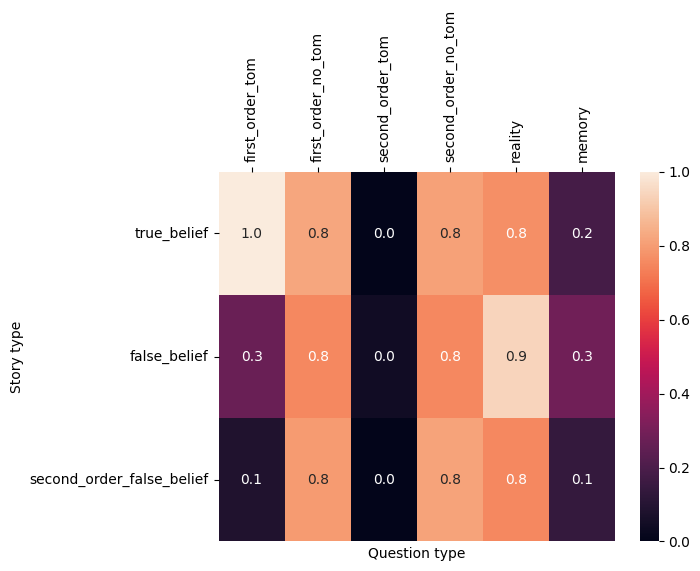

In [75]:
ax = sns.heatmap(accuracy_table, annot=True, fmt=".1f")
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel="Question type", ylabel="Story type")
plt.xticks(rotation=0)
ax.xaxis.tick_top()
